# Fitting Generalized Linear Mixed-effects Models Using Variational Inference

In [8]:
import tensorflow_probability as tfp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
from six.moves import urllib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_context('notebook')
import tensorflow_datasets as tfds
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
tfd = tfp.distributions
tfb = tfp.bijectors

In [9]:
def load_and_preprocess_radon_dataset(state='MN'):
    ds = tfds.load('radon', split='train')
    radon_data = tfds.as_dataframe(ds)
    radon_data.rename(lambda s: s[9:] if s.startswith('feat') else s, axis=1, inplace=True)
    df = radon_data[radon_data.state==state.encode()].copy()
    df['radon'] = df.activity.apply(lambda x: x if x > 0 else 0.1)
    df['county'] = df.county.apply(lambda s: s.decode()).str.strip().str.title()
    df['county'] = df.county.astype(pd.api.types.CategoricalDtype())
    df['county_code'] = df.county.cat.codes
    df["log_radon"] = df['radon'].apply(np.log)
    columns_to_keep = ['log_radon', 'floor', 'county', 'county_code']
    df = df[columns_to_keep].reset_index(drop=True)
    return df
df = load_and_preprocess_radon_dataset()
df.head()

log_radon  floor      county  county_code
0   1.791759      0  Blue Earth            6
1   2.501436      0  Washington           79
2  -0.223144      0    St Louis           69
3   1.193922      0    St Louis           69
4   1.064711      0   Crow Wing           17

In [10]:
def estimate_log_radon(floor):
    return intercept + floor_effect[floor]

Text(0.5, 0.98, 'Distribution of log radon and floors in the dataset')

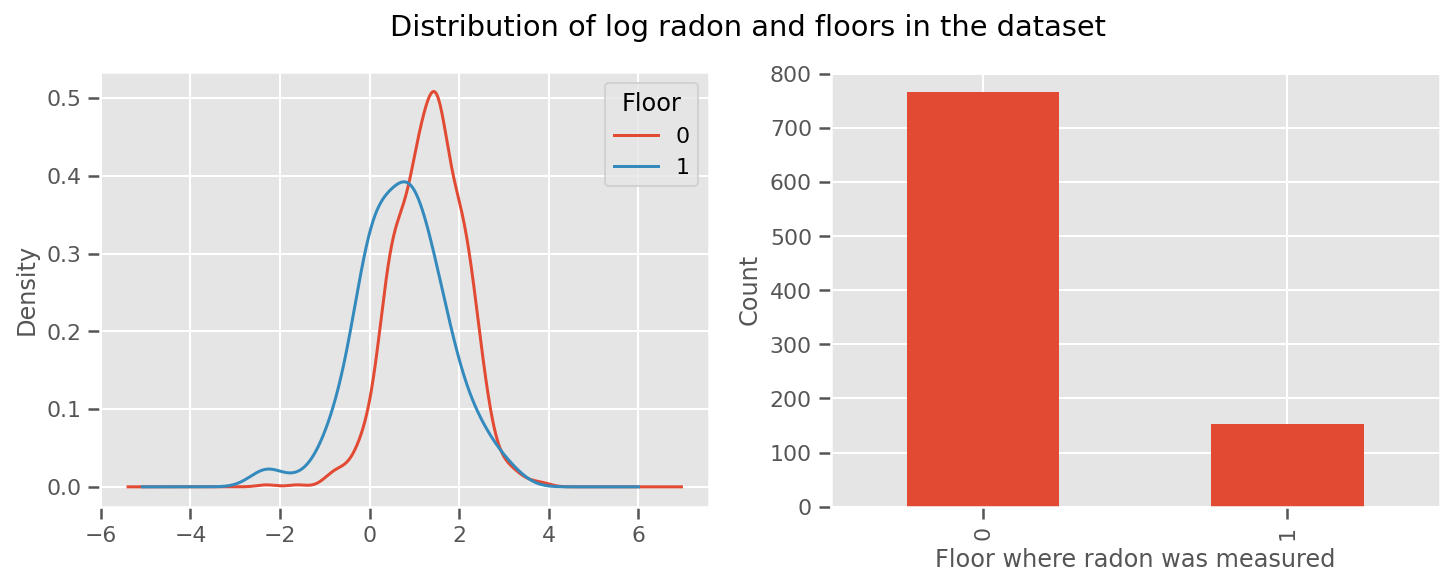

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
df.groupby('floor')['log_radon'].plot(kind='density', ax=ax1)
ax1.legend(title='Floor')

df['floor'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_xlabel('Floor where radon was measured')
ax2.set_ylabel('Count')
fig.suptitle('Distribution of log radon and floors in the dataset')

In [12]:
def estimate_log_radon(floor, county):
    return intercept + floor_effect[floor] + county_effect[county]

Text(0, 0.5, 'Number of readings')

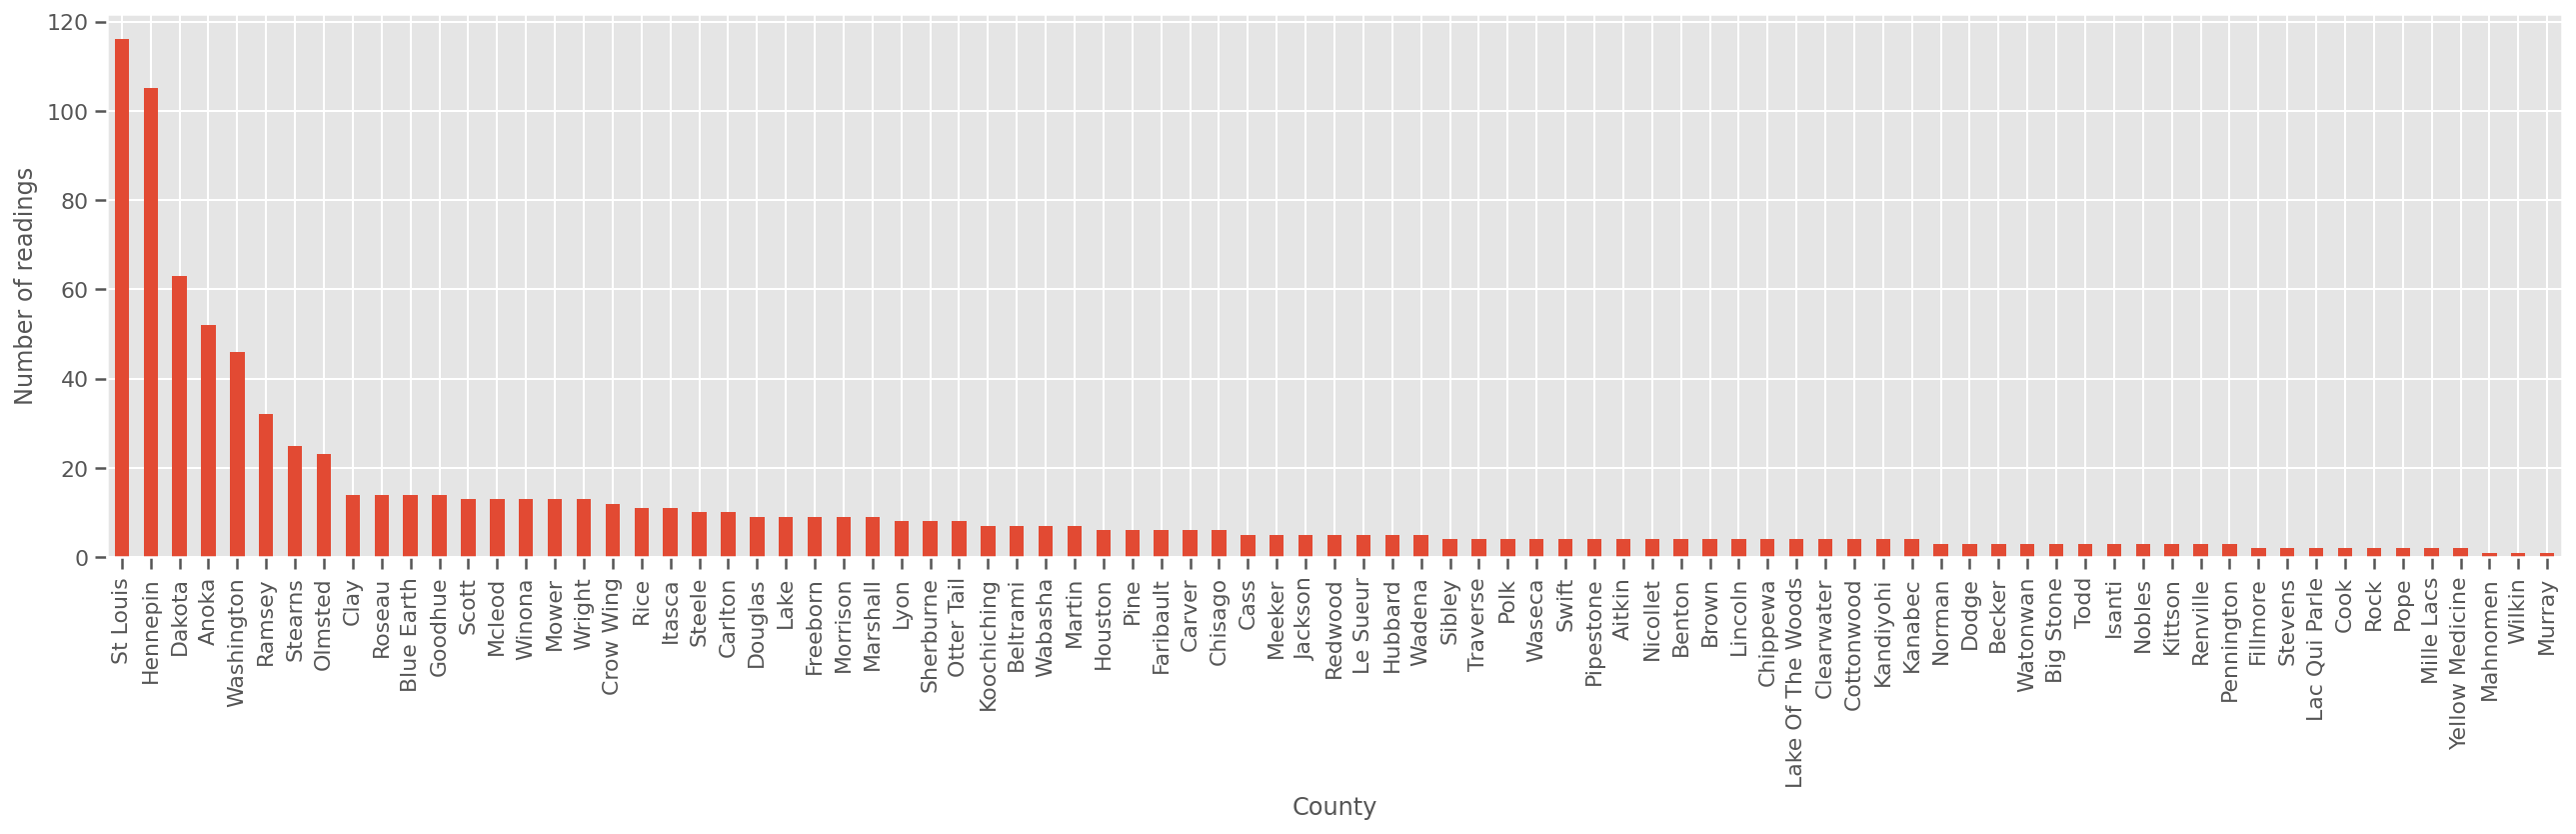

In [13]:
fig, ax = plt.subplots(figsize=(22, 5))
county_freq = df['county'].value_counts()
county_freq.plot(kind='bar', ax=ax)
ax.set_xlabel('County')
ax.set_ylabel('Number of readings')

In [14]:
def estimate_log_radon(floor, county):
    county_mean = county_effect[county]
    random_effect = np.random.normal() * county_scale + county_mean
    return intercept + floor_effect[floor] + random_effect

In [15]:
features = df[['county_code', 'floor']].astype(int)
labels = df[['log_radon']].astype(np.float32).values.flatten()

In [18]:
def make_joint_distribution_coroutine(floor, county, n_counties, n_floors):
    def model():
        county_scale = yield tfd.HalfNormal(scale=1., name='scale_prior')
        intercept = yield tfd.Normal(loc=0., scale=1., name='intercept')
        floor_weight = yield tfd.Normal(loc=0., scale=1., name='floor_weight')
        county_prior = yield tfd.Normal(loc=tf.zeros(n_counties), scale=county_scale, name='county_prior')
        random_effect = tf.gather(county_prior, county, axis=-1)
        fixed_effect = intercept + floor_weight * floor
        linear_response = fixed_effect + random_effect
        yield tfd.Normal(loc=linear_response, scale=1., name='likelihood')
    return tfd.JointDistributionCoroutineAutoBatched(model)
joint = make_joint_distribution_coroutine(features.floor.values, features.county_code.values, df.county.nunique(), 
                                          df.floor.nunique())
def target_log_prob_fn(*args):
    return joint.log_prob(*args, likelihood=labels)

In [22]:
_init_loc = lambda shape=(): tf.Variable(tf.random.uniform(shape, minval=-2., maxval=2.))
_init_scale = lambda shape=(): tfp.util.TransformedVariable(initial_value=tf.random.uniform(shape, minval=0.01, 
                                    maxval=1.), bijector=tfb.Softplus())
n_counties = df.county.nunique()
surrogate_posterior = tfd.JointDistributionSequentialAutoBatched([
    tfb.Softplus()(tfd.Normal(_init_loc(), _init_scale())),
    tfd.Normal(_init_loc(), _init_scale()),
    tfd.Normal(_init_loc(), _init_scale()),
    tfd.Normal(_init_loc([n_counties]), _init_scale([n_counties]))
])

In [27]:
surrogate_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(event_shape=joint.event_shape_tensor()[:-1],
                                                                            constraining_bijectors=[tfb.Softplus(), None, None, None])

TypeError: build_factored_surrogate_posterior() got an unexpected keyword argument 'constraining_bijectors'

In [1]:
optimizer = tf.optimizers.Adam(learning_rate=1e-2)
losses = tfp.vi.fit_surrogate_posterior(target_log_prob_fn, surrogate_posterior, optimizer=optimizer, num_steps=3000, 
                                       seed=42, sample_size=2)
(scale_prior_, intercept_, floor_weight_, county_weights_), _ = surrogate_posterior.sample_distributions() 

NameError: name 'tf' is not defined

# Bayesian Modeling with Joint Distribution

In [2]:
from pprint import pprint 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import arviz as az
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
sns.reset_defaults()
sns.set_context(context='talk', font_scale=0.7)
%config InlineBackend.figure_fromat = 'retina'
%matplotlib inline
tfd = tfp.distributions
tfb = tfp.bijectors
dtype = tf.float64

In [3]:
def log_prob(rvs, xs):
    return sum(rv(*xs[i - 1::-1]).log_prob(xs[i])for i, rv in enumerate(rvs))

C:\Users\jatin\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


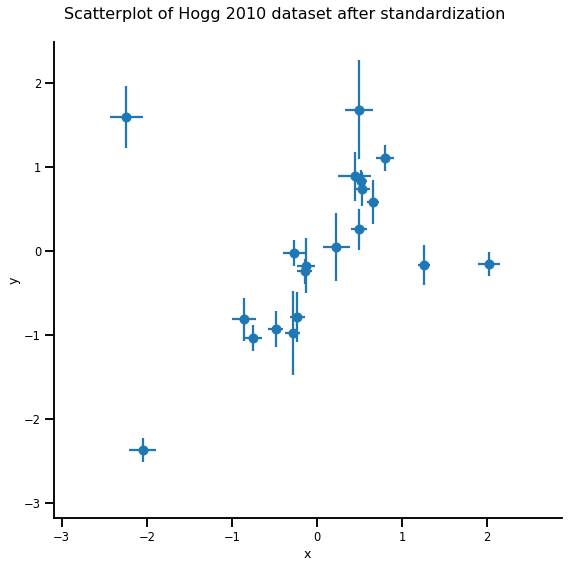

In [4]:
dfhogg = pd.DataFrame(np.array([[1, 201, 592, 61, 9, -0.84],
                               [2, 244, 401, 25, 4, 0.31],
                               [3, 47, 583, 38, 11, 0.64],
                               [4, 287, 402, 15, 7, -0.27],
                               [5, 203, 495, 21, 5, -0.33],
                               [6, 58, 173, 15, 9, 0.67],
                               [7, 210, 479, 27, 4, -0.02],
                               [8, 202, 504, 14, 4, -0.05],
                               [9, 198, 510, 30, 11, -0.84],
                               [10, 158, 416, 16, 7, -0.69],
                               [11, 165, 393, 15, 5, 0.30],
                               [12, 201, 445, 25, 5, -0.46],
                               [13, 157, 317, 52, 5, -0.03],
                               [14, 131, 311, 16, 6, 0.50],
                               [15, 166, 400, 34, 6, 0.73],
                               [16, 160, 337, 31, 5, -0.52],
                               [17, 186, 423, 42, 9, 0.90],
                               [18, 125, 334, 26, 8, 0.40],
                               [19, 218, 533, 16, 6, -0.78],
                               [20, 146, 322, 22, 5, -0.56]]), columns=['id', 'x', 'y', 'sigma_y', 'sigma_x', 'rho_xy'])
dfhogg['id'] = dfhogg['id'] - 1
dfhogg.set_index('id', inplace=True)
dfhoggs = (dfhogg[['x', 'y']] - dfhogg[['x', 'y']].mean(0)) / dfhogg[['x', 'y']].std(0)
dfhoggs['sigma_y'] = dfhogg['sigma_y'] / dfhogg['y'].std(0)
dfhoggs['sigma_x'] = dfhogg['sigma_x'] / dfhogg['x'].std(0)

def plot_hoggs(dfhoggs):
    xlims = (dfhoggs['x'].min() - np.ptp(dfhoggs['x']) / 5,
            dfhoggs['x'].max() + np.ptp(dfhoggs['x']) / 5)
    ylims = (dfhoggs['y'].min() - np.ptp(dfhoggs['y']) / 5,
            dfhoggs['y'].max() + np.ptp(dfhoggs['y']) / 5)
    g = sns.FacetGrid(dfhoggs, size=8)
    _ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker='o', ls='')
    _ = g.axes[0][0].set_ylim(ylims)
    _ = g.axes[0][0].set_xlim(xlims)
    plt.subplots_adjust(top=0.92)
    _ = g.fig.suptitle("Scatterplot of Hogg 2010 dataset after standardization", fontsize=16)
    return g, xlims, ylims
g = plot_hoggs(dfhoggs)

In [5]:
X_np = dfhoggs['x'].values
sigma_y_np = dfhoggs['sigma_y'].values
Y_np = dfhoggs['y'].values

In [6]:
mdl_ols = tfd.JointDistributionSequential([
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    lambda b1, b0: tfd.Normal(loc=b0 + b1*X_np, scale=sigma_y_np)
])

In [7]:
mdl_ols.resolve_graph()

(('b0', ()), ('b1', ()), ('x', ('b1', 'b0')))

In [8]:
mdl_ols.sample()

[<tf.Tensor: shape=(), dtype=float64, numpy=1.0659890300844452>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-1.5797393541275573>,
 <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([-0.60268607, -0.68652497,  4.04893469, -2.24821583, -0.1296507 ,
         4.33943443, -0.09401078,  0.45029849,  0.4476665 ,  1.51029601,
         1.45102347,  0.25639523,  1.23150882,  2.35563052,  1.12928716,
         1.8310455 ,  0.69513271,  2.41693551, -0.3446345 ,  1.58229455])>]

In [9]:
prior_predictive_samples = mdl_ols.sample()
mdl_ols.log_prob(prior_predictive_samples)

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([-3.19226928, -1.44903473, -2.06243751, -2.88354611, -1.77976705,
       -1.13387716, -1.61465791, -1.39106248, -1.67406074, -0.99462181,
       -1.21571933, -1.43706043, -2.52611035, -2.16578119, -1.90894142,
       -2.65635752, -2.68184212, -2.57845416, -5.25846547, -1.33057105])>

In [10]:
mdl_ols.log_prob_parts(prior_predictive_samples)

[<tf.Tensor: shape=(), dtype=float64, numpy=-0.9455455313057295>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-0.9877416213880865>,
 <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([-1.25898213,  0.48425243, -0.12915036, -0.95025895,  0.1535201 ,
         0.79941   ,  0.31862924,  0.54222467,  0.25922642,  0.93866535,
         0.71756782,  0.49622672, -0.5928232 , -0.23249404,  0.02434573,
        -0.72307037, -0.74855497, -0.645167  , -3.32517831,  0.6027161 ])>]

In [11]:
mdl_ols_ = tfd.JointDistributionSequential([
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    lambda b1, b0: tfd.Independent(tfd.Normal(loc=b0 + b1 + X_np, scale=sigma_y_np), reinterpreted_batch_ndims=1)
])

In [12]:
print(mdl_ols_.sample_distributions()[0][-1])
print(mdl_ols.sample_distributions()[0][-1])

tfp.distributions.Independent("IndependentNormal", batch_shape=[], event_shape=[20], dtype=float64)
tfp.distributions.Normal("Normal", batch_shape=[20], event_shape=[], dtype=float64)


In [13]:
prior_predictive_samples = mdl_ols_.sample()
mdl_ols_.log_prob(prior_predictive_samples)

<tf.Tensor: shape=(), dtype=float64, numpy=-4.1443925562720025>

In [14]:
mdl_ols_named = tfd.JointDistributionNamed(dict(likelihood = lambda b0, b1: tfd.Independent(tfd.Normal(loc=b0+b1*X_np,
                                                                                                      scale=sigma_y_np),
                                                                                           reinterpreted_batch_ndims=1),
                                               b0 = tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
                                               b1 = tfd.Normal(loc=tf.cast(0, dtype), scale=1.)))
mdl_ols_named.log_prob(mdl_ols_named.sample())

<tf.Tensor: shape=(), dtype=float64, numpy=-2.277212369318351>

In [15]:
mdl_ols_named.sample()

{'b1': <tf.Tensor: shape=(), dtype=float64, numpy=-2.3901050337579055>,
 'b0': <tf.Tensor: shape=(), dtype=float64, numpy=-0.015423781563805644>,
 'likelihood': <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([-1.77769342, -3.07891838,  5.48086686, -4.82109224, -0.74061111,
         4.78703406, -1.36852438, -1.22154837, -0.8712892 ,  0.53137485,
         0.33609944, -1.44036465,  0.78729044,  1.82009156,  0.76139384,
         0.48567389, -1.18570842,  1.67711793, -1.67542032,  1.40119197])>}

In [16]:
Root = tfd.JointDistributionCoroutine.Root
def model():
    b1 = yield Root(tfd.Normal(loc=tf.cast(0, dtype), scale=1.))
    b0 = yield Root(tfd.Normal(loc=tf.cast(0, dtype), scale=1.))
    yhat = b0 + b1 * X_np
    likelihood = yield tfd.Independent(tfd.Normal(loc=yhat, scale=sigma_y_np), reinterpreted_batch_ndims=1)
mdl_ols_coroutine = tfd.JointDistributionCoroutine(model)
mdl_ols_coroutine.log_prob(mdl_ols_coroutine.sample())

<tf.Tensor: shape=(), dtype=float64, numpy=-9.729909570313856>

In [17]:
mdl_ols_coroutine.sample()

StructTuple(
  var0=<tf.Tensor: shape=(), dtype=float64, numpy=-0.9301500117489634>,
  var1=<tf.Tensor: shape=(), dtype=float64, numpy=0.8912938484006059>,
  var2=<tf.Tensor: shape=(20,), dtype=float64, numpy=
    array([ 0.43474349, -0.45085723,  2.95674194, -0.81082888,  0.40237728,
            2.63337597,  0.07146136,  0.39701235,  1.29557575,  1.63279138,
            0.811591  ,  0.02226028,  0.39326546,  1.48169938,  0.75357104,
            1.12557714,  0.5827403 ,  1.47345678,  0.42694934,  0.84613921])>
)

In [57]:
# bfgs and lbfgs currently requries a function that returns both the value and
# gradient re the input.
import functools

def _make_val_and_grad_fn(value_fn):
  @functools.wraps(value_fn)
  def val_and_grad(x):
    return tfp.math.value_and_gradient(value_fn, x)
  return val_and_grad

# Map a list of tensors (e.g., output from JDSeq.sample([...])) to a single tensor
# modify from tfd.Blockwise
from tensorflow_probability.python.internal import dtype_util
from tensorflow_probability.python.internal import prefer_static as ps
from tensorflow_probability.python.internal import tensorshape_util

class Mapper:
  """Basically, this is a bijector without log-jacobian correction."""
  def __init__(self, list_of_tensors, list_of_bijectors, event_shape):
    self.dtype = dtype_util.common_dtype(
        list_of_tensors, dtype_hint=tf.float32)
    self.list_of_tensors = list_of_tensors
    self.bijectors = list_of_bijectors
    self.event_shape = event_shape

  def flatten_and_concat(self, list_of_tensors):
    def _reshape_map_part(part, event_shape, bijector):
      part = tf.cast(bijector.inverse(part), self.dtype)
      static_rank = tf.get_static_value(ps.rank_from_shape(event_shape))
      if static_rank == 1:
        return part
      new_shape = ps.concat([
          ps.shape(part)[:ps.size(ps.shape(part)) - ps.size(event_shape)], 
          [-1]
      ], axis=-1)
      return tf.reshape(part, ps.cast(new_shape, tf.int32))

    x = tf.nest.map_structure(_reshape_map_part,
                              list_of_tensors,
                              self.event_shape,
                              self.bijectors)
    return tf.concat(tf.nest.flatten(x), axis=-1)

  def split_and_reshape(self, x):
    assertions = []
    message = 'Input must have at least one dimension.'
    if tensorshape_util.rank(x.shape) is not None:
      if tensorshape_util.rank(x.shape) == 0:
        raise ValueError(message)
    else:
      assertions.append(assert_util.assert_rank_at_least(x, 1, message=message))
    with tf.control_dependencies(assertions):
      splits = [
          tf.cast(ps.maximum(1, ps.reduce_prod(s)), tf.int32)
          for s in tf.nest.flatten(self.event_shape)
      ]
      x = tf.nest.pack_sequence_as(
          self.event_shape, tf.split(x, splits, axis=-1))
      def _reshape_map_part(part, part_org, event_shape, bijector):
        part = tf.cast(bijector.forward(part), part_org.dtype)
        static_rank = tf.get_static_value(ps.rank_from_shape(event_shape))
        if static_rank == 1:
          return part
        new_shape = ps.concat([ps.shape(part)[:-1], event_shape], axis=-1)
        return tf.reshape(part, ps.cast(new_shape, tf.int32))

      x = tf.nest.map_structure(_reshape_map_part,
                                x, 
                                self.list_of_tensors,
                                self.event_shape,
                                self.bijectors)
    return x

In [19]:
mapper = Mapper(mdl_ols_.sample()[:-1],
                [tfb.Identity(), tfb.Identity()],
                mdl_ols_.event_shape[:-1])

# mapper.split_and_reshape(mapper.flatten_and_concat(mdl_ols_.sample()[:-1]))

In [20]:
@_make_val_and_grad_fn
def neg_log_likelihood(x):
  # Generate a function closure so that we are computing the log_prob
  # conditioned on the observed data. Note also that tfp.optimizer.* takes a 
  # single tensor as input.
  return -mdl_ols_.log_prob(mapper.split_and_reshape(x) + [Y_np])

lbfgs_results = tfp.optimizer.lbfgs_minimize(
    neg_log_likelihood,
    initial_position=tf.zeros(2, dtype=dtype),
    tolerance=1e-20,
    x_tolerance=1e-8
)

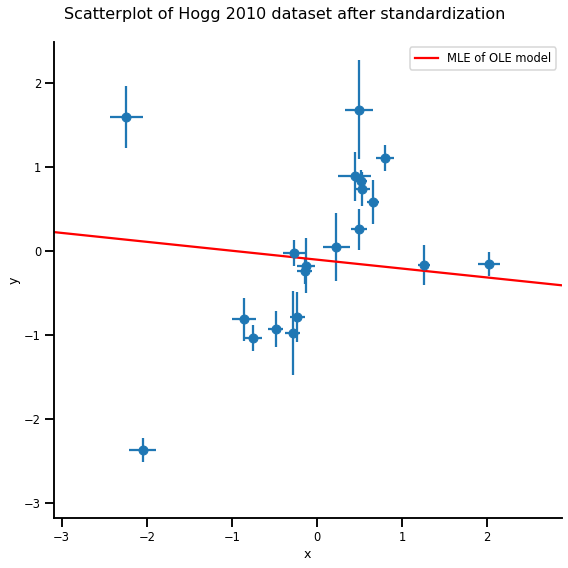

In [21]:
b0est, b1est = lbfgs_results.position.numpy()
g, xlims, ylims = plot_hoggs(dfhoggs)
xrange = np.linspace(xlims[0], xlims[1], 100)
g.axes[0][0].plot(xrange, b0est + b1est*xrange, color='r', label="MLE of OLE model")
plt.legend()

In [22]:
mdl_ols_.sample()

[<tf.Tensor: shape=(), dtype=float64, numpy=0.16707102671032195>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.700969921662375>,
 <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([ 7.04358756e-01,  2.39906197e+00, -1.82799099e+00,  2.98957287e+00,
         1.14679061e+00, -1.25005239e+00,  1.48964435e+00,  1.27201293e+00,
         9.51021527e-01,  3.06525417e-01,  6.97751565e-01,  1.11234769e+00,
         3.20463953e-01,  2.68477815e-01,  1.37668602e+00,  4.73339291e-01,
         1.18397221e+00, -4.59918218e-01,  1.52299954e+00,  5.84412383e-04])>]

In [23]:
mdl_ols_batch = tfd.JointDistributionSequential([
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    lambda b1, b0: tfd.Independent(tfd.Normal(loc=b0[..., tf.newaxis] + b1[..., tf.newaxis] * X_np[tf.newaxis, ...], 
                                             scale=sigma_y_np[tf.newaxis, ...]), reinterpreted_batch_ndims=1)
])
mdl_ols_batch.resolve_graph()

(('b0', ()), ('b1', ()), ('x', ('b1', 'b0')))

In [24]:
b0, b1, y = mdl_ols_batch.sample(4)
mdl_ols_batch.log_prob_parts([b0, b1, y])

[<tf.Tensor: shape=(4,), dtype=float64, numpy=array([-2.04110466, -1.81095913, -3.36265787, -0.92001973])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-1.00334718, -2.12169095, -4.61693717, -0.99436425])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([ 0.11932677, -0.05587129,  1.34372874,  0.22917404])>]

In [25]:
def gen_ols_batch_model(X, sigma, hyperprior_mean=0, hyperprior_scale=1):
    hyper_mean = tf.cast(hyperprior_mean, dtype)
    hyper_scale = tf.cast(hyperprior_scale, dtype)
    return tfd.JointDistributionSequential([
        tfd.Sample(tfd.Normal(loc=hyper_mean, scale=hyper_scale), sample_shape=1),
        tfd.Sample(tfd.Normal(loc=hyper_mean, scale=hyper_scale), sample_shape=1),
        lambda b1, b0: tfd.Independent(tfd.Normal(loc=b0 + b1 * X, scale=sigma), reinterpreted_batch_ndims=1)
    ], validate_args=True)
mdl_ols_batch = gen_ols_batch_model(X_np[tf.newaxis, ...], sigma_y_np[tf.newaxis, ...])
_ = mdl_ols_batch.sample()
_ = mdl_ols_batch.sample(4)
_ = mdl_ols_batch.sample([3, 4])

In [26]:
def validate_log_prob_part(model, batch_shape=1, observed=-1):
    samples = model.sample(batch_shape)
    logp_part = list(model.log_prob_parts(samples))
    logp_part.pop(observed)
    for part in logp_part:
        tf.assert_equal(part.shape, logp_part[-1].shape)
validate_log_prob_part(mdl_ols_batch, 4)

In [28]:
def ols_logp_batch(b0, b1, Y):
    b0_prior = tfd.Normal(loc=tf.cast(0, dtype), scale=1.)
    b1_prior = tfd.Normal(loc=tf.cast(0, dtype), scale=1.)
    likelihood = tfd.Normal(loc=b0 + b1 * X_np[None, :], scale=sigma_y_np)
    return tf.reduce_sum(b0_prior.log_prob(b0), axis=-1) + tf.reduce_sum(b1_prior.log_prob(b1), axis=-1) + tf.reduce_sum(likelihood.log_prob(Y), axis=-1)
b0, b1, x = mdl_ols_batch.sample(4)
print(mdl_ols_batch.log_prob([b0, b1, Y_np]).numpy())
print(ols_logp_batch(b0, b1, Y_np).numpy())

[-444.60569891 -309.33055541 -175.02288857 -145.54464906]
[-444.60569891 -309.33055541 -175.02288857 -145.54464906]


In [33]:
@tf.function(autograph=False, experimental_compile=True)
def run_chain(init_state, step_size, target_log_prob_fn, unconstraining_bijectors, num_steps=500, burnin=50):
    def trace_fn(_, pkr):
        return (pkr.inner_results.inner_results.target_log_prob,
               pkr.inner_results.inner_results.leapfrogs_taken,
               pkr.inner_results.inner_results.has_divergence,
               pkr.inner_results.inner_results.energy,
               pkr.inner_results.inner_results.log_accept_ratio)
    kernel = tfp.mcmc.TransformedTransitionKernel(inner_kernel=tfp.mcmc.NoUTurnSampler(target_log_prob_fn, 
                                                                                       step_size=step_size),
                                                 bijector=unconstraining_bijectors)
    hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=burnin, 
                                                 step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
                                                     inner_results=pkr.inner_results._replace(step_size=new_step_size)),
                                                step_size_getter_fn = lambda pkr: pkr.inner_results.step_size, 
                                                 log_accept_prob_getter_fn=lambda pkr: 
                                                 pkr.inner_results.log_accept_ratio)
    chain_state, sampler_stat = tfp.mcmc.sample_chain(num_burnin_steps=burnin, num_results=num_steps, 
                                                      current_state=init_state, kernel=hmc, trace_fn = trace_fn)
    return chain_state, sampler_stat

In [34]:
nchain = 10
b0, b1, _ = mdl_ols_batch.sample(nchain)
init_state = [b0, b1]
step_size = [tf.cast(i, dtype=dtype) for i in [.1, .1]]
target_log_prob_fn = lambda *x: mdl_ols_batch.log_prob(x + (Y_np, ))
unconstraining_bijectors = [tfb.Identity(), tfb.Identity()]
samples, sampler_stat = run_chain(init_state, step_size, target_log_prob_fn, unconstraining_bijectors)

In [35]:
sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}
sample_stats['tree_size'] = np.diff(sample_stats['tree_size'], axis=1)
var_name = ['b0', 'b1']
posterior = {k:np.swapaxes(v.numpy(), 1, 0) for k, v in zip(var_name, samples)}
az_trace = az.from_dict(posterior=posterior, sample_stats = sample_stats)

array([[<AxesSubplot:title={'center':'b0'}>,
        <AxesSubplot:title={'center':'b0'}>],
       [<AxesSubplot:title={'center':'b1'}>,
        <AxesSubplot:title={'center':'b1'}>]], dtype=object)

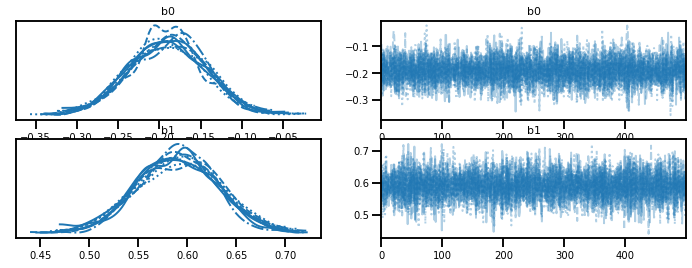

In [36]:
az.plot_trace(az_trace)

array([<AxesSubplot:>], dtype=object)

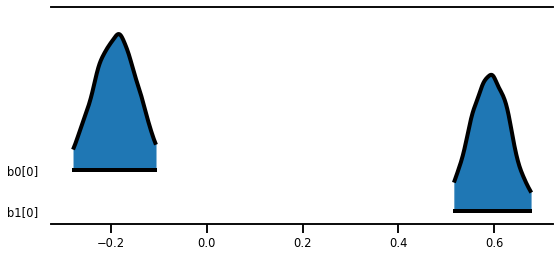

In [37]:
az.plot_forest(az_trace, kind='ridgeplot', linewidth=4, combined=True, ridgeplot_overlap=1.5, figsize=(9, 4))

C:\Users\jatin\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


ValueError: x has 5 columns but y has 50 columns

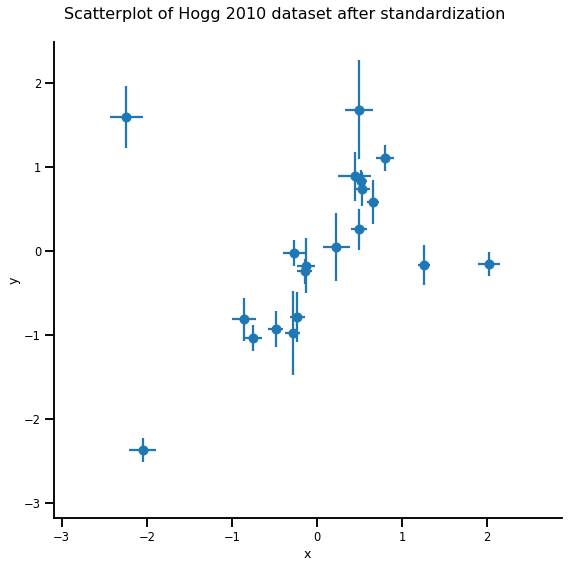

In [38]:
k = 5
b0est, b1est = az_trace.posterior['b0'][:, -k:].values, az_trace.posterior['b1'][:, -k:].values
g, xlims, ylims = plot_hoggs(dfhoggs)
xrange = np.linspace(xlims[0], xlims[1], 100)[None, :]
g.axes[0][0].plot(np.tile(xrange, (k, 1)).T, (np.reshape(b0est, [-1, 1]) + np.reshape(b1est, [-1, 1]) * xrange).T, 
                  alpha=.25, color='r')
plt.legend([g.axes[0][0].lines[-1]], ['MCMC OLE model'])

In [41]:
def gen_studentt_model(X, sigma, hyper_mean = 0, hyper_scale=1, lower=1, upper=100):
    loc = tf.cast(hyper_mean, dtype)
    scale = tf.cast(hyper_scale, dtype)
    low = tf.cast(lower, dtype)
    high = tf.cast(upper, dtype)
    return tfd.JointDistributionSequential([
        tfd.Sample(tfd.Normal(loc, scale), sample_shape=1),
        tfd.Sample(tfd.Normal(loc, scale), sample_shape=1),
        tfd.Sample(tfd.Normal(low, high), sample_shape=1),
        lambda df, b1, b0: tfd.Independent(tfd.StudentT(df=df, loc=b0 + b1 * X, scale=sigma))
    ], validate_args=True)
mdl_studentt = gen_studentt_model(X_np[tf.newaxis, ...], sigma_y_np[tf.newaxis, ...])
mdl_studentt.resolve_graph()

Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


(('b0', ()), ('b1', ()), ('df', ()), ('x', ('df', 'b1', 'b0')))

In [42]:
validate_log_prob_part(mdl_studentt, 4)

In [44]:
b0, b1, df, x = mdl_studentt.sample(1000)
x.shape

TensorShape([1000, 20])

In [54]:
a, b = tf.constant(1., dtype), tf.constant(100., dtype)
tfp_interval = tfb.Inline(inverse_fn = (lambda x: tf.math.log(x-a) - tf.math.log(b-x)),
                         forward_fn=(lambda y: (b - a) * tf.sigmoid(y) + a),
                         forward_log_det_jacobian_fn=(lambda x: tf.math.log(b - a) - 2 * tf.nn.softplus(-x) - x),
                         forward_min_event_ndims=0, name="interval")
unconstraining_bijectors = [tfb.Identity(), tfb.Identity, tfp_interval]
mapper = Mapper(mdl_studentt.sample()[:-1], unconstraining_bijectors, mdl_studentt.event_shape[:-1])

In [55]:
def neg_log_likelihood(x):
    return -tf.squeeze(mdl_studentt.log_prob(mapper.split_and_reshape(x) + [Y_np]))
lbfgs_results = tfp.optimizer.lbfgs_minimize(neg_log_likelihood, initial_position=mapper.flatten_and_concat(
    mdl_studentt.sample()[:-1]), tolerance=1e-20, x_tolerance=1e-20)

ValueError: The two structures don't have the same nested structure.

First structure: type=list str=[<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.73990818])>, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1.59708357])>, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([41.52091512])>]

Second structure: type=DType str=<dtype: 'float64'>

More specifically: Substructure "type=list str=[<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.73990818])>, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1.59708357])>, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([41.52091512])>]" is a sequence, while substructure "type=DType str=<dtype: 'float64'>" is not
Entire first structure:
[., ., .]
Entire second structure:
.

In [56]:
b0est, b1est, dfest = lbfgs_results.position.numpy()
g, xlims, ylims = plot_hoggs(dfhoggs)
xrange = np.linspace(xlims[0], xlims[1], 100)
g.axes[0][0].plot(xrange, b0est + b1est*xrange, color='r', label="MLE of StudentT model")

ValueError: not enough values to unpack (expected 3, got 2)

HTTPError: HTTP Error 404: Not Found

# Multilevel Modeling Primer in Tensorflow Probability

In [1]:
import collections
import os
from six.moves import urllib
import daft as daft
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
tfb = tfp.bijectors
warnings.simplefilter('ignore')

In [2]:
def load_and_preprocess_radon_dataset(state='MN'):
    ds = tfds.load('radon', split='train')
    radon_data = tfds.as_dataframe(ds)
    radon_data.rename(lambda s: s[9:] if s.startswith('feat') else s, axis=1, inplace=True)
    df = radon_data[radon_data.state==state.encode()].copy()
    df['radon'] = df.activity.apply(lambda x: x if x > 0. else 0.1)
    df['county'] = df.county.apply(lambda s: s.decode()).str.strip().str.title()
    county_name = sorted(df.county.unique())
    df['county'] = df.county.astype(pd.api.types.CategoricalDtype(categories=county_name)).cat.codes
    county_name = list(map(str.strip, county_name))
    df['log_radon'] = df['radon'].apply(np.log)
    df['log_uranium_ppm'] = df['Uppm'].apply(np.log)
    df = df[['idnum', 'log_radon', 'floor', 'county', 'log_uranium_ppm']]
    return df, county_name

In [3]:
radon, county_name = load_and_preprocess_radon_dataset()
num_counties = len(county_name)
num_observations = len(radon)

In [4]:
county = tf.convert_to_tensor(radon['county'], dtype=tf.int32)
floor = tf.convert_to_tensor(radon['floor'], dtype=tf.float32)
log_radon = tf.convert_to_tensor(radon['log_radon'], dtype=tf.float32)
log_uranium = tf.convert_to_tensor(radon['log_uranium_ppm'], dtype=tf.float32)

In [5]:
radon.head()

idnum  log_radon  floor  county  log_uranium_ppm
8    5161   1.791759      0       6         0.271614
29   5926   2.501436      0      79        -0.147484
32   5793  -0.223144      0      69        -0.474674
39   5829   1.193922      0      69        -0.474674
60   5231   1.064711      0      17        -0.633391

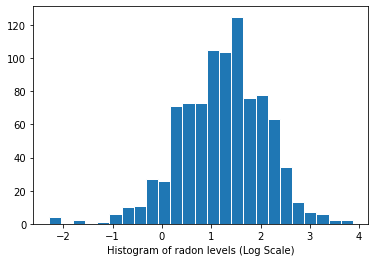

In [6]:
plt.hist(log_radon.numpy(), bins=25, edgecolor='white')
plt.xlabel("Histogram of radon levels (Log Scale)")
plt.show()

In [7]:
@tf.function
def affine(x, kernel_diag, bias=tf.zeros([])):
    kernel_diag = tf.ones_like(x) * kernel_diag
    bias = tf.ones_like(x) * bias
    return x * kernel_diag + bias

In [8]:
def pooled_model(floor):
    return tfd.JointDistributionSequential([
        tfd.Normal(loc=0., scale=1e5),
        tfd.Normal(loc=0., scale=1e5),
        tfd.HalfCauchy(loc=0., scale=5),
        lambda s, b1, b0: tfd.MultivariateNormalDiag(loc=affine(floor, b1[..., tf.newaxis], b0[..., tf.newaxis]),
                                                     scale_identity_multiplier=s)
    ])
@tf.function
def pooled_log_prob(alpha, beta, sigma):
    return pooled_model(floor).log_prob([alpha, beta, sigma, log_radon])

In [9]:
def sample_pooled(num_chains, num_results, num_burnin_steps, num_observations):
    hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=pooled_log_prob, num_leapfrog_steps=10, step_size=0.005)
    initial_state = [
        tf.zeros([num_chains], name='init_alpha'),
        tf.zeros([num_chains], name="init_beta"),
        tf.ones([num_chains], name='init_sigma')
    ]
    unconstraining_bijectors = [
        tfb.Identity(),
        tfb.Identity(),
        tfb.Exp()
    ]
    kernel = tfp.mcmc.TransformedTransitionKernel(inner_kernel=hmc, bijector=unconstraining_bijectors)
    samples, kernel_results = tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps,
                                                   current_state=initial_state, kernel=kernel)
    acceptance_probs = tf.reduce_mean(tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)
    return samples, acceptance_probs

In [10]:
PooledModel = collections.namedtuple('PooledModel', ['alpha', 'beta', 'sigma'])
samples, acceptance_probs = sample_pooled(num_chains=4, num_results=1000, num_burnin_steps=1000, num_observations=
                                         num_observations)
print('Acceptance Probability for each chain: ', acceptance_probs.numpy())
pooled_samples = PooledModel._make(samples)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Acceptance Probability for each chain:  [0.991 0.995 0.994 0.992]


In [11]:
for var, var_samples in pooled_samples._asdict().items():
    print('R-hat for ', var, ':\t', tfp.mcmc.potential_scale_reduction(var_samples).numpy())

R-hat for  alpha :	 1.0018573
R-hat for  beta :	 1.0049989
R-hat for  sigma :	 0.9992019


In [12]:
def reduce_samples(var_samples, reduce_fn):
    if isinstance(var_samples, tf.Tensor):
        var_samples = var_samples.numpy()
    var_samples = np.reshape(var_samples, (-1,) + var_samples.shape[2:])
    return np.apply_along_axis(reduce_fn, axis=0, arr=var_samples)
sample_mean = lambda samples: reduce_samples(samples, np.mean)

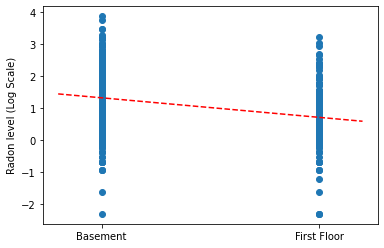

In [13]:
LinearEstimates = collections.namedtuple('LinearEstimates', ['intercept', 'slope'])
pooled_estimate = LinearEstimates(intercept=sample_mean(pooled_samples.alpha), 
                                 slope=sample_mean(pooled_samples.beta))
plt.scatter(radon.floor, radon.log_radon)
xvals = np.linspace(-0.2, 1.2)
plt.ylabel('Radon level (Log Scale)')
plt.xticks([0, 1], ['Basement', 'First Floor'])
plt.plot(xvals, pooled_estimate.intercept + pooled_estimate.slope * xvals, 'r--')
plt.show()

In [14]:
def plot_traces(var_name, samples, num_chains):
    if isinstance(samples, tf.Tensor):
        samples = samples.numpy()
    fig, axes = plt.subplots(1, 2, figsize=(14, 1.5), sharex='col', sharey='col')
    for chain in range(num_chains):
        axes[0].plot(samples[:, chain], alpha=0.7)
        axes[0].title.set_text("'{}' trace".format(var_name))
        sns.kdeplot(samples[:, chain], ax=axes[1], shade=False)
        axes[1].title.set_text("'{}' distribution".format(var_name))
        axes[0].set_xlabel('Iteration')
        axes[1].set_xlabel(var_name)
    plt.show()

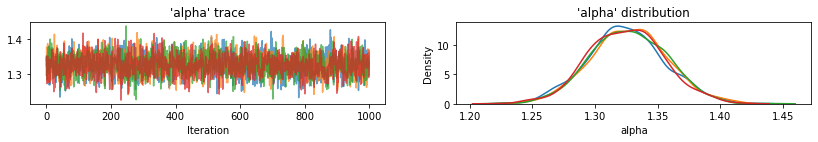

In [15]:
for var, var_samples in pooled_samples._asdict().items():
    plot_traces(var, samples=var_samples, num_chains=4)

In [16]:
def unpooled_model(floor, county):
    return tfd.JointDistributionSequential([
        tfd.MultivariateNormalDiag(loc=tf.zeros([num_counties]), scale_identity_multiplier=1e5),
        tfd.Normal(loc=0., scale=1e5),
        tfd.HalfCauchy(loc=0., scale=5),
        lambda s, b1, b0: tfd.MultivariateNormalDiag(loc=affine(floor, b1[..., tf.newaxis], 
                                                                tf.gather(b0, county, axis=-1)), 
                                                     scale_identity_multiplier=s)
    ])
@tf.function
def unpooled_log_prob(beta0, beta1, sigma):
    return unpooled_model(floor, county).log_prob([beta0, beta1, sigma, log_radon])

In [17]:
@tf.function
def sample_unpooled(num_chains, num_results, num_burnin_steps):
    hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=unpooled_log_prob, num_leapfrog_steps=10, step_size=0.025)
    initial_state=[tf.zeros([num_chains, num_counties], name='init_beta0'), 
                  tf.zeros([num_chains], name='init_beta1'),
                  tf.ones([num_chains], name='init_sigma')]
    unconstraining_bijectors = [
        tfb.Identity(),
        tfb.Identity(),
        tfb.Exp()
    ]
    kernel = tfp.mcmc.TransformedTransitionKernel(inner_kernel=hmc, bijector=unconstraining_bijectors)
    sample, kernel_results = tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                                                  current_state=initial_state, kernel=kernel)
    acceptance_probs = tf.reduce_mean(tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)
    return samples, acceptance_probs

In [18]:
UnPooledModel = collections.namedtuple('UnpooledModel', ['alpha', 'beta', 'sigma'])
samples, acceptance_probs = sample_unpooled(num_chains=4, num_results=1000, num_burnin_steps=1000)
print('Accaptance Probabilities:', acceptance_probs.numpy())
unpooled_samples = UnPooledModel._make(samples)
print('R-hat for beta:', tfp.mcmc.potential_scale_reduction(unpooled_samples.beta).numpy())
print('R-hat for sigma:', tfp.mcmc.potential_scale_reduction(unpooled_samples.sigma).numpy())

Accaptance Probabilities: [0.896 0.891 0.873 0.897]
R-hat for beta: 1.0049989
R-hat for sigma: 0.9992019


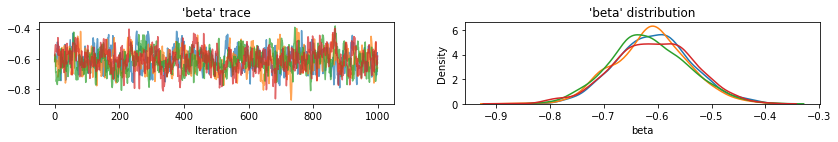

In [19]:
plot_traces(var_name='beta', samples=unpooled_samples.beta, num_chains=4)
plot_traces(var_name='sigma', samples=unpooled_samples.sigma, num_chains=4)

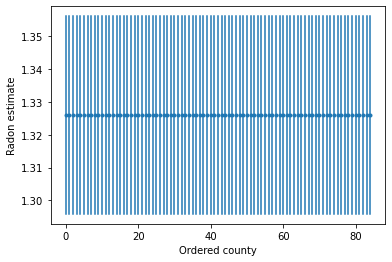

In [20]:
unpooled_intercepts = reduce_samples(unpooled_samples.alpha, np.mean)
unpooled_intercepts_se = reduce_samples(unpooled_samples.alpha, np.std)
def plot_ordered_estimates():
    means = pd.Series(unpooled_intercepts, index=county_name)
    std_errors = pd.Series(unpooled_intercepts_se, index=county_name)
    order = means.sort_values().index
    plt.plot(range(num_counties), means[order], '.')
    for i, m, se in zip(range(num_counties), means[order], std_errors[order]):
        plt.plot([i, i], [m-se, m + se], 'C0-')
    plt.xlabel("Ordered county")
    plt.ylabel('Radon estimate')
    plt.show()
plot_ordered_estimates()

In [21]:
def partial_pooling_model(county):
    return tfd.JointDistributionSequential([
        tfd.Normal(loc=0., scale=1e5),
        tfd.HalfCauchy(loc=0., scale=5),
        lambda sigma_a, mu_a: tfd.MultivariateNormalDiag(loc=mu_a[..., tf.newaxis] * tf.ones([num_counties])[tf.newaxis, ...], 
                                                        scale_identity_multiplier=sigma_a),
        tfd.HalfCauchy(loc=0., scale=5),
        lambda sigma_y, a: tfd.MultivariateNormalDiag(loc=tf.gather(a, county, axis=-1), scale_identity_multiplier=sigma_y)
    ])

@tf.function
def partial_pooling_log_prob(mu_a, sigma_a, a, sigma_y):
    return partial_pooling_model(county).log_prob([mu_a, sigma_a, a, sigma_y, log_radon])

In [22]:
@tf.function
def sample_partial_pooling(num_chains, num_results, num_burnin_steps):
    hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=partial_pooling_log_prob, num_leapfrog_steps=10, 
                                         step_size=0.01)
    initial_state = [
        tf.zeros([num_chains], name='init_mu_a'),
        tf.ones([num_chains], name='init_sigma_a'),
        tf.zeros([num_chains, num_counties], name='init_a'),
        tf.ones([num_chains], name="init_sigma_y")
    ]
    unconstraining_bijectors = [
        tfb.Identity(),
        tfb.Exp(),
        tfb.Identity(),
        tfb.Exp()
    ]
    kernel = tfp.mcmc.TransformedTransitionKernel(inner_kernel=hmc, bijector=unconstraining_bijectors)
    samples, kernel_results = tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                                                   current_state=initial_state, kernel=kernel)
    acceptance_probs = tf.reduce_mean(tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)
    return samples, acceptance_probs

In [23]:
PartialPoolingModel = collections.namedtuple('PartialPoolingModel', ['mu_a', 'sigma_a', 'a', 'sigma_y'])
samples, acceptance_probs = sample_partial_pooling(num_chains=4, num_results=1000, num_burnin_steps=1000)
print("Acceptance Probabilities:", acceptance_probs.numpy())
partial_pooling_samples = PartialPoolingModel._make(samples)

Acceptance Probabilities: [0.981 0.983 0.984 0.986]


In [24]:
for var in ['mu_a', 'sigma_a', 'sigma_y']:
    print('R-hat for ', var, '\t:', tfp.mcmc.potential_scale_reduction(getattr(partial_pooling_samples, var)).numpy())

R-hat for  mu_a 	: 1.0751888
R-hat for  sigma_a 	: 1.0641806
R-hat for  sigma_y 	: 1.0025215


In [25]:
partial_pooling_intercepts = reduce_samples(partial_pooling_samples.a.numpy(), np.mean)
partial_pooling_intercepts_se = reduce_samples(partial_pooling_samples.a.numpy(), np.std)

In [26]:
def varying_intercept_model(floor, county):
    return tfd.JointDistributionSequential([
        tfd.Normal(loc=0., scale=1e5),
        tfd.HalfCauchy(loc=0., scale=5),
        lambda sigma_a, mu_a: tfd.MultivariateNormalDiag(loc=affine(tf.ones([num_counties]), mu_a[..., tf.newaxis]),
                                                         scale_identity_multiplier=sigma_a),
        tfd.Normal(loc=0., scale=1e5),
        tfd.HalfCauchy(loc=0., scale=5),
        lambda sigma_y, b, a: tfd.MultivariateNormalDiag(loc=affine(floor, b[..., tf.newaxis], tf.gather(a, county, axis=-1)),
                                                        scale_identity_multiplier=sigma_y)
    ])
def varying_intercept_log_prob(mu_a, sigma_a, a, b, sigma_y):
    return varying_intercept_model(floor, county).log_prob([mu_a, sigma_a, a, b, sigma_y, log_radon])

In [27]:
@tf.function
def sample_varying_intercepts(num_chains, num_results, num_burnin_steps):
    hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=varying_intercept_log_prob, 
                                        num_leapfrog_steps=10, step_size=0.01)
    initial_state = [
        tf.zeros([num_chains], name="init_mu_a"),
        tf.ones([num_chains], name='init_sigma_a'),
        tf.zeros([num_chains, num_counties], name='init_a'),
        tf.zeros([num_chains], name='init_b'),
        tf.ones([num_chains], name='init_sigma_y')
    ]
    unconstraining_bijectors = [
        tfb.Identity(),
        tfb.Exp(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Exp()
    ]
    kernel = tfp.mcmc.TransformedTransitionKernel(inner_kernel=hmc, bijector=unconstraining_bijectors)
    samples, kernel_results = tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                                                    current_state=initial_state, kernel=kernel)
    acceptance_probs = tf.reduce_mean(tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)
    return samples, acceptance_probs

In [28]:
VaryingInterceptsModel = collections.namedtuple('VaryingInterceptsModel', ['mu_a', 'sigma_a', 'a', 'b', 'sigma_y'])
samples, acceptance_probs = sample_varying_intercepts(num_chains=4, num_results=1000, num_burnin_steps=1000)
print('Acceptance Probabilities:', acceptance_probs.numpy())
varying_intercepts_samples = VaryingInterceptsModel._make(samples)

Acceptance Probabilities: [0.986 0.983 0.984 0.989]


In [29]:
for var in ['mu_a', 'sigma_a', 'b', 'sigma_y']:
    print('R-hat for ', var, ":", tfp.mcmc.potential_scale_reduction(getattr(varying_intercepts_samples, var)).numpy())

R-hat for  mu_a : 1.0176781
R-hat for  sigma_a : 1.0282907
R-hat for  b : 1.0155231
R-hat for  sigma_y : 1.0000163


In [30]:
varying_intercepts_estimates = LinearEstimates(sample_mean(varying_intercepts_samples.a), 
                                               sample_mean(varying_intercepts_samples.b))
for var in ['b']:
    var_samples = getattr(varying_intercepts_samples, var)
    mean = var_samples.numpy().mean()
    std = var_samples.numpy().std()
    r_hat = tfp.mcmc.potential_scale_reduction(var_samples).numpy()
    n_eff = tfp.mcmc.effective_sample_size(var_samples).numpy().sum()
    print('var', var, 'mean', mean, 'std', std, 'n_eff', n_eff, 'r_hat', r_hat)

var b mean -0.6983071 std 0.07346909 n_eff 344.20566 r_hat 1.0155231


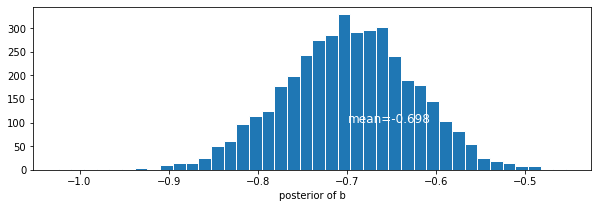

In [31]:
def plot_posterior(var_name, var_samples):
    if isinstance(var_samples, tf.Tensor):
        var_samples = var_samples.numpy()
    fig = plt.figure(figsize=(10, 3))
    ax = fig.add_subplot(111)
    ax.hist(var_samples.flatten(), bins=40, edgecolor='White')
    sample_mean = var_samples.mean()
    ax.text(sample_mean, 100, 'mean={:.3f}'.format(sample_mean), color='white', fontsize=12)
    ax.set_xlabel('posterior of ' + var_name)
    plt.show()
plot_posterior('b', varying_intercepts_samples.b)
plot_posterior('sigma_a', varying_intercepts_samples.sigma_a)

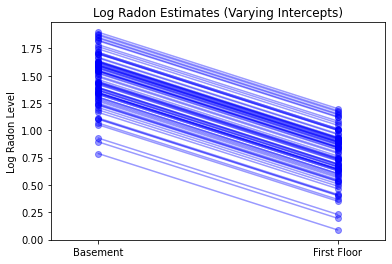

In [32]:
def plot_intercepts_and_slopes(linear_estimates, title):
    xvals = np.arange(2)
    intercepts = np.ones([num_counties]) * linear_estimates.intercept
    slopes = np.ones([num_counties]) * linear_estimates.slope
    fig, ax = plt.subplots()
    for c in range(num_counties):
        ax.plot(xvals, intercepts[c] + slopes[c] * xvals, 'bo-', alpha=0.4)
    plt.xlim(-0.2, 1.2)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Basement', 'First Floor'])
    ax.set_ylabel('Log Radon Level')
    plt.title(title)
    plt.show()
plot_intercepts_and_slopes(varying_intercepts_estimates, 'Log Radon Estimates (Varying Intercepts)')

In [33]:
def varying_slopes_model(floor, county):
    return tfd.JointDistributionSequential([
        tfd.Normal(loc=0., scale=1e5),
        tfd.HalfCauchy(loc=0., scale=5),
        tfd.Normal(loc=0., scale=1e5),
        lambda _, sigma_b, mu_b: tfd.MultivariateNormalDiag(loc=affine(tf.ones([num_counties]), mu_b[..., tf.newaxis]),
                                                           scale_identity_multiplier=sigma_b),
        tfd.HalfCauchy(loc=0., scale=5),
        lambda sigma_y, b, a: tfd.MultivariateNormalDiag(loc=affine(floor, tf.gather(b, county, axis=-1), 
                                                                    a[..., tf.newaxis]), 
                                                         scale_identity_multiplier=sigma_y)
    ])
def varying_slopes_log_prob(mu_b, sigma_b, a, b, sigma_y):
    return varying_slopes_model(floor, county).log_prob([mu_b, sigma_b, a, b, sigma_y, log_radon])

In [34]:
@tf.function
def sample_varying_slopes(num_chains, num_results, num_burnin_steps):
    hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn = varying_slopes_log_prob, num_leapfrog_steps=25, 
                                         step_size=0.01)
    initial_state = [
        tf.zeros([num_chains], name='init_mu_b'),
        tf.ones([num_chains], name="init_sigma_b"),
        tf.zeros([num_chains], name='init_a'),
        tf.zeros([num_chains, num_counties], name='init_b'),
        tf.ones([num_chains], name="init_sigma_y")
    ]
    unconstraining_bijectors = [
        tfb.Identity(),
        tfb.Exp(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Exp()
    ]
    kernel = tfp.mcmc.TransformedTransitionKernel(inner_kernel=hmc, bijector=unconstraining_bijectors)
    samples, kernel_results = tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                                                    current_state=initial_state, kernel=kernel)
    acceptance_probs = tf.reduce_mean(tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)
    return samples, acceptance_probs

In [35]:
VaryingSlopesModel = collections.namedtuple("VaryingSlopesModel", ['mu_b', 'sigma_b', 'a', 'b', 'sigma_y'])
samples, acceptance_probs = sample_varying_slopes(num_chains=4, num_results=1000, num_burnin_steps=1000)
print('Acceptance Probabilities: ', acceptance_probs.numpy())
varying_slopes_samples = VaryingSlopesModel._make(samples)

Acceptance Probabilities:  [0.975 0.975 0.98  0.989]


In [36]:
for var in ['mu_b', 'sigma_b', 'a', 'sigma_y']:
    print('R-hat for', var, '\t:', tfp.mcmc.potential_scale_reduction(getattr(varying_slopes_samples, var)).numpy())

R-hat for mu_b 	: 1.0522321
R-hat for sigma_b 	: 1.0806038
R-hat for a 	: 1.0120761
R-hat for sigma_y 	: 1.0034279


In [37]:
varying_slopes_estimates = LinearEstimates(sample_mean(varying_slopes_samples.a), sample_mean(varying_slopes_samples.b))
plot_intercepts_and_slopes(varying_slopes_estimates, 'Log Radon Estimates (Varying Slopes)')

In [56]:
def varying_intercepts_and_slopes_model(floor, county):
    return tfd.JointDistributionSequential([
        tfd.Normal(loc=0., scale=1e5),
        tfd.HalfCauchy(loc=0., scale=5),
        tfd.Normal(loc=0., scale=1e5),
        tfd.HalfCauchy(loc=0., scale=5),
        lambda sigma_b, mu_b, sigma_a, mu_a: tfd.MultivariateNormalDiag(loc=affine(tf.ones([num_counties]), 
                                                                                   mu_a[..., tf.newaxis]), 
                                                                       scale_identity_multiplier=sigma_a),
        lambda _, sigma_b, mu_b: tfd.MultivariateNormalDiag(loc=affine(tf.ones([num_counties]), mu_b[..., tf.newaxis]),
                                                           scale_identity_multiplier=sigma_b),
        tfd.HalfCauchy(loc=0., scale=5),
        lambda sigma_y, b, a: tfd.MultivariateNormalDiag(loc=affine(floor, tf.gather(b, county, axis=-1), 
                                                                    tf.gather(a, county, axis=-1)), 
                                                        scale_identity_multiplier=sigma_y)
    ])
@tf.function
def varying_intercepts_and_slopes_log_prob(mu_a, sigma_a, mu_b, sigma_b, a, b, sigma_y):
    return varying_intercepts_and_slopes_model(floor, county).log_prob([mu_a, sigma_a, mu_b, sigma_b, a, b, sigma_y, 
                                                                       log_radon])

In [57]:
@tf.function
def sample_varying_intercepts_and_slopes(num_chains, num_results, num_burnin_steps):
    hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=varying_intercepts_and_slopes_log_prob, 
                                         num_leapfrog_steps=50, step_size=0.01)
    initial_state = [
        tf.zeros([num_chains], name='init_mu_a'),
        tf.ones([num_chains], name='init_sigma_a'),
        tf.zeros([num_chains], name='init_mu_b'),
        tf.ones([num_chains], name='init_sigma_b'),
        tf.zeros([num_chains, num_counties], name='init_a'),
        tf.zeros([num_chains, num_counties], name='init_b'),
        tf.ones([num_chains], name="init_sigma_y")
    ]
    unconstraining_bijectors = [
        tfb.Identity(),
        tfb.Exp(),
        tfb.Identity(),
        tfb.Exp(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Exp()
    ]
    kernel = tfp.mcmc.TransformedTransitionKernel(inner_kernel=hmc, bijector=unconstraining_bijectors)
    samples, kernel_results =tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                                                   current_state=initial_state, kernel=kernel)
    acceptance_probs = tf.reduce_mean(tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)
    return samples, acceptance_probs

In [58]:
VaryingInterceptsAndSlopesModel = collections.namedtuple('VaryingInterceptsAndSlopesModel', ['mu_a', 'sigma_a', 'mu_b'
                                                                                            , 'sigma_b', 'a', 'b', 
                                                                                             'sigma_y'])
samples, acceptance_probs = sample_varying_intercepts_and_slopes(num_chains=4, num_results=1000, num_burnin_steps=500)
print('Acceptance Probabilities:', acceptance_probs.numpy())
varying_intercepts_and_slopes_samples = VaryingInterceptsAndSlopesModel._make(samples)

Acceptance Probabilities: [0.985 0.98  0.988 0.983]


In [60]:
for var in ['mu_a', 'sigma_a', 'mu_b', 'sigma_b']:
    print('R-hat for', var, '\t:', tfp.mcmc.potential_scale_reduction(getattr(varying_intercepts_and_slopes_samples, 
                                                                              var)).numpy())

R-hat for mu_a 	: 1.0012969
R-hat for sigma_a 	: 1.0093398
R-hat for mu_b 	: 0.99955595
R-hat for sigma_b 	: 1.0379894


In [61]:
varying_intercepts_and_slopes_estimates = LinearEstimates(sample_mean(varying_intercepts_and_slopes_samples.a), 
                                                         sample_mean(varying_intercepts_and_slopes_samples.b))
plot_intercepts_and_slopes(varying_intercepts_and_slopes_estimates, 'Log Radon Estimates (varying intercepts and slopes)')

In [76]:
def hierarchical_intercepts_model(floor, county, log_uranium):
    return tfd.JointDistributionSequential([
        tfd.HalfCauchy(loc=0., scale=5),
        lambda sigma_a: tfd.MultivariateNormalDiag(loc=tf.zeros([num_counties]), scale_identity_multiplier=sigma_a),
        tfd.Normal(loc=0., scale=1e5),
        tfd.Normal(loc=0., scale=1e5),
        tfd.Normal(loc=0., scale=1e5),
        tfd.Uniform(low=0., high=100),
        lambda sigma_y, b, gamma_1, gamma_0, eps_a: tfd.MultivariateNormalDiag(loc=affine(floor, b[..., tf.newaxis], 
                                                    affine(log_uranium, gamma_1[..., tf.newaxis], 
                                                    gamma_0[..., tf.newaxis]) + tf.gather(eps_a, county, 
                                                    axis=-1)), scale_identity_multiplier=sigma_y) 
    ])
def hierarchical_intercepts_log_prob(sigma_a, eps_a, gamma_0, gamma_1, b, sigma_y):
    return hierarchical_intercepts_model(floor, county, log_uranium).log_prob([sigma_a, eps_a, gamma_0, gamma_1, 
                                                                               b, sigma_y, log_radon])

In [77]:
@tf.function
def sample_hierarchical_intercepts(num_chains, num_results, num_burnin_steps):
    hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=hierarchical_intercepts_log_prob, num_leapfrog_steps=10, 
                                        step_size=0.01)
    initial_state = [
        tf.ones([num_chains], name='init_sigma_a'),
        tf.zeros([num_chains, num_counties], name='eps_a'),
        tf.zeros([num_chains], name='init_gamma_0'),
        tf.zeros([num_chains], name='init_gamma_1'),
        tf.zeros([num_chains], name='init_b'),
        tf.ones([num_chains], name='init_sigma_y')
    ]
    unconstraining_bijectors = [
        tfb.Exp(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Chain([
            tfb.Shift(shift=50.),
            tfb.Scale(scale=50.),
            tfb.Tanh()
        ])
    ]
    kernel = tfp.mcmc.TransformedTransitionKernel(inner_kernel=hmc, bijector=unconstraining_bijectors)
    samples, kernel_results = tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                                                   current_state=initial_state, kernel=kernel)
    acceptance_probs = tf.reduce_mean(tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)
    return samples, acceptance_probs

In [79]:
HeirarchicalInterceptsModel = collections.namedtuple('HeirarchicalInterceptsModel', ['sigma_a', 'eps_a', 'gamma_0', 
                                                                                     'gamma_1', 'b', 'sigma_y'])
samples, acceptance_probs = sample_hierarchical_intercepts(num_chains=4, num_results=2000, num_burnin_steps=500)
print("Acceptance Probabilities:", acceptance_probs.numpy())
hierarchical_intercepts_samples = HeirarchicalInterceptsModel._make(samples)

Acceptance Probabilities: [0.957  0.958  0.959  0.9585]


In [80]:
for var in ['sigma_a', 'gamma_0', 'gamma_1', 'b', 'sigma_y']:
    print('R-hat for', var, ':', tfp.mcmc.potential_scale_reduction(getattr(hierarchical_intercepts_samples, 
                                                                            var)).numpy())

R-hat for sigma_a : 1.2529398
R-hat for gamma_0 : 1.0164589
R-hat for gamma_1 : 1.0067346
R-hat for b : 1.0008733
R-hat for sigma_y : 1.0092152


In [81]:
def plot_hierarchical_intercepts():
    mean_and_var = lambda x: [reduce_samples(x, fn) for fn in [np.mean, np.var]]
    gamma_0_mean, gamma_0_var = mean_and_var(hierarchical_intercepts_samples.gamma_0)
    gamma_1_mean, gamma_1_var = mean_and_var(hierarchical_intercepts_samples.gamma_1)
    eps_a_means, eps_a_vars = mean_and_var(hierarchical_intercepts_samples.eps_a)
    mu_a_means = gamma_0_mean + gamma_1_mean * log_uranium
    mu_a_vars = gamma_0_var + np.square(log_uranium) * gamma_1_var
    a_means = mu_a_means + eps_a_means[county]
    a_stds = np.sqrt(mu_a_vars + eps_a_vars[county])
    plt.figure()
    plt.scatter(log_uranium, a_means, marker='.', c='C0')
    xvals = np.linspace(-1, 0.8)
    plt.plot(xvals, gamma_0_mean + gamma_1_mean * xvals, 'k--')
    plt.xlim(-1, 0.8)
    for ui, m, se in zip(log_uranium, a_means, a_stds):
        plt.plot([ui, ui], [m - se, m + se], 'C1-', alpha=0.1)
    plt.xlabel('County-level uranium')
    plt.ylabel('Intercepts estimate')
plot_hierarchical_intercepts()

In [82]:
xbar = tf.convert_to_tensor(radon.groupby('county')['floor'].mean(), tf.float32)
xbar = tf.gather(xbar, county, axis=-1)

In [89]:
def contextual_effects_model(floor, county, log_uranium, xbar):
    return tfd.JointDistributionSequential([
        tfd.HalfCauchy(loc=0., scale=5),
        lambda sigma_a: tfd.MultivariateNormalDiag(loc=tf.zeros([num_counties]), scale_identity_multiplier=sigma_a),
        tfd.Normal(loc=0., scale=1e5),
        tfd.Normal(loc=0., scale=1e5),
        tfd.Normal(loc=0., scale=1e5),
        tfd.Normal(loc=0., scale=1e5),
        tfd.Uniform(low=0., high=100),
        lambda sigma_y, b, gamma_2, gamma_1, gamma_0, eps_a: tfd.MultivariateNormalDiag(loc=affine(floor, 
                    b[..., tf.newaxis], affine(log_uranium, gamma_1[..., tf.newaxis], gamma_0[..., tf.newaxis]) + 
                    affine(xbar, gamma_2[..., tf.newaxis]) + tf.gather(eps_a, county, axis=-1)), 
                    scale_identity_multiplier=sigma_y)
    ])
def contextual_effects_log_prob(sigma_a, eps_a, gamma_0, gamma_1, gamma_2, b, sigma_y):
    return contextual_effects_model(floor, county, log_uranium, xbar).log_prob([
        sigma_a, eps_a, gamma_0, gamma_1, gamma_2, b, sigma_y, log_radon
    ])

In [90]:
@tf.function
def sample_contextual_effects(num_chains, num_results, num_burnin_steps):
    hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn = contextual_effects_log_prob, num_leapfrog_steps=10, 
                                         step_size=0.01)
    initial_state = [
        tf.ones([num_chains], name="init_sigma_a"),
        tf.zeros([num_chains, num_counties], name='eps_a'),
        tf.zeros([num_chains], name='init_gamma_0'),
        tf.zeros([num_chains], name='init_gamma_1'),
        tf.zeros([num_chains], name="init_gamma_2"),
        tf.zeros([num_chains], name="init_b"),
        tf.ones([num_chains], name='init_sigma_y')
    ]
    unconstraining_bijectors = [
        tfb.Exp(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Chain([
            tfb.Shift(shift=50.),
            tfb.Scale(scale=50.),
            tfb.Tanh()
        ])
    ]
    kernel = tfp.mcmc.TransformedTransitionKernel(inner_kernel=hmc, bijector=unconstraining_bijectors)
    samples, kernel_results = tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                                                    current_state=initial_state, kernel=kernel)
    acceptance_probs = tf.reduce_mean(tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)
    return samples, acceptance_probs

In [91]:
ContextualEffectsModel = collections.namedtuple('ContextualEffectsModel', ['sigma_a', 'eps_a', 'gamma_0', 'gamma_1', 
                                                                          'gamma_2', 'b', 'sigma_y'])
samples, acceptance_probs = sample_contextual_effects(num_chains = 4, num_results=2000, num_burnin_steps=500)
print("Acceptance Probabilities:", acceptance_probs.numpy())
contextual_effects_samples = ContextualEffectsModel._make(samples)

Acceptance Probabilities: [0.957 0.958 0.952 0.954]


In [92]:
for var in ['sigma_a', 'gamma_0', 'gamma_1', 'gamma_2', 'b', 'sigma_y']:
    print('R-hat for ', var, ":", tfp.mcmc.potential_scale_reduction(getattr(contextual_effects_samples, var)).numpy())

R-hat for  sigma_a : 1.1619909
R-hat for  gamma_0 : 1.017076
R-hat for  gamma_1 : 1.0006214
R-hat for  gamma_2 : 1.0099307
R-hat for  b : 1.0000373
R-hat for  sigma_y : 1.0053331


In [95]:
for var in ['gamma_0', 'gamma_1', 'gamma_2']:
    var_samples = getattr(contextual_effects_samples, var)
    mean = var_samples.numpy().mean()
    std = var_samples.numpy().std()
    r_hat = tfp.mcmc.potential_scale_reduction(var_samples).numpy()
    n_eff = tfp.mcmc.effective_sample_size(var_samples).numpy().sum()
    print(var, 'mean:', mean, 'std:', std, 'n_eff:', n_eff, 'r_hat:', r_hat)

gamma_0 mean: 1.3920869 std: 0.051093567 n_eff: 482.45282 r_hat: 1.017076
gamma_1 mean: 0.72586536 std: 0.08810956 n_eff: 1078.102 r_hat: 1.0006214
gamma_2 mean: 0.41433507 std: 0.19875862 n_eff: 461.07068 r_hat: 1.0099307


In [96]:
county_name.index('St Louis')

69

In [99]:
st_louis_log_uranium = tf.convert_to_tensor(radon.where(radon['county'] == 69)['log_uranium_ppm'].mean(), tf.float32)
st_louis_xbar = tf.convert_to_tensor(radon.where(radon['county'] == 69)['floor'].mean(), tf.float32)

In [110]:
@tf.function
def intercept_a(gamma_0, gamma_1, gamma_2, eps_a, log_uranium, xbar, county):
    return (affine(log_uranium, gamma_1, gamma_0) + affine(xbar, gamma_2) + tf.gather(eps_a, county, axis=-1))

def contextual_effects_predictive_model(floor, county, log_uranium, xbar, st_louis_uranium, st_louis_xbar):
    return tfd.JointDistributionSequential([
        tfd.HalfCauchy(loc=0., scale=5), 
        lambda sigma_a: tfd.MultivariateNormalDiag(loc=tf.zeros([num_counties]), scale_identity_multiplier=sigma_a),
        tfd.Normal(loc=0., scale=1e5),
        tfd.Normal(loc=0., scale=1e5),
        tfd.Normal(loc=0., scale=1e5),
        tfd.Normal(loc=0., scale=1e5),
        tfd.Uniform(low=0., high=100),
        lambda sigma_y, b, gamma_2, gamma_1, gamma_0, eps_a: (tfd.MultivariateNormalDiag(loc=affine(floor, 
                        b[..., tf.newaxis], intercept_a(gamma_0[..., tf.newaxis], gamma_1[..., tf.newaxis], 
                        gamma_2[..., tf.newaxis], eps_a, log_uranium, xbar, county)), 
                        scale_identity_multiplier=sigma_y)),
        lambda _, sigma_y, b, gamma_2, gamma_1, gamma_0, eps_a: tfd.Normal(loc=intercept_a(gamma_0, gamma_1, gamma_2, 
                        eps_a, st_louis_log_uranium, st_louis_xbar, 69) + b, scale=sigma_y)
    ])
@tf.function
def contextual_effects_predictive_log_prob(sigma_a, eps_a, gamma_0, gamma_1, gamma_2, b, sigma_y, stl_pred):
    return contextual_effects_predictive_model(floor, county, log_uranium, xbar, st_louis_log_uranium, 
            st_louis_xbar).log_prob([sigma_a, eps_a, gamma_0, gamma_1, gamma_2, b, sigma_y, log_radon, stl_pred])

In [111]:
@tf.function
def sample_contextual_effects_predictive(num_chains, num_results, num_burnin_steps):
    hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=contextual_effects_predictive_log_prob, 
                                         num_leapfrog_steps=50, step_size=0.01)
    initial_state = [
        tf.ones([num_chains], name='init_sigma_a'),
        tf.zeros([num_chains, num_counties], name='eps_a'),
        tf.zeros([num_chains], name='init_gamma_0'),
        tf.zeros([num_chains], name="init_gamma_1"),
        tf.zeros([num_chains], name="init_gamma_2"),
        tf.zeros([num_chains], name="init_b"),
        tf.ones([num_chains], name="init_sigma_y"),
        tf.zeros([num_chains], name='init_stl_pred')
    ]
    unconstraining_bijectors = [
        tfb.Exp(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Chain([
            tfb.Shift(shift=50.),
            tfb.Scale(scale=50.),
            tfb.Tanh()
        ]),
        tfb.Identity()
    ]
    kernel = tfp.mcmc.TransformedTransitionKernel(inner_kernel=hmc, bijector=unconstraining_bijectors)
    samples, kernel_results = tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                                                    current_state=initial_state, kernel=kernel)
    acceptance_probs = tf.reduce_mean(tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)
    return samples, acceptance_probs

In [112]:
ContextualEffectsPredictiveModel = collections.namedtuple('CountextualEffectsPredictiveModel', [
    'sigma_a', 'eps_a', 'gamma_0', 'gamma_1', 'gamma_2', 'b', 'sigma_y', 'stl_pred'
])
samples, acceptance_probs = sample_contextual_effects_predictive(num_chains=4, num_results=2000, num_burnin_steps=500)
print("Acceptance Probabilities:", acceptance_probs.numpy())
contextual_effects_pred_samples = ContextualEffectsPredictiveModel._make(samples)

Acceptance Probabilities: [0.9795 0.974  0.9615 0.98  ]


In [114]:
for var in ['sigma_a', 'gamma_0', 'gamma_1', 'gamma_2', 'b', 'sigma_y', 'stl_pred']:
    print('R-hat for', var, ":", tfp.mcmc.potential_scale_reduction(getattr(contextual_effects_pred_samples, 
                                                                            var)).numpy())

R-hat for sigma_a : 1.0342909
R-hat for gamma_0 : 0.999801
R-hat for gamma_1 : 1.0038841
R-hat for gamma_2 : 0.9997162
R-hat for b : 1.0007864
R-hat for sigma_y : 1.0414978
R-hat for stl_pred : 1.0101097


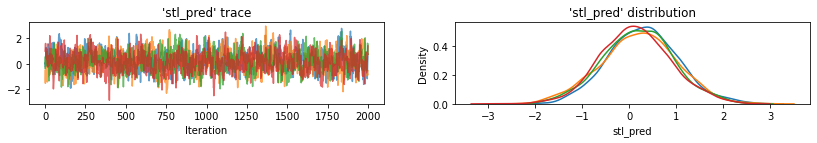

In [115]:
plot_traces('stl_pred', contextual_effects_pred_samples.stl_pred, num_chains=4)

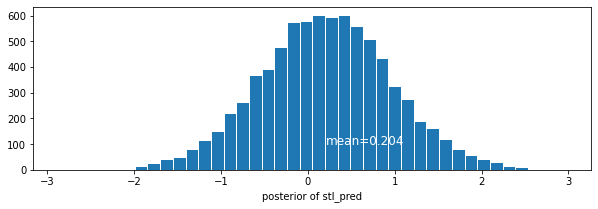

In [116]:
plot_posterior('stl_pred', contextual_effects_pred_samples.stl_pred)

# Multiple changepoint detection and Bayesian model selection

In [1]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from matplotlib import pylab as plt
%matplotlib inline
import scipy.stats

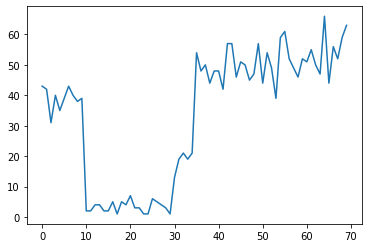

In [2]:
true_rate = [40, 3, 20, 50]
true_durations = [10, 20, 5, 35]
observed_counts = tf.concat([tfd.Poisson(rate).sample(num_steps) for (rate, num_steps) in zip(true_rate, 
                                             true_durations)], axis=0)
plt.plot(observed_counts)

In [3]:
num_states = 4
initial_state_logits = tf.zeros([num_states])
daily_change_prob = 0.05
# print(initial_state_logits)
transition_probs = tf.fill([num_states, num_states], daily_change_prob / (num_states - 1))
transition_probs = tf.linalg.set_diag(transition_probs, tf.fill([num_states], 1 - daily_change_prob))
print("Initial state logits:\n{}".format(initial_state_logits))
print("Transition matrix:\n{}".format(transition_probs))

Initial state logits:
[0. 0. 0. 0.]
Transition matrix:
[[0.95       0.01666667 0.01666667 0.01666667]
 [0.01666667 0.95       0.01666667 0.01666667]
 [0.01666667 0.01666667 0.95       0.01666667]
 [0.01666667 0.01666667 0.01666667 0.95      ]]


In [4]:
trainable_log_rates = tf.Variable(tf.math.log(tf.reduce_mean(observed_counts)) + 
                                  tf.random.stateless_normal([num_states], seed=(42, 42)), name='log_rates')
hmm = tfd.HiddenMarkovModel(initial_distribution=tfd.Categorical(logits=initial_state_logits), 
                            transition_distribution=tfd.Categorical(probs=transition_probs), observation_distribution=
                           tfd.Poisson(log_rate=trainable_log_rates), num_steps=len(observed_counts))

In [5]:
rate_prior = tfd.LogNormal(5, 5)
def log_prob():
    return (tf.reduce_sum(rate_prior.log_prob(tf.math.exp(trainable_log_rates))) + hmm.log_prob(observed_counts))

losses = tfp.math.minimize(lambda: -log_prob(), optimizer=tf.optimizers.Adam(learning_rate=0.1), num_steps=100)
plt.plot(losses)
plt.ylabel("Negative log marginal likelihood ")

Text(0, 0.5, 'Negative log marginal likelihood ')

In [6]:
rates = tf.exp(trainable_log_rates)
print("Inferred rates: {}".format(rates))
print("True rates: {}".format(true_rate))

Inferred rates: [ 3.1623192 38.69646   51.117825  18.651934 ]
True rates: [40, 3, 20, 50]


In [7]:
posterior_dists = hmm.posterior_marginals(observed_counts)
posterior_probs = posterior_dists.probs_parameter().numpy()

In [8]:
def plot_state_posterior(ax, state_posterior_probs, title):
    ln1 = ax.plot(state_posterior_probs, c='blue', lw=3, label='p(state|counts)')
    ax.set_ylim(0., 1.1)
    ax.set_ylabel('posterior probability')
    ax2 = ax.twinx()
    ln2 = ax2.plot(observed_counts, c='black')
    ax2.set_title(title)
    ax2.set_xlabel("time")
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=4)
    ax.grid(True, color='white')
    ax2.grid(False)
fig = plt.figure(figsize=(10, 10))
plot_state_posterior(fig.add_subplot(2, 2, 1), posterior_probs[:, 0], title="state 0 (rate {:.2f})".format(rates[0]))
plot_state_posterior(fig.add_subplot(2, 2, 2), posterior_probs[:, 1], title="state 1 (rate {:.2f})".format(rates[1]))
plot_state_posterior(fig.add_subplot(2, 2, 3), posterior_probs[:, 2], title="state 0 (rate {:.2f})".format(rates[2]))
plot_state_posterior(fig.add_subplot(2, 2, 4), posterior_probs[:, 3], title="state 0 (rate {:.2f})".format(rates[3]))
plt.tight_layout()

<ipython-input-8-a0b5ee8c03e5>:11: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000024CFEA3AA60> has a label of '_line0' which cannot be automatically added to the legend.
  ax.legend(lns, labs, loc=4)
<ipython-input-8-a0b5ee8c03e5>:11: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000024C9CF92040> has a label of '_line0' which cannot be automatically added to the legend.
  ax.legend(lns, labs, loc=4)
<ipython-input-8-a0b5ee8c03e5>:11: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000024C9CFEB6A0> has a label of '_line0' which cannot be automatically added to the legend.
  ax.legend(lns, labs, loc=4)
<ipython-input-8-a0b5ee8c03e5>:11: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000024C9D058DF0> has a label of '_line0' which cannot be automatically added to the legend.
  ax.legend(lns, labs, loc=4)


In [9]:
most_probable_states = hmm.posterior_mode(observed_counts)
most_probable_rates = tf.gather(rates, most_probable_states)

In [10]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(most_probable_rates, c='green', lw=3, label='inferred rate')
ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
ax.set_ylabel('latent rate')
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time")
ax.legend(loc=4)

In [19]:
max_num_states = 10

def build_latent_state(num_states, max_num_states, daily_change_prob=0.05):

  # Give probability exp(-100) ~= 0 to states outside of the current model.
  active_states_mask = tf.concat([tf.ones([num_states]),
                                  tf.zeros([max_num_states - num_states])],
                                 axis=0)
  initial_state_logits = -100. * (1 - active_states_mask)

  # Build a transition matrix that transitions only within the current
  # `num_states` states.
  transition_probs = tf.fill([num_states, num_states],
                             0. if num_states == 1
                             else daily_change_prob / (num_states - 1))  
  padded_transition_probs = tf.eye(max_num_states) + tf.pad(
      tf.linalg.set_diag(transition_probs,
                         tf.fill([num_states], - daily_change_prob)),
      paddings=[(0, max_num_states - num_states),
                (0, max_num_states - num_states)])

  return initial_state_logits, padded_transition_probs

# For each candidate model, build the initial state prior and transition matrix.
batch_initial_state_logits = []
batch_transition_probs = []
for num_states in range(1, max_num_states+1):
  initial_state_logits, transition_probs = build_latent_state(
      num_states=num_states,
      max_num_states=max_num_states)
  batch_initial_state_logits.append(initial_state_logits)
  batch_transition_probs.append(transition_probs)

batch_initial_state_logits = tf.stack(batch_initial_state_logits)
batch_transition_probs = tf.stack(batch_transition_probs)
print("Shape of initial_state_logits: {}".format(batch_initial_state_logits.shape))
print("Shape of transition probs: {}".format(batch_transition_probs.shape))
print("Example initial state logits for num_states==3:\n{}".format(batch_initial_state_logits[2, :]))
print("Example transition_probs for num_states==3:\n{}".format(batch_transition_probs[2, :, :]))

Shape of initial_state_logits: (10, 10)
Shape of transition probs: (10, 10, 10)
Example initial state logits for num_states==3:
[  -0.   -0.   -0. -100. -100. -100. -100. -100. -100. -100.]
Example transition_probs for num_states==3:
[[0.95  0.025 0.025 0.    0.    0.    0.    0.    0.    0.   ]
 [0.025 0.95  0.025 0.    0.    0.    0.    0.    0.    0.   ]
 [0.025 0.025 0.95  0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    1.   ]]


In [22]:
trainable_log_rates = tf.Variable(
    tf.fill([batch_initial_state_logits.shape[0], max_num_states],
            tf.math.log(tf.reduce_mean(observed_counts))) + 
     tf.random.stateless_normal([1, max_num_states], seed=(42, 42)),
     name='log_rates')

hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=batch_initial_state_logits),
  transition_distribution=tfd.Categorical(probs=batch_transition_probs),
  observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
  num_steps=len(observed_counts))
print("Defined HMM with batch shape: {}".format(hmm.batch_shape))

Defined HMM with batch shape: (10,)


In [23]:
rate_prior = tfd.LogNormal(5, 5)

def log_prob():
  prior_lps = rate_prior.log_prob(tf.math.exp(trainable_log_rates))
  prior_lp = tf.stack(
      [tf.reduce_sum(prior_lps[i, :i+1]) for i in range(max_num_states)])
  return prior_lp + hmm.log_prob(observed_counts)

Text(0, 0.5, 'Negative log marginal likelihood')

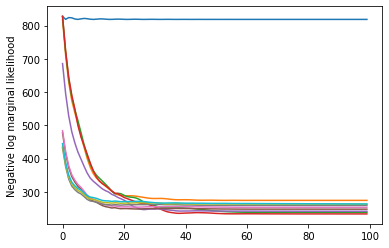

In [24]:
losses = tfp.math.minimize(
    lambda: -log_prob(),
    optimizer=tf.optimizers.Adam(0.1),
    num_steps=100)
plt.plot(losses)
plt.ylabel('Negative log marginal likelihood')

Text(0.5, 1.0, 'Model selection on latent states')

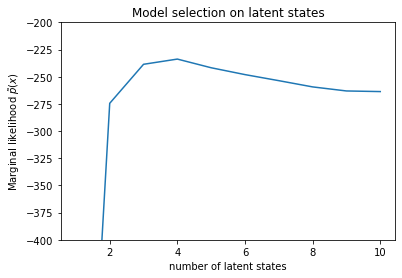

In [25]:
num_states = np.arange(1, max_num_states + 1)
plt.plot(num_states, -losses[-1])
plt.ylim([-400, -200])
plt.ylabel("Marginal likelihood $\\tilde{p}(x)$")
plt.xlabel("number of latent states")
plt.title("Model selection on latent states")

In [26]:
rates = tf.exp(trainable_log_rates)
for i, learned_model_rates in enumerate(rates):
    print("rates for {}-state model: {}".format(i + 1, learned_model_rates[:i + 1]))

rates for 1-state model: [33.42581]
rates for 2-state model: [ 3.6405973 46.11319  ]
rates for 3-state model: [ 3.176278 18.424934 48.44772 ]
rates for 4-state model: [ 3.1623192 38.69646   51.117825  18.651934 ]
rates for 5-state model: [18.434935  79.60889   51.191284  39.02938    3.1974027]
rates for 6-state model: [38.893177  80.81397   51.0748    51.178005  18.429653   3.1976542]
rates for 7-state model: [38.905205  81.6897    51.133415  51.16379   18.229212   3.1989014
 18.240147 ]
rates for 8-state model: [38.906864  82.365974  51.187523  51.12738   18.061888  18.038132
 18.052834   3.1878827]
rates for 9-state model: [38.903442  82.91031   51.073627  51.14705    3.1736586 18.058655
 18.033772   3.1956837 18.059258 ]
rates for 10-state model: [38.89605    83.36287    51.15723    51.172516    3.1874528  18.241737
  3.1559918   2.1502805  18.24227     0.14354205]


In [27]:
most_probable_states = hmm.posterior_mode(observed_counts)

In [28]:
fig = plt.figure(figsize=(14, 12))
for i, learned_model_rates in enumerate(rates):
    ax = fig.add_subplot(4, 3, i + 1)
    ax.plot(tf.gather(learned_model_rates, most_probable_states[i]), c='green', lw=3, label="inferred rate")
    ax.plot(observed_counts, c="black", alpha=0.3, label="observed counts")
    ax.set_ylabel("latent rate")
    ax.set_xlabel("time")
    ax.set_title("{}-state model".format(i + 1))
    ax.legend(loc=4)
plt.tight_layout()

# TFP Probabilistic Layers Variational Auto Encoder

In [29]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

In [30]:
datasets, datasets_info = tfds.load(name="mnist", with_info=True, as_supervised=False)
def _preprocess(sample):
    image = tf.cast(sample['image'], tf.float32) / 255.
    image = image < tf.random.uniform(tf.shape(image))
    return image, image

In [33]:
train_dataset = (datasets['train'].map(_preprocess).batch(256).prefetch(tf.data.AUTOTUNE).shuffle(int(10e3)))
eval_dataset = (datasets['test'].map(_preprocess).batch(256).prefetch(tf.data.AUTOTUNE))

In [34]:
input_shape = datasets_info.features['image'].shape
encoded_size = 16
base_depth = 32

In [35]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1), reinterpreted_batch_ndims=1)

In [36]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Conv2D(base_depth, 5, strides=1, padding="same", activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2, padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1, padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2, padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * base_depth, 7, strides=1, padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size), activation=None),
    tfpl.MultivariateNormalTriL(encoded_size, activity_regularizer=tfpl.KLDivergenceRegularizer(prior))
])

In [37]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1, padding="valid", activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1, padding="same", activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2, padding="same", activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1, padding="same", activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2, padding="same", activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1, padding="same", activation=tf.nn.leaky_relu),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1, padding='same', activation=None),
    tfkl.Flatten(),
    tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits)
])

In [38]:
vae = tfk.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]))

In [39]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)
vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=negloglik)
_ = vae.fit(train_dataset, epochs=15, validation_data=eval_dataset)

Epoch 1/15
235/235 [==============================] - 1002s 4s/step - loss: 214.4485 - val_loss: 158.9642
Epoch 2/15
235/235 [==============================] - 1001s 4s/step - loss: 150.5278 - val_loss: 143.1503
Epoch 3/15
235/235 [==============================] - 1000s 4s/step - loss: 139.3649 - val_loss: 135.0708
Epoch 4/15
235/235 [==============================] - 897s 4s/step - loss: 131.6606 - val_loss: 129.1729
Epoch 5/15
235/235 [==============================] - 763s 3s/step - loss: 127.0838 - val_loss: 125.1348
Epoch 6/15
235/235 [==============================] - 761s 3s/step - loss: 123.4342 - val_loss: 121.8786
Epoch 7/15
235/235 [==============================] - 764s 3s/step - loss: 121.6678 - val_loss: 121.3515
Epoch 8/15
235/235 [==============================] - 763s 3s/step - loss: 120.1647 - val_loss: 119.0400
Epoch 9/15
235/235 [==============================] - 763s 3s/step - loss: 119.1496 - val_loss: 118.3457
Epoch 10/15
235/235 [==============================]

In [41]:
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

In [45]:
import matplotlib.pyplot as plt
def display_imgs(x, y=None):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = np.array(x)
    plt.ioff()
    n = x.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n, 1))
    if y is not None:
        fig.suptitle(np.argmax(y, axis=1))
    for i in range(n):
        axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
        axs.flat[i].axis('off')
    plt.show()
    plt.close()
    plt.ion()

Originals:


Decoded Random Samples:


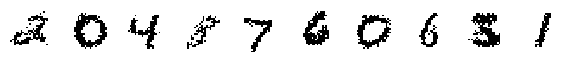

Decode Modes:


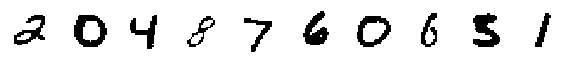

Decoded Means:


In [46]:
print("Originals:")
display_imgs(x)
print('Decoded Random Samples:')
display_imgs(xhat.sample())
print('Decode Modes:')
display_imgs(xhat.mode())
print("Decoded Means:")
display_imgs(xhat.mean())

In [47]:
z = prior.sample(10)
xtilde = decoder(z)
assert isinstance(xtilde, tfd.Distribution)

Randomly Generated Samples:


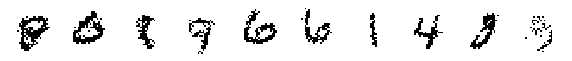

Randomly Generated Modes:


Randomly Generated Means:


In [48]:
print("Randomly Generated Samples:")
display_imgs(xtilde.sample())
print("Randomly Generated Modes:")
display_imgs(xtilde.mode())
print('Randomly Generated Means:')
display_imgs(xtilde.mean())

# Probabilistic PCA

In [1]:
import functools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
tf.enable_v2_behavior()
plt.style.use("ggplot")
warnings.filterwarnings('ignore')

In [11]:
def probabilistic_pca(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    w = yield tfd.Normal(loc=tf.zeros([data_dim, latent_dim]), scale=2.0 * tf.ones([data_dim, latent_dim]), name="w")
    z = yield tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]), scale=tf.ones([latent_dim, num_datapoints]), name="z")
    x = yield tfd.Normal(loc=tf.matmul(w, z), scale=stddv_datapoints, name="x")

In [12]:
num_datapoints = 5000
data_dim = 2
latent_dim = 1
stddv_datapoints = 0.5
concrete_ppca_model = functools.partial(probabilistic_pca, data_dim=data_dim, latent_dim=latent_dim, stddv_datapoints=
                                       stddv_datapoints, num_datapoints=num_datapoints)
model = tfd.JointDistributionCoroutineAutoBatched(concrete_ppca_model)

In [13]:
actual_w, actual_z, x_train = model.sample()
print("Principl axes:")
print(actual_w)

Principl axes:
tf.Tensor(
[[ 1.5667765]
 [-0.5057684]], shape=(2, 1), dtype=float32)


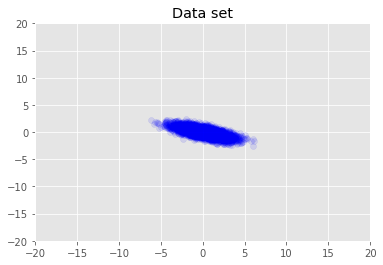

In [14]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis([-20, 20, -20, 20])
plt.title("Data set")
plt.show()

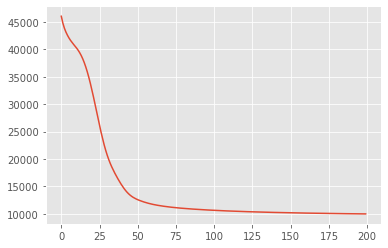

In [16]:
w = tf.Variable(tf.random.normal([data_dim, latent_dim]))
z = tf.Variable(tf.random.normal([latent_dim, num_datapoints]))
target_log_prob_fn = lambda w, z: model.log_prob((w, z, x_train))
losses = tfp.math.minimize(lambda: -target_log_prob_fn(w, z), optimizer=tf.optimizers.Adam(learning_rate=0.05), 
                           num_steps=200)
plt.plot(losses)

MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[-3.309008 ],
       [ 1.0796204]], dtype=float32)>


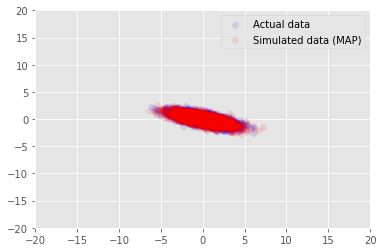

In [17]:
print("MAP-estimated axes:")
print(w)
_, _, x_generated = model.sample(value=(w, z, None))
plt.scatter(x_train[0, :], x_train[1, :], color="blue", alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()

In [20]:
qw_mean = tf.Variable(tf.random.normal([data_dim, latent_dim]))
qz_mean = tf.Variable(tf.random.normal([latent_dim, num_datapoints]))
qw_stddv = tfp.util.TransformedVariable(1e-4 * tf.ones([data_dim, latent_dim]), bijector=tfb.Softplus())
qz_stddv = tfp.util.TransformedVariable(1e-4 * tf.ones([latent_dim, num_datapoints]), bijector=tfb.Softplus())
def factored_normal_variational_model():
    qw = yield tfd.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
    qz = yield tfd.Normal(loc=qz_mean, scale=qz_stddv, name="qz")
surrogate_posterior = tfd.JointDistributionCoroutineAutoBatched(factored_normal_variational_model)
losses = tfp.vi.fit_surrogate_posterior(target_log_prob_fn, surrogate_posterior=surrogate_posterior, 
                                       optimizer=tf.optimizers.Adam(learning_rate=0.05), num_steps=200)

Inferred axes:
<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.9547348],
       [-0.6325362]], dtype=float32)>
Standard Deviation
<TransformedVariable: name=softplus, dtype=float32, shape=[2, 1], fn="softplus", numpy=
array([[0.01558712],
       [0.00858284]], dtype=float32)>


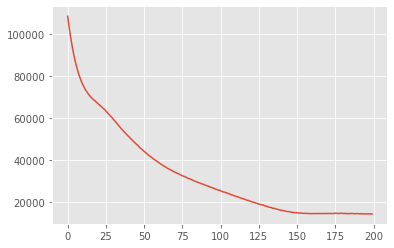

In [21]:
print("Inferred axes:")
print(qw_mean)
print("Standard Deviation")
print(qw_stddv)
plt.plot(losses)
plt.show()

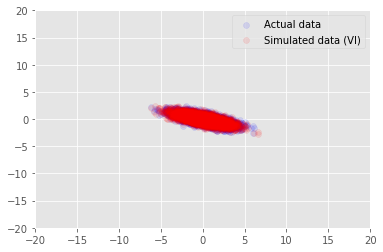

In [22]:
posterior_samples = surrogate_posterior.sample(50)
_, _, x_generated = model.sample(value=(posterior_samples))
x_generated = tf.reshape(tf.transpose(x_generated, [1, 0, 2]), (2, -1))[:, ::47]
plt.scatter(x_train[0, :], x_train[1, :], color="blue", alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color="red", alpha=0.1, label='Simulated data (VI)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()

# Approximate inference for STS models with non-gaussian observations

In [37]:
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
tf.enable_v2_behavior()

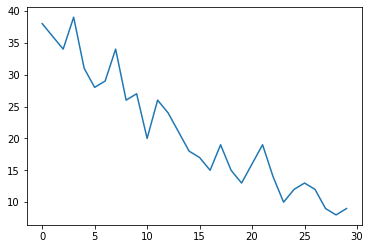

In [38]:
num_timesteps = 30
observed_counts = np.round(3 + np.random.lognormal(np.log(np.linspace(num_timesteps, 5, num=num_timesteps)), 
                                                   0.20, size=num_timesteps))
observed_counts = observed_counts.astype(np.float32)
plt.plot(observed_counts)

In [39]:
def build_model(approximate_unconstrained_rates):
    trend = tfp.sts.LocalLinearTrend(observed_time_series=approximate_unconstrained_rates)
    return tfp.sts.Sum([trend], observed_time_series=approximate_unconstrained_rates)

In [40]:
positive_bijector = tfb.Softplus()
approximate_unconstrained_rates = positive_bijector.inverse(tf.convert_to_tensor(observed_counts) + 0.01)
sts_model = build_model(approximate_unconstrained_rates)

In [41]:
def sts_with_poisson_likelihood_model():
    param_vals = []
    for param in sts_model.parameters:
        param_val = yield param.prior
        param_vals.append(param_val)
    unconstrained_rate = yield sts_model.make_state_space_model(num_timesteps, param_vals)
    rate = positive_bijector.forward(unconstrained_rate[..., 0])
    observed_counts = yield tfd.Poisson(rate, name='observed_counts')
model = tfd.JointDistributionCoroutineAutoBatched(sts_with_poisson_likelihood_model)

In [42]:
pinned_model = model.experimental_pin(observed_counts=observed_counts)

In [43]:
constraining_bijector = pinned_model.experimental_default_event_space_bijector()

In [44]:
num_results = 500
num_results = int(num_results)
num_burnin_steps = 100
num_burnin_steps = int(num_burnin_steps)

In [45]:
sampler = tfp.mcmc.TransformedTransitionKernel(tfp.mcmc.NoUTurnSampler(target_log_prob_fn = 
                                                                  pinned_model.unnormalized_log_prob, step_size=0.1), 
                                               bijector=constraining_bijector)
adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=sampler, 
                            num_adaptation_steps=int(0.8 * num_burnin_steps), target_accept_prob=0.75)
initial_state = constraining_bijector.forward(type(pinned_model.event_shape)(*(tf.random.normal(part_shape) 
                            for part_shape in constraining_bijector.inverse_event_shape(pinned_model.event_shape))))

In [46]:
@tf.function(autograph=False, jit_compile=True)
def do_sampling():
    return tfp.mcmc.sample_chain(kernel=adaptive_sampler, current_state=initial_state, num_results=num_results, 
                                num_burnin_steps=num_burnin_steps, trace_fn=None)
t0 = time.time()
samples = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

Inference ran in 29.71s.


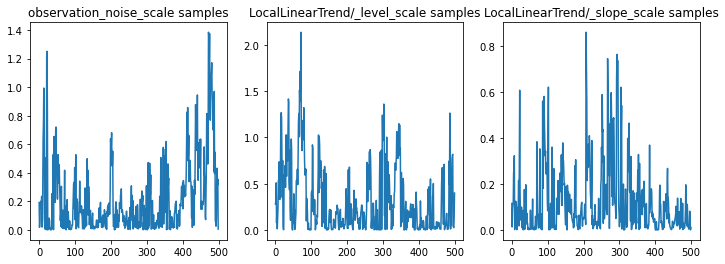

In [47]:
f = plt.figure(figsize=(12, 4))
for i, param in enumerate(sts_model.parameters):
    ax = f.add_subplot(1, len(sts_model.parameters), i + 1)
    ax.plot(samples[i])
    ax.set_title("{} samples".format(param.name))

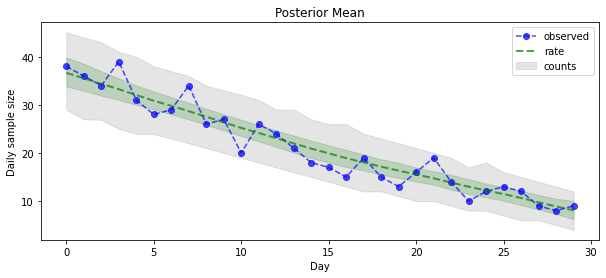

In [48]:
param_samples = samples[:-1]
unconstrained_rate_samples = samples[-1][..., 0]
rate_samples = positive_bijector.forward(unconstrained_rate_samples)
plt.figure(figsize=(10, 4))
mean_lower, mean_upper = np.percentile(rate_samples, [10, 90], axis=0)
pred_lower, pred_upper = np.percentile(np.random.poisson(rate_samples), [10, 90], axis=0)
_ = plt.plot(observed_counts, color="blue", ls='--', marker='o', label='observed', alpha=0.7)
_ = plt.plot(np.mean(rate_samples, axis=0), label='rate', color="green", ls='dashed', lw=2, alpha=0.7)
_ = plt.fill_between(np.arange(0, 30), mean_lower, mean_upper, color="green", alpha=0.2)
_ = plt.fill_between(np.arange(0, 30), pred_lower, pred_upper, color='grey', label="counts", alpha=0.2)
plt.xlabel("Day")
plt.ylabel("Daily sample size")
plt.title("Posterior Mean")
plt.legend()

In [49]:
def sample_forecasted_counts(sts_model, posterior_latent_rates,
                             posterior_params, num_steps_forecast,
                             num_sampled_forecasts):

  # Forecast the future latent unconstrained rates, given the inferred latent
  # unconstrained rates and parameters.
  unconstrained_rates_forecast_dist = tfp.sts.forecast(sts_model,
    observed_time_series=unconstrained_rate_samples,
    parameter_samples=posterior_params,
    num_steps_forecast=num_steps_forecast)

  # Transform the forecast to positive-valued Poisson rates.
  rates_forecast_dist = tfd.TransformedDistribution(
      unconstrained_rates_forecast_dist,
      positive_bijector)

  # Sample from the forecast model following the chain rule:
  # P(counts) = P(counts | latent_rates)P(latent_rates)
  sampled_latent_rates = rates_forecast_dist.sample(num_sampled_forecasts)
  sampled_forecast_counts = tfd.Poisson(rate=sampled_latent_rates).sample()

  return sampled_forecast_counts, sampled_latent_rates

forecast_samples, rate_samples = sample_forecasted_counts(
   sts_model,
   posterior_latent_rates=unconstrained_rate_samples,
   posterior_params=param_samples,
   # Days to forecast:
   num_steps_forecast=30,
   num_sampled_forecasts=100)

In [50]:
forecast_samples, rate_samples = sample_forecasted_counts(sts_model, posterior_latent_rates=unconstrained_rate_samples,
                                                         posterior_params=param_samples, num_steps_forecast=30, 
                                                         num_sampled_forecasts=100)

In [51]:
forecast_samples = np.squeeze(forecast_samples)

In [52]:
def plot_forecast_helper(data, forecast_samples, CI = 90):
    plt.figure(figsize=(10, 4))
    forecast_median = np.median(forecast_samples, axis=0)
    num_steps = len(data)
    num_steps_forecast = forecast_median.shape[-1]
    plt.plot(np.arange(num_steps), data, lw=2, color='blue', linestyle='--', marker='o', label='Observed Data', 
             alpha=0.7)
    forecast_steps = np.arange(num_steps, num_steps + num_steps_forecast)
    CI_interval = [(100 - CI) / 2, 100 - (100 - CI) / 2]
    lower, upper = np.percentile(forecast_samples, CI_interval, axis=0)
    plt.plot(forecast_steps, forecast_median, lw=2, ls='--', marker='o', color='orange', 
             label=str(CI) + "% Forecast Interval", alpha=0.7)
    plt.fill_between(forecast_steps, lower, upper, color='orange', alpha=0.2)
    plt.xlim([0, num_steps + num_steps_forecast])
    ymin, ymax = min(np.min(forecast_samples), np.min(data)), max(np.max(forecast_samples), np.max(data))
    yrange = ymax - ymin
    plt.title("{}".format("Observed time series with" + str(num_steps_forecast) + 'Day Forecast'))
    plt.xlabel('Day')
    plt.ylabel('Daily Sample Size')
    plt.legend()

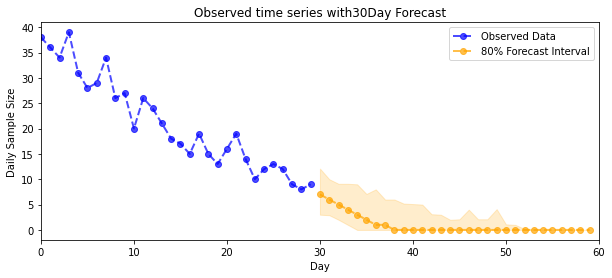

In [53]:
plot_forecast_helper(observed_counts, forecast_samples, CI=80)

In [54]:
surrogate_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(event_shape=pinned_model.event_shape, 
                                                                            bijector=constraining_bijector)

In [55]:
num_variational_steps = 1000
num_variational_steps = int(num_variational_steps)
t0 = time.time()
losses = tfp.vi.fit_surrogate_posterior(pinned_model.unnormalized_log_prob, surrogate_posterior, 
                                        optimizer=tf.optimizers.Adam(0.1), num_steps=num_variational_steps)
t1 = time.time()
print("Inference ran in {:.2f}s".format(t1 - t0))

Inference ran in 29.53s


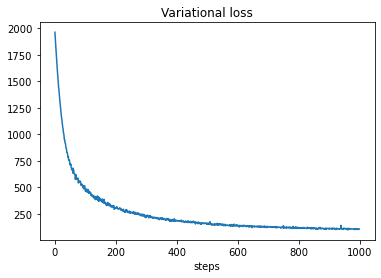

In [56]:
plt.plot(losses)
plt.title("Variational loss")
_ = plt.xlabel("steps")

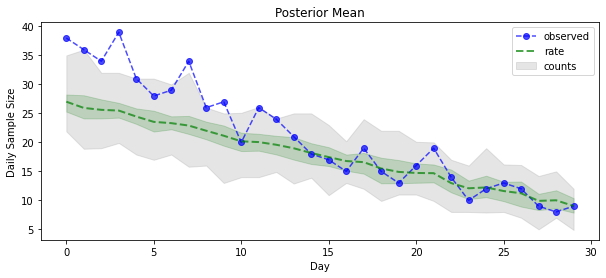

In [57]:
posterior_samples = surrogate_posterior.sample(50)
param_sample = posterior_samples[:-1]
unconstrained_rate_samples = posterior_samples[-1][..., 0]
rate_samples = positive_bijector.forward(unconstrained_rate_samples)
plt.figure(figsize=(10, 4))
mean_lower, mean_upper = np.percentile(rate_samples, [10, 90], axis=0)
pred_lower, pred_upper = np.percentile(np.random.poisson(rate_samples), [10, 90], axis=0)
_ = plt.plot(observed_counts, color="blue", ls="--", marker='o', label='observed', alpha=0.7)
_ = plt.plot(np.mean(rate_samples, axis=0), label="rate", color='green', ls='dashed', lw=2, alpha=0.7)
_ = plt.fill_between(np.arange(0, 30), mean_lower, mean_upper, color="green", alpha=0.2)
_ = plt.fill_between(np.arange(0, 30), pred_lower, pred_upper, color='grey', label='counts', alpha=0.2)
plt.xlabel('Day')
plt.ylabel('Daily Sample Size')
plt.title('Posterior Mean')
plt.legend()

# Structural Time Series Modeling Case Studies Atmospheric CO2 and Electricity Demand

In [61]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import collections
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts
tf.enable_v2_behavior()

In [62]:
if tf.test.gpu_device_name() != "/device:GPU:0":
    print('WARNING: GPU device not found.')
else:
    print("SUCCESS: Found GPU: {}".format(tf.test.gpu_device_name()))

In [63]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [87]:
def plot_forecast(x, y, forecast_mean, forecast_scale, forecast_samples, title, x_locator=None, x_formatter=None):
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    num_steps = len(y)
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast
    ax.plot(x, y, lw=2, color=c1, label='ground truth')
    forecast_steps = np.arange(x[num_steps_train], x[num_steps_train] + num_steps_forecast, dtype=x.dtype)
    ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)
    ax.plot(forecast_steps, forecast_mean, lw = 2, ls='--', color=c2, label='forecast')
    ax.fill_between(forecast_steps, forecast_mean - 2 * forecast_scale, forecast_mean + 2 * forecast_scale, color=c2, 
                    alpha=0.2)
    ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
    yrange = ymax - ymin
    ax.set_ylim([ymin - yrange * 0.1, ymax + yrange * 0.1])
    ax.set_title("{}".format(title))
    ax.legend()
    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()
    return fig, ax

In [95]:
def plot_components(dates, component_means_dict, component_stddevs_dict, x_locator=None, x_formatter=None):
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    axes_dict = collections.OrderedDict()
    num_components = len(component_means_dict)
    fig = plt.figure(figsize=(12, 2.5 * num_components))
    for i, component_name in enumerate(component_means_dict.keys()):
        component_mean = component_means_dict[component_name]
        component_stddev = component_stddevs_dict[component_name]
        ax = fig.add_subplot(num_components, 1, 1 + i)
        ax.plot(dates, component_mean, lw = 2)
        ax.fill_between(dates, component_mean - 2 * component_stddev, component_mean + 2 * component_stddev, color=c2, 
                       alpha=0.5)
        ax.set_title(component_name)
        if x_locator is not None:
            ax.xaxis.set_major_locator(x_locator)
            ax.xaxis.set_major_formatter(x_formatter)
        axes_dict[component_name] = ax
    fig.autofmt_xdate()
    fig.tight_layout()
    return fig, axes_dict

In [131]:
def plot_one_step_predictive(dates, observed_time_series, one_step_mean, one_step_scale, x_locator=None, 
                             x_formatter=None):
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    num_timesteps = one_step_mean.shape[-1]
    ax.plot(dates, observed_time_series, label="observed time series", color=c1)
    ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
    ax.fill_between(dates, one_step_mean - one_step_scale, one_step_mean + one_step_scale, alpha=0.1, color=c2)
    ax.legend()
    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()
    fig.tight_layout()
    return fig, ax

In [67]:
# CO2 readings from Mauna Loa observatory, monthly beginning January 1966
# Original source: http://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record
co2_by_month = np.array('320.62,321.60,322.39,323.70,324.08,323.75,322.38,320.36,318.64,318.10,319.78,321.03,322.33,322.50,323.04,324.42,325.00,324.09,322.54,320.92,319.25,319.39,320.73,321.96,322.57,323.15,323.89,325.02,325.57,325.36,324.14,322.11,320.33,320.25,321.32,322.89,324.00,324.42,325.63,326.66,327.38,326.71,325.88,323.66,322.38,321.78,322.85,324.12,325.06,325.98,326.93,328.14,328.08,327.67,326.34,324.69,323.10,323.06,324.01,325.13,326.17,326.68,327.17,327.79,328.92,328.57,327.36,325.43,323.36,323.56,324.80,326.01,326.77,327.63,327.75,329.73,330.07,329.09,328.04,326.32,324.84,325.20,326.50,327.55,328.55,329.56,330.30,331.50,332.48,332.07,330.87,329.31,327.51,327.18,328.16,328.64,329.35,330.71,331.48,332.65,333.09,332.25,331.18,329.39,327.43,327.37,328.46,329.57,330.40,331.40,332.04,333.31,333.97,333.60,331.90,330.06,328.56,328.34,329.49,330.76,331.75,332.56,333.50,334.58,334.88,334.33,333.05,330.94,329.30,328.94,330.31,331.68,332.93,333.42,334.70,336.07,336.75,336.27,334.92,332.75,331.59,331.16,332.40,333.85,334.97,335.38,336.64,337.76,338.01,337.89,336.54,334.68,332.76,332.55,333.92,334.95,336.23,336.76,337.96,338.88,339.47,339.29,337.73,336.09,333.92,333.86,335.29,336.73,338.01,338.36,340.07,340.77,341.47,341.17,339.56,337.60,335.88,336.02,337.10,338.21,339.24,340.48,341.38,342.51,342.91,342.25,340.49,338.43,336.69,336.86,338.36,339.61,340.75,341.61,342.70,343.57,344.14,343.35,342.06,339.81,337.98,337.86,339.26,340.49,341.38,342.52,343.10,344.94,345.76,345.32,343.98,342.38,339.87,339.99,341.15,342.99,343.70,344.50,345.28,347.06,347.43,346.80,345.39,343.28,341.07,341.35,342.98,344.22,344.97,345.99,347.42,348.35,348.93,348.25,346.56,344.67,343.09,342.80,344.24,345.56,346.30,346.95,347.85,349.55,350.21,349.55,347.94,345.90,344.85,344.17,345.66,346.90,348.02,348.48,349.42,350.99,351.85,351.26,349.51,348.10,346.45,346.36,347.81,348.96,350.43,351.73,352.22,353.59,354.22,353.79,352.38,350.43,348.73,348.88,350.07,351.34,352.76,353.07,353.68,355.42,355.67,355.12,353.90,351.67,349.80,349.99,351.30,352.52,353.66,354.70,355.38,356.20,357.16,356.23,354.81,352.91,350.96,351.18,352.83,354.21,354.72,355.75,357.16,358.60,359.34,358.24,356.17,354.02,352.15,352.21,353.75,354.99,355.99,356.72,357.81,359.15,359.66,359.25,357.02,355.00,353.01,353.31,354.16,355.40,356.70,357.17,358.38,359.46,360.28,359.60,357.57,355.52,353.69,353.99,355.34,356.80,358.37,358.91,359.97,361.26,361.69,360.94,359.55,357.48,355.84,356.00,357.58,359.04,359.97,361.00,361.64,363.45,363.80,363.26,361.89,359.45,358.05,357.75,359.56,360.70,362.05,363.24,364.02,364.71,365.41,364.97,363.65,361.48,359.45,359.61,360.76,362.33,363.18,363.99,364.56,366.36,366.80,365.63,364.47,362.50,360.19,360.78,362.43,364.28,365.33,366.15,367.31,368.61,369.30,368.88,367.64,365.78,363.90,364.23,365.46,366.97,368.15,368.87,369.59,371.14,371.00,370.35,369.27,366.93,364.64,365.13,366.68,368.00,369.14,369.46,370.51,371.66,371.83,371.69,370.12,368.12,366.62,366.73,368.29,369.53,370.28,371.50,372.12,372.86,374.02,373.31,371.62,369.55,367.96,368.09,369.68,371.24,372.44,373.08,373.52,374.85,375.55,375.40,374.02,371.48,370.70,370.25,372.08,373.78,374.68,375.62,376.11,377.65,378.35,378.13,376.61,374.48,372.98,373.00,374.35,375.69,376.79,377.36,378.39,380.50,380.62,379.55,377.76,375.83,374.05,374.22,375.84,377.44,378.34,379.61,380.08,382.05,382.24,382.08,380.67,378.67,376.42,376.80,378.31,379.96,381.37,382.02,382.56,384.37,384.92,384.03,382.28,380.48,378.81,379.06,380.14,381.66,382.58,383.71,384.34,386.23,386.41,385.87,384.45,381.84,380.86,380.86,382.36,383.61,385.07,385.84,385.83,386.77,388.51,388.05,386.25,384.08,383.09,382.78,384.01,385.11,386.65,387.12,388.52,389.57,390.16,389.62,388.07,386.08,384.65,384.33,386.05,387.49,388.55,390.07,391.01,392.38,393.22,392.24,390.33,388.52,386.84,387.16,388.67,389.81,391.30,391.92,392.45,393.37,394.28,393.69,392.59,390.21,389.00,388.93,390.24,391.80,393.07,393.35,394.36,396.43,396.87,395.88,394.52,392.54,391.13,391.01,392.95,394.34,395.61,396.85,397.26,398.35,399.98,398.87,397.37,395.41,393.39,393.70,395.19,396.82,397.92,398.10,399.47,401.33,401.88,401.31,399.07,397.21,395.40,395.65,397.23,398.79,399.85,400.31,401.51,403.45,404.10,402.88,401.61,399.00,397.50,398.28,400.24,401.89,402.65,404.16,404.85,407.57,407.66,407.00,404.50,402.24,401.01,401.50,403.64,404.55,406.07,406.64,407.06,408.95,409.91,409.12,407.20,405.24,403.27,403.64,405.17,406.75,408.05,408.34,409.25,410.30,411.30,410.88,408.90,407.10,405.59,405.99,408.12,409.23,410.92'.split(',')).astype(np.float32)

co2_by_month = co2_by_month
num_forecast_steps = 12 * 10 # Forecast the final ten years, given previous data
co2_by_month_training_data = co2_by_month[:-num_forecast_steps]

co2_dates = np.arange("1966-01", "2019-02", dtype="datetime64[M]")
co2_loc = mdates.YearLocator(3)
co2_fmt = mdates.DateFormatter('%Y')

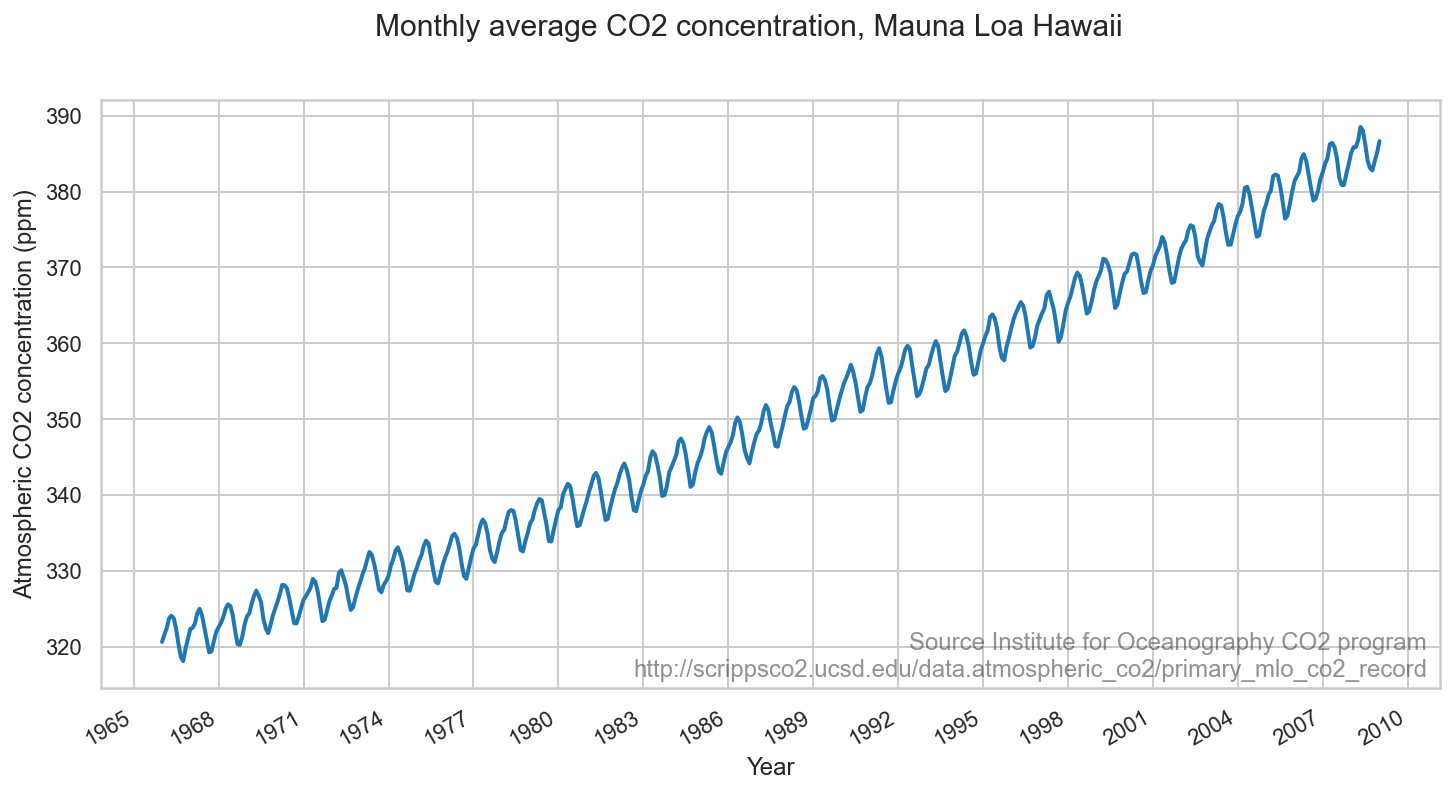

In [68]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(co2_dates[:-num_forecast_steps], co2_by_month_training_data, lw=2, label="training data")
ax.xaxis.set_major_locator(co2_loc)
ax.xaxis.set_major_formatter(co2_fmt)
ax.set_ylabel("Atmospheric CO2 concentration (ppm)")
ax.set_xlabel("Year")
fig.suptitle("Monthly average CO2 concentration, Mauna Loa Hawaii", fontsize=15)
ax.text(0.99, .02, "Source Institute for Oceanography CO2 program\nhttp://scrippsco2.ucsd.edu/data.atmospheric_co2/primary_mlo_co2_record",
       transform=ax.transAxes, horizontalalignment="right", alpha=0.5)
fig.autofmt_xdate()

In [75]:
def build_model(observed_time_series):
  trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
  seasonal = tfp.sts.Seasonal(
      num_seasons=12, observed_time_series=observed_time_series)
  model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
  return model

In [76]:
co2_model = build_model(co2_by_month_training_data)

# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=co2_model)

In [77]:
num_variational_steps = 200
num_variational_steps = int(num_variational_steps)
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(target_log_prob_fn=co2_model.joint_distribution(observed_time_series=
                                co2_by_month_training_data).log_prob, surrogate_posterior=variational_posteriors, 
                                optimizer=tf.optimizers.Adam(learning_rate=0.1), num_steps=num_variational_steps, 
                                                jit_compile=True)

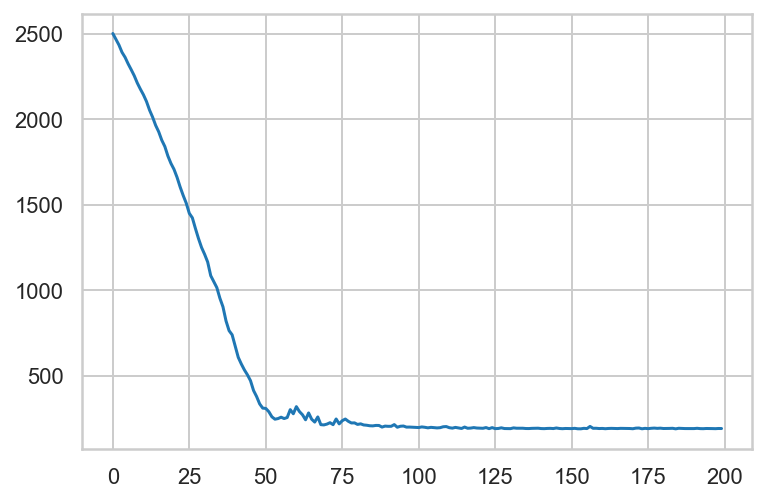

In [78]:
plt.plot(elbo_loss_curve)
plt.show()
q_samples_co2_ = variational_posteriors.sample(50)

In [79]:
print("Inferred parameters:")
for param in co2_model.parameters:
    print("{}: {} +- {}".format(param.name, np.mean(q_samples_co2_[param.name], axis=0), 
                                np.std(q_samples_co2_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 0.1563609391450882 +- 0.00849510170519352
LocalLinearTrend/_level_scale: 0.17657171189785004 +- 0.012072852812707424
LocalLinearTrend/_slope_scale: 0.002981564961373806 +- 0.0017011376330628991
Seasonal/_drift_scale: 0.03767119348049164 +- 0.005696753039956093


In [81]:
co2_forecast_dist = tfp.sts.forecast(co2_model, observed_time_series=co2_by_month_training_data, 
                                     parameter_samples=q_samples_co2_, num_steps_forecast=num_forecast_steps)

In [82]:
num_samples = 10
co2_forecast_mean, co2_forecast_scale, co2_forecast_samples = (co2_forecast_dist.mean().numpy()[..., 0], 
                                                              co2_forecast_dist.stddev().numpy()[..., 0], 
                                                              co2_forecast_dist.sample(num_samples).numpy()[..., 0])

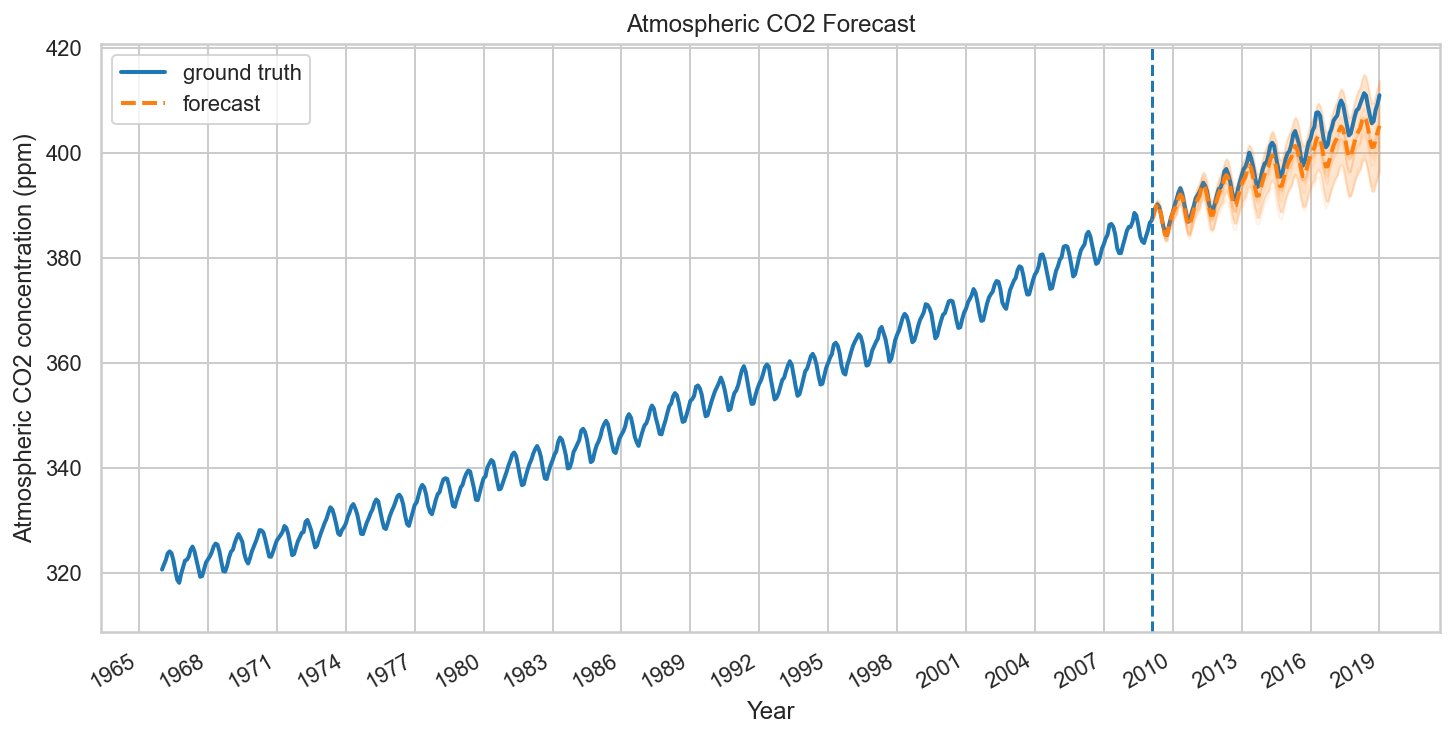

In [88]:
fig, ax = plot_forecast(co2_dates, co2_by_month, co2_forecast_mean, co2_forecast_scale, co2_forecast_samples, 
                       x_locator=co2_loc, x_formatter=co2_fmt, title="Atmospheric CO2 Forecast")
ax.axvline(co2_dates[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("Atmospheric CO2 concentration (ppm)")
ax.set_xlabel("Year")
fig.autofmt_xdate()

In [89]:
component_dists = sts.decompose_by_component(co2_model, observed_time_series=co2_by_month, 
                                             parameter_samples=q_samples_co2_)

In [92]:
co2_component_means_, co2_component_stddevs_ = ({k.name: c.mean() for k, c in component_dists.items()}, {k.name:
                                                    c.stddev() for k, c in component_dists.items()})

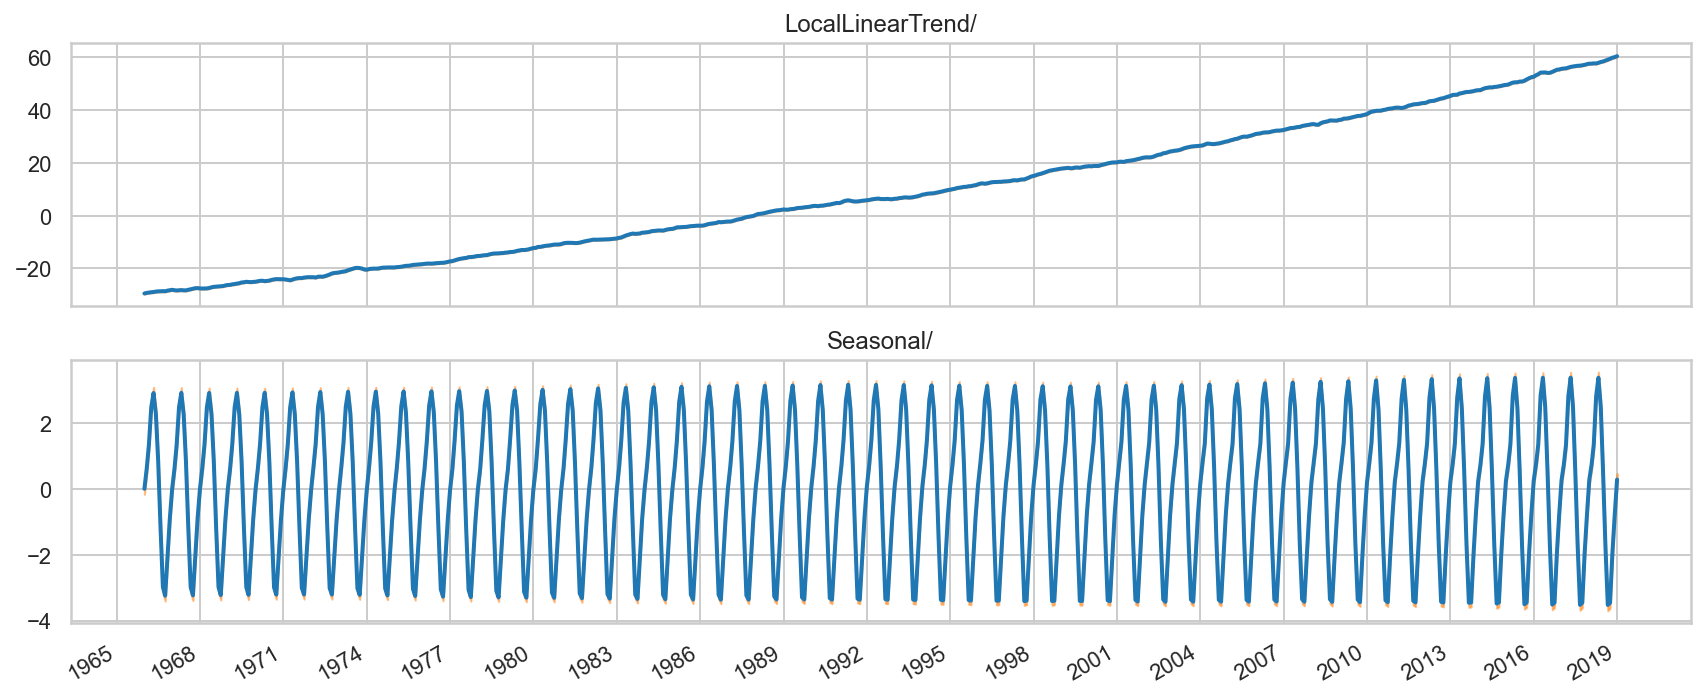

In [96]:
_ = plot_components(co2_dates, co2_component_means_, co2_component_stddevs_, x_locator=co2_loc, x_formatter=co2_fmt)

In [97]:
# Victoria electricity demand dataset, as presented at
# https://otexts.com/fpp2/scatterplots.html
# and downloaded from https://github.com/robjhyndman/fpp2-package/blob/master/data/elecdaily.rda
# This series contains the first eight weeks (starting Jan 1). The original
# dataset was half-hourly data; here we've downsampled to hourly data by taking
# every other timestep.
demand_dates = np.arange('2014-01-01', '2014-02-26', dtype='datetime64[h]')
demand_loc = mdates.WeekdayLocator(byweekday=mdates.WE)
demand_fmt = mdates.DateFormatter('%a %b %d')

demand = np.array("3.794,3.418,3.152,3.026,3.022,3.055,3.180,3.276,3.467,3.620,3.730,3.858,3.851,3.839,3.861,3.912,4.082,4.118,4.011,3.965,3.932,3.693,3.585,4.001,3.623,3.249,3.047,3.004,3.104,3.361,3.749,3.910,4.075,4.165,4.202,4.225,4.265,4.301,4.381,4.484,4.552,4.440,4.233,4.145,4.116,3.831,3.712,4.121,3.764,3.394,3.159,3.081,3.216,3.468,3.838,4.012,4.183,4.269,4.280,4.310,4.315,4.233,4.188,4.263,4.370,4.308,4.182,4.075,4.057,3.791,3.667,4.036,3.636,3.283,3.073,3.003,3.023,3.113,3.335,3.484,3.697,3.723,3.786,3.763,3.748,3.714,3.737,3.828,3.937,3.929,3.877,3.829,3.950,3.756,3.638,4.045,3.682,3.283,3.036,2.933,2.956,2.959,3.157,3.236,3.370,3.493,3.516,3.555,3.570,3.656,3.792,3.950,3.953,3.926,3.849,3.813,3.891,3.683,3.562,3.936,3.602,3.271,3.085,3.041,3.201,3.570,4.123,4.307,4.481,4.533,4.545,4.524,4.470,4.457,4.418,4.453,4.539,4.473,4.301,4.260,4.276,3.958,3.796,4.180,3.843,3.465,3.246,3.203,3.360,3.808,4.328,4.509,4.598,4.562,4.566,4.532,4.477,4.442,4.424,4.486,4.579,4.466,4.338,4.270,4.296,4.034,3.877,4.246,3.883,3.520,3.306,3.252,3.387,3.784,4.335,4.465,4.529,4.536,4.589,4.660,4.691,4.747,4.819,4.950,4.994,4.798,4.540,4.352,4.370,4.047,3.870,4.245,3.848,3.509,3.302,3.258,3.419,3.809,4.363,4.605,4.793,4.908,5.040,5.204,5.358,5.538,5.708,5.888,5.966,5.817,5.571,5.321,5.141,4.686,4.367,4.618,4.158,3.771,3.555,3.497,3.646,4.053,4.687,5.052,5.342,5.586,5.808,6.038,6.296,6.548,6.787,6.982,7.035,6.855,6.561,6.181,5.899,5.304,4.795,4.862,4.264,3.820,3.588,3.481,3.514,3.632,3.857,4.116,4.375,4.462,4.460,4.422,4.398,4.407,4.480,4.621,4.732,4.735,4.572,4.385,4.323,4.069,3.940,4.247,3.821,3.416,3.220,3.124,3.132,3.181,3.337,3.469,3.668,3.788,3.834,3.894,3.964,4.109,4.275,4.472,4.623,4.703,4.594,4.447,4.459,4.137,3.913,4.231,3.833,3.475,3.302,3.279,3.519,3.975,4.600,4.864,5.104,5.308,5.542,5.759,6.005,6.285,6.617,6.993,7.207,7.095,6.839,6.387,6.048,5.433,4.904,4.959,4.425,4.053,3.843,3.823,4.017,4.521,5.229,5.802,6.449,6.975,7.506,7.973,8.359,8.596,8.794,9.030,9.090,8.885,8.525,8.147,7.797,6.938,6.215,6.123,5.495,5.140,4.896,4.812,5.024,5.536,6.293,7.000,7.633,8.030,8.459,8.768,9.000,9.113,9.155,9.173,9.039,8.606,8.095,7.617,7.208,6.448,5.740,5.718,5.106,4.763,4.610,4.566,4.737,5.204,5.988,6.698,7.438,8.040,8.484,8.837,9.052,9.114,9.214,9.307,9.313,9.006,8.556,8.275,7.911,7.077,6.348,6.175,5.455,5.041,4.759,4.683,4.908,5.411,6.199,6.923,7.593,8.090,8.497,8.843,9.058,9.159,9.231,9.253,8.852,7.994,7.388,6.735,6.264,5.690,5.227,5.220,4.593,4.213,3.984,3.891,3.919,4.031,4.287,4.558,4.872,4.963,5.004,5.017,5.057,5.064,5.000,5.023,5.007,4.923,4.740,4.586,4.517,4.236,4.055,4.337,3.848,3.473,3.273,3.198,3.204,3.252,3.404,3.560,3.767,3.896,3.934,3.972,3.985,4.032,4.122,4.239,4.389,4.499,4.406,4.356,4.396,4.106,3.914,4.265,3.862,3.546,3.360,3.359,3.649,4.180,4.813,5.086,5.301,5.384,5.434,5.470,5.529,5.582,5.618,5.636,5.561,5.291,5.000,4.840,4.767,4.364,4.160,4.452,4.011,3.673,3.503,3.483,3.695,4.213,4.810,5.028,5.149,5.182,5.208,5.179,5.190,5.220,5.202,5.216,5.232,5.019,4.828,4.686,4.657,4.304,4.106,4.389,3.955,3.643,3.489,3.479,3.695,4.187,4.732,4.898,4.997,5.001,5.022,5.052,5.094,5.143,5.178,5.250,5.255,5.075,4.867,4.691,4.665,4.352,4.121,4.391,3.966,3.615,3.437,3.430,3.666,4.149,4.674,4.851,5.011,5.105,5.242,5.378,5.576,5.790,6.030,6.254,6.340,6.253,6.039,5.736,5.490,4.936,4.580,4.742,4.230,3.895,3.712,3.700,3.906,4.364,4.962,5.261,5.463,5.495,5.477,5.394,5.250,5.159,5.081,5.083,5.038,4.857,4.643,4.526,4.428,4.141,3.975,4.290,3.809,3.423,3.217,3.132,3.192,3.343,3.606,3.803,3.963,3.998,3.962,3.894,3.814,3.776,3.808,3.914,4.033,4.079,4.027,3.974,4.057,3.859,3.759,4.132,3.716,3.325,3.111,3.030,3.046,3.096,3.254,3.390,3.606,3.718,3.755,3.768,3.768,3.834,3.957,4.199,4.393,4.532,4.516,4.380,4.390,4.142,3.954,4.233,3.795,3.425,3.209,3.124,3.177,3.288,3.498,3.715,4.092,4.383,4.644,4.909,5.184,5.518,5.889,6.288,6.643,6.729,6.567,6.179,5.903,5.278,4.788,4.885,4.363,4.011,3.823,3.762,3.998,4.598,5.349,5.898,6.487,6.941,7.381,7.796,8.185,8.522,8.825,9.103,9.198,8.889,8.174,7.214,6.481,5.611,5.026,5.052,4.484,4.148,3.955,3.873,4.060,4.626,5.272,5.441,5.535,5.534,5.610,5.671,5.724,5.793,5.838,5.908,5.868,5.574,5.276,5.065,4.976,4.554,4.282,4.547,4.053,3.720,3.536,3.524,3.792,4.420,5.075,5.208,5.344,5.482,5.701,5.936,6.210,6.462,6.683,6.979,7.059,6.893,6.535,6.121,5.797,5.152,4.705,4.805,4.272,3.975,3.805,3.775,3.996,4.535,5.275,5.509,5.730,5.870,6.034,6.175,6.340,6.500,6.603,6.804,6.787,6.460,6.043,5.627,5.367,4.866,4.575,4.728,4.157,3.795,3.607,3.537,3.596,3.803,4.125,4.398,4.660,4.853,5.115,5.412,5.669,5.930,6.216,6.466,6.641,6.605,6.316,5.821,5.520,5.016,4.657,4.746,4.197,3.823,3.613,3.505,3.488,3.532,3.716,4.011,4.421,4.836,5.296,5.766,6.233,6.646,7.011,7.380,7.660,7.804,7.691,7.364,7.019,6.260,5.545,5.437,4.806,4.457,4.235,4.172,4.396,5.002,5.817,6.266,6.732,7.049,7.184,7.085,6.798,6.632,6.408,6.218,5.968,5.544,5.217,4.964,4.758,4.328,4.074,4.367,3.883,3.536,3.404,3.396,3.624,4.271,4.916,4.953,5.016,5.048,5.106,5.124,5.200,5.244,5.242,5.341,5.368,5.166,4.910,4.762,4.700,4.276,4.035,4.318,3.858,3.550,3.399,3.382,3.590,4.261,4.937,4.994,5.094,5.168,5.303,5.410,5.571,5.740,5.900,6.177,6.274,6.039,5.700,5.389,5.192,4.672,4.359,4.614,4.118,3.805,3.627,3.646,3.882,4.470,5.106,5.274,5.507,5.711,5.950,6.200,6.527,6.884,7.196,7.615,7.845,7.759,7.437,7.059,6.584,5.742,5.125,5.139,4.564,4.218,4.025,4.000,4.245,4.783,5.504,5.920,6.271,6.549,6.894,7.231,7.535,7.597,7.562,7.609,7.534,7.118,6.448,5.963,5.565,5.005,4.666,4.850,4.302,3.905,3.678,3.610,3.672,3.869,4.204,4.541,4.944,5.265,5.651,6.090,6.547,6.935,7.318,7.625,7.793,7.760,7.510,7.145,6.805,6.103,5.520,5.462,4.824,4.444,4.237,4.157,4.164,4.275,4.545,5.033,5.594,6.176,6.681,6.628,6.238,6.039,5.897,5.832,5.701,5.483,4.949,4.589,4.407,4.027,3.820,4.075,3.650,3.388,3.271,3.268,3.498,4.086,4.800,4.933,5.102,5.126,5.194,5.260,5.319,5.364,5.419,5.559,5.568,5.332,5.027,4.864,4.738,4.303,4.093,4.379,3.952,3.632,3.461,3.446,3.732,4.294,4.911,5.021,5.138,5.223,5.348,5.479,5.661,5.832,5.966,6.178,6.212,5.949,5.640,5.449,5.213,4.678,4.376,4.601,4.147,3.815,3.610,3.605,3.879,4.468,5.090,5.226,5.406,5.561,5.740,5.899,6.095,6.272,6.402,6.610,6.585,6.265,5.925,5.747,5.497,4.932,4.580,4.763,4.298,4.026,3.871,3.827,4.065,4.643,5.317,5.494,5.685,5.814,5.912,5.999,6.097,6.176,6.136,6.131,6.049,5.796,5.532,5.475,5.254,4.742,4.453,4.660,4.176,3.895,3.726,3.717,3.910,4.479,5.135,5.306,5.520,5.672,5.737,5.785,5.829,5.893,5.892,5.921,5.817,5.557,5.304,5.234,5.074,4.656,4.396,4.599,4.064,3.749,3.560,3.475,3.552,3.783,4.045,4.258,4.539,4.762,4.938,5.049,5.037,5.066,5.151,5.197,5.201,5.132,4.908,4.725,4.568,4.222,3.939,4.215,3.741,3.380,3.174,3.076,3.071,3.172,3.328,3.427,3.603,3.738,3.765,3.777,3.705,3.690,3.742,3.859,4.032,4.113,4.032,4.066,4.011,3.712,3.530,3.905,3.556,3.283,3.136,3.146,3.400,4.009,4.717,4.827,4.909,4.973,5.036,5.079,5.160,5.228,5.241,5.343,5.350,5.184,4.941,4.797,4.615,4.160,3.904,4.213,3.810,3.528,3.369,3.381,3.609,4.178,4.861,4.918,5.006,5.102,5.239,5.385,5.528,5.724,5.845,6.048,6.097,5.838,5.507,5.267,5.003,4.462,4.184,4.431,3.969,3.660,3.480,3.470,3.693,4.313,4.955,5.083,5.251,5.268,5.293,5.285,5.308,5.349,5.322,5.328,5.151,4.975,4.741,4.678,4.458,4.056,3.868,4.226,3.799,3.428,3.253,3.228,3.452,4.040,4.726,4.709,4.721,4.741,4.846,4.864,4.868,4.836,4.799,4.890,4.946,4.800,4.646,4.693,4.546,4.117,3.897,4.259,3.893,3.505,3.341,3.334,3.623,4.240,4.925,4.986,5.028,4.987,4.984,4.975,4.912,4.833,4.686,4.710,4.718,4.577,4.454,4.532,4.407,4.064,3.883,4.221,3.792,3.445,3.261,3.221,3.295,3.521,3.804,4.038,4.200,4.226,4.198,4.182,4.078,4.018,4.002,4.066,4.158,4.154,4.084,4.104,4.001,3.773,3.700,4.078,3.702,3.349,3.143,3.052,3.070,3.181,3.327,3.440,3.616,3.678,3.694,3.710,3.706,3.764,3.852,4.009,4.202,4.323,4.249,4.275,4.162,3.848,3.706,4.060,3.703,3.401,3.251,3.239,3.455,4.041,4.743,4.815,4.916,4.931,4.966,5.063,5.218,5.381,5.458,5.550,5.566,5.376,5.104,5.022,4.793,4.335,4.108,4.410,4.008,3.666,3.497,3.464,3.698,4.333,4.998,5.094,5.272,5.459,5.648,5.853,6.062,6.258,6.236,6.226,5.957,5.455,5.066,4.968,4.742,4.304,4.105,4.410".split(",")).astype(np.float32)
temperature = np.array("18.050,17.200,16.450,16.650,16.400,17.950,19.700,20.600,22.350,23.700,24.800,25.900,25.300,23.650,20.700,19.150,22.650,22.650,22.400,22.150,22.050,22.150,21.000,19.500,18.450,17.250,16.300,15.700,15.500,15.450,15.650,16.500,18.100,17.800,19.100,19.850,20.300,21.050,22.800,21.650,20.150,19.300,18.750,17.900,17.350,16.850,16.350,15.700,14.950,14.500,14.350,14.450,14.600,14.600,14.700,15.450,16.700,18.300,20.100,20.650,19.450,20.200,20.250,20.050,20.250,20.950,21.900,21.000,19.900,19.250,17.300,16.300,15.800,15.000,14.400,14.050,13.650,13.500,14.150,15.300,14.800,17.050,18.350,19.450,18.550,18.650,18.850,19.800,19.650,18.900,19.500,17.700,17.350,16.950,16.400,15.950,14.900,14.250,13.050,12.000,11.500,10.950,12.300,16.100,17.100,19.600,21.100,22.600,24.350,25.250,25.750,20.350,15.550,18.300,19.400,19.250,18.550,17.700,16.750,15.800,14.900,14.050,14.100,13.500,13.000,12.950,13.300,13.900,15.400,16.750,17.300,17.750,18.400,18.500,18.800,19.450,18.750,18.400,16.950,15.800,15.350,15.250,15.150,14.900,14.500,14.600,14.400,14.150,14.300,14.500,14.950,15.550,15.800,15.550,16.450,17.500,17.700,18.750,19.600,19.900,19.350,19.550,17.900,16.400,15.550,14.900,14.400,13.950,13.300,12.950,12.650,12.450,12.350,12.150,11.950,14.150,15.850,17.750,19.450,22.150,23.850,23.450,24.950,26.850,26.100,25.150,23.250,21.300,19.850,18.900,18.250,17.450,17.100,16.400,15.550,15.050,14.400,14.550,15.150,17.050,18.850,20.850,24.250,27.700,28.400,30.750,30.700,32.200,31.750,30.650,29.750,28.850,27.850,25.950,24.700,24.850,24.050,23.850,23.500,22.950,22.200,21.750,22.350,24.050,25.150,27.100,28.050,29.750,31.250,31.900,32.950,33.150,33.950,33.850,33.250,32.500,31.500,28.300,23.900,22.900,22.300,21.250,20.500,19.850,18.850,18.300,18.100,18.200,18.150,18.000,17.700,18.250,19.700,20.750,21.800,21.500,21.600,20.800,19.400,18.400,17.900,17.600,17.550,17.550,17.650,17.400,17.150,16.800,17.000,16.900,17.200,17.350,17.650,17.800,18.400,19.300,20.200,21.050,21.700,21.800,21.800,21.500,20.000,19.300,18.200,18.100,17.700,16.950,16.250,15.600,15.500,15.300,15.450,15.500,15.750,17.350,19.150,21.650,24.700,25.200,24.300,26.900,28.100,29.450,29.850,29.450,26.350,27.050,25.700,25.150,23.850,22.450,21.450,20.850,20.700,21.300,21.550,20.800,22.300,26.300,32.600,35.150,36.800,38.150,39.950,40.850,41.250,42.300,41.950,41.350,40.600,36.350,36.150,34.600,34.050,35.400,36.300,35.550,33.700,30.650,29.450,29.500,31.000,33.300,35.700,36.650,37.650,39.400,40.600,40.250,37.550,37.300,35.400,32.750,31.200,29.600,28.350,27.500,28.750,28.900,29.900,28.700,28.650,28.150,28.250,27.650,27.800,29.450,32.500,35.750,38.850,39.900,41.100,41.800,42.750,39.900,39.750,40.800,37.950,31.250,34.600,30.250,28.500,27.900,27.950,27.300,26.900,26.800,26.050,26.100,27.700,31.850,34.850,36.350,38.000,39.200,41.050,41.600,42.350,43.100,33.500,30.700,29.100,26.400,23.900,24.700,24.350,23.450,23.450,23.550,23.050,22.200,22.100,22.000,21.900,22.050,22.550,22.850,22.450,22.250,22.650,22.350,21.900,21.000,20.950,20.200,19.700,19.400,19.200,18.650,18.150,18.150,17.650,17.350,17.150,16.800,16.750,16.400,16.500,16.700,17.300,17.750,19.200,20.400,20.900,21.450,22.000,22.100,21.600,21.700,20.500,19.850,19.750,19.500,19.200,19.800,19.500,19.200,19.200,19.150,19.050,19.100,19.250,19.550,20.200,20.550,21.450,23.150,23.500,23.400,23.500,23.300,22.850,22.250,20.950,19.750,19.450,18.900,18.450,17.950,17.550,17.300,16.950,16.900,16.850,17.100,17.250,17.400,17.850,18.100,18.600,19.700,21.000,21.400,22.650,22.550,22.000,21.050,19.550,18.550,18.300,17.750,17.800,17.650,17.800,17.450,16.950,16.500,16.900,17.050,16.750,17.300,18.800,19.350,20.750,21.400,21.900,21.950,22.800,22.750,23.200,22.650,20.800,19.250,17.800,16.950,16.550,16.050,15.750,15.150,14.700,14.150,13.900,13.900,14.000,15.800,17.650,19.700,22.500,25.300,24.300,24.650,26.450,27.250,26.550,28.800,27.850,25.200,24.750,23.750,22.550,22.350,21.700,21.300,20.300,20.050,20.500,21.250,20.850,21.000,19.400,18.900,18.150,18.650,20.200,20.000,21.650,21.950,21.150,20.400,19.500,19.150,18.400,18.050,17.750,17.600,17.150,16.750,16.350,16.250,15.900,15.850,15.900,16.200,18.500,18.750,18.800,19.850,19.750,19.600,19.300,20.000,20.250,19.700,18.600,17.400,17.100,16.650,16.250,16.250,15.800,15.350,14.800,14.250,13.500,13.400,14.350,15.800,17.700,19.000,21.050,22.200,22.450,24.950,24.750,25.050,26.400,26.200,26.500,25.850,24.400,23.600,22.650,21.500,20.150,19.900,18.850,18.700,18.750,18.650,20.050,23.450,24.900,26.450,28.550,30.600,31.550,32.800,33.500,33.700,34.450,34.200,33.650,32.900,31.750,30.500,29.250,28.100,26.450,25.400,25.400,25.150,25.400,25.100,25.950,28.100,30.400,32.000,33.750,34.700,35.800,37.000,39.050,39.750,41.200,41.050,36.050,28.250,24.450,23.150,22.050,21.600,21.450,20.800,20.250,19.700,19.400,19.650,19.100,18.650,18.900,19.400,20.700,21.750,22.350,24.100,23.350,24.400,22.950,22.400,20.950,19.600,18.900,18.000,17.400,16.800,16.550,16.300,16.250,16.750,16.700,17.100,17.500,18.150,18.850,20.650,22.600,25.600,28.500,26.750,27.200,27.300,27.500,27.000,25.450,24.500,23.850,23.200,22.550,21.850,21.050,20.200,19.950,20.400,20.300,20.100,20.450,20.900,21.450,21.800,23.250,24.100,25.200,25.550,25.900,25.450,26.050,25.350,23.900,22.250,22.000,21.700,21.450,20.550,19.000,18.850,18.700,19.050,19.350,19.350,19.450,19.600,20.550,22.400,24.550,26.900,27.950,28.500,28.200,29.050,28.700,28.800,27.150,24.900,23.500,23.350,23.000,22.300,21.400,20.700,19.850,19.400,19.250,18.700,18.650,20.200,23.400,26.400,27.450,29.150,32.050,34.500,34.950,36.550,37.850,38.400,35.150,34.050,34.100,33.100,30.300,29.300,27.550,26.600,25.900,25.500,25.150,25.000,25.150,27.000,31.150,32.750,31.500,26.900,23.900,23.150,22.850,21.500,21.150,21.300,19.700,18.800,18.450,18.300,17.800,16.850,16.400,16.150,15.700,15.500,15.400,15.300,15.050,15.650,18.100,19.200,21.050,22.350,23.450,24.850,24.950,25.550,25.300,24.250,22.750,20.850,19.350,18.250,17.450,17.000,16.500,16.100,15.950,15.300,14.550,14.250,14.400,15.550,18.300,20.000,22.750,25.450,25.800,26.350,29.150,30.450,30.350,29.600,27.550,25.550,23.650,22.950,21.850,20.700,20.150,19.300,19.000,18.400,17.800,17.750,18.000,20.800,23.400,25.750,27.750,29.600,32.150,32.900,33.650,34.300,34.800,35.050,33.750,33.250,32.400,31.250,29.650,28.550,26.550,25.950,25.000,24.400,24.150,24.150,24.350,26.900,28.750,30.350,32.750,34.250,35.300,28.400,27.250,26.600,25.750,25.350,23.150,21.550,20.850,20.550,20.350,20.550,20.600,19.900,19.550,19.200,18.900,18.850,19.250,21.000,23.050,25.350,27.700,31.050,35.250,35.100,36.850,39.250,40.000,39.450,38.950,37.750,33.850,30.400,25.700,25.400,25.600,28.150,32.400,31.850,31.350,31.200,31.100,31.950,32.450,35.200,38.400,35.850,30.700,27.850,26.900,26.650,25.250,24.450,22.500,22.050,20.000,19.750,19.100,18.500,18.400,17.400,16.900,16.800,16.450,16.050,16.300,17.450,19.300,20.000,21.050,22.800,22.550,23.300,24.050,23.100,23.100,22.500,20.800,19.550,18.800,18.200,17.650,17.750,17.150,16.550,16.200,16.000,15.600,15.150,15.150,16.250,17.800,19.150,21.000,22.800,23.850,24.250,26.200,25.650,25.050,23.850,23.600,23.100,22.950,22.550,21.550,20.450,19.600,18.700,18.300,18.000,17.550,17.300,17.200,17.950,19.450,21.100,23.050,24.650,25.050,25.850,25.300,26.650,25.500,25.900,26.250,25.300,25.150,23.600,22.050,21.700,21.150,20.550,20.500,20.200,20.500,20.600,20.900,21.700,22.000,22.250,23.400,23.900,25.250,26.200,26.000,25.300,25.200,25.300,25.500,25.350,25.050,24.850,24.050,23.150,22.300,21.900,21.150,20.300,19.650,19.700,19.750,20.250,21.500,23.600,24.600,25.900,25.450,24.850,25.900,26.150,26.250,26.350,26.250,25.850,25.300,24.600,23.750,22.250,21.750,21.450,21.500,21.300,21.250,21.200,21.600,22.000,23.650,25.200,26.400,25.500,25.150,26.950,28.350,25.650,25.000,25.500,24.150,22.900,21.600,21.750,21.500,21.550,20.450,19.500,18.750,18.650,18.200,17.300,17.900,18.050,17.400,16.850,17.950,20.550,21.950,22.600,22.300,22.400,22.300,21.100,20.250,19.200,18.900,18.600,18.350,17.700,17.200,16.850,16.900,16.800,16.800,16.600,16.350,17.200,18.350,19.550,20.300,21.600,21.800,23.300,23.200,24.550,24.950,24.900,23.700,22.000,19.650,18.250,17.700,17.250,16.900,16.550,16.050,16.450,15.400,14.900,14.700,16.100,18.450,19.800,23.000,25.250,27.600,27.900,28.550,29.450,29.700,29.350,27.000,23.550,21.900,20.750,20.150,19.600,19.150,18.800,18.550,18.200,17.750,17.650,17.800,18.750,19.600,20.450,21.950,23.700,23.150,24.150,24.550,21.400,19.150,19.050,16.500,15.900,14.850,15.300,14.100,13.800,13.600,13.450,13.400,13.050,12.750,12.800,12.750,13.600,14.950,16.100,17.500,18.500,19.300,19.400,19.750,19.400,19.450,19.450,18.900,17.650,16.800,15.900,15.050,14.550,14.250,13.800,13.850,13.700,13.650,13.350,13.400,14.050,15.000,16.650,17.850,18.450,18.200,18.900,19.850,20.000,19.700,18.800,17.500,16.600,16.250,16.000,16.300,16.400,15.800,15.850,14.600,14.650,15.200,14.900,14.600,15.150,16.000,16.350,17.000,18.300,19.050,19.300,19.400,18.650,18.750,19.100,18.300,17.950,17.550,16.900,16.450,15.850,15.800,15.650,15.200,14.700,14.950,15.250,15.200,15.800,16.800,17.900,19.700,21.050,21.600,22.550,22.750,22.900,22.500,21.950,20.450,19.600,19.200,18.000,16.950,16.450,16.150,15.600,15.150,15.250,15.200,14.750,15.050,15.600,17.750,18.450,20.050,21.350,22.500,23.550,24.100,22.600,23.150,24.100,22.650,21.250,19.900,19.100,18.250,17.750,17.500,16.600,16.100,15.850,15.750,15.700,16.350,19.600,25.750,27.800,30.050,32.350,31.900,32.450,29.600,28.850,23.450,21.100,20.100,20.100,19.900,19.300,19.050,18.850".split(",")).astype(np.float32)

num_forecast_steps = 24 * 7 * 2 # Two weeks.
demand_training_data = demand[:-num_forecast_steps]

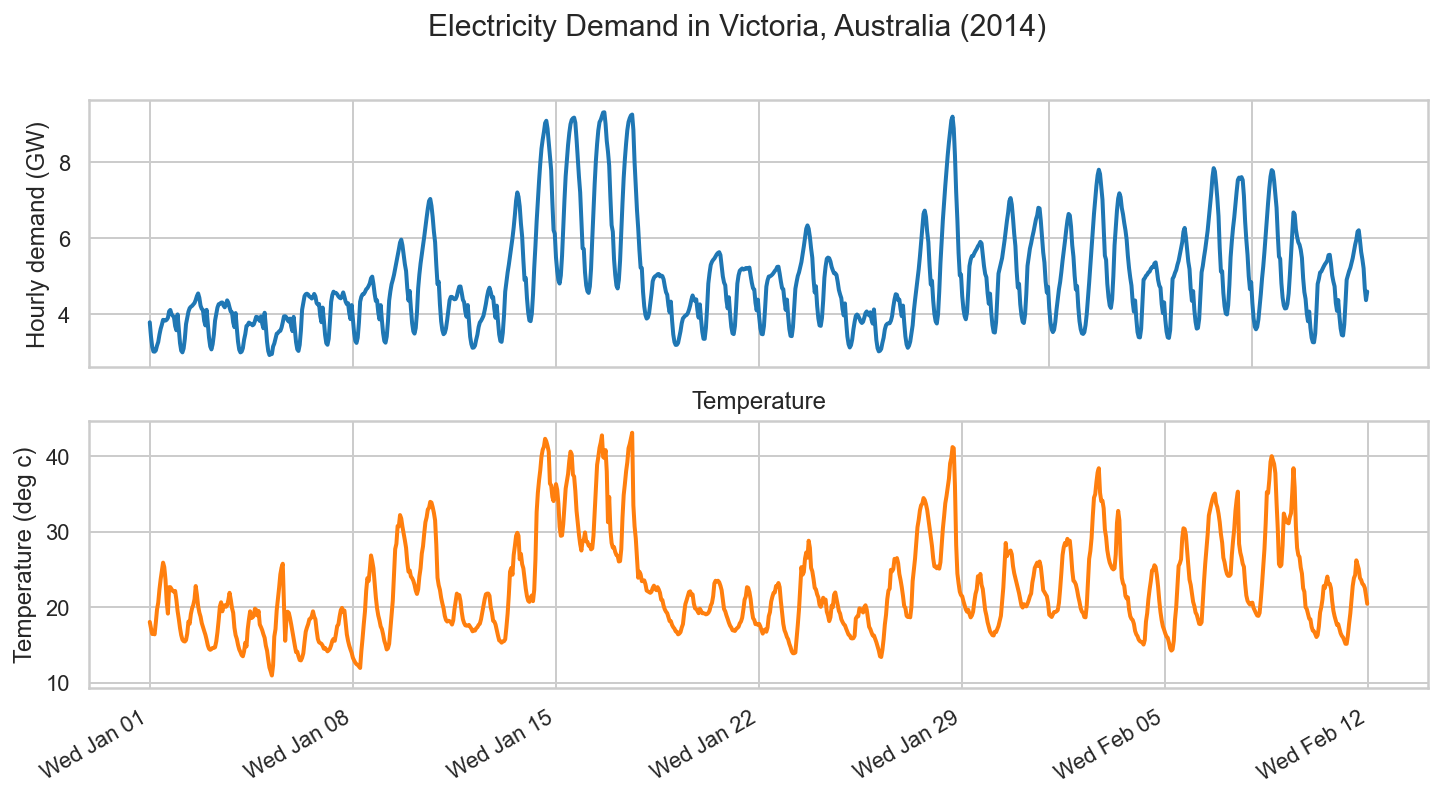

In [101]:
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(demand_dates[:-num_forecast_steps], demand[:-num_forecast_steps], lw=2, label="training data")
ax.set_ylabel("Hourly demand (GW)")
ax = fig.add_subplot(2, 1, 2)
ax.plot(demand_dates[:-num_forecast_steps], temperature[:-num_forecast_steps], lw=2, label="training data", c=c2)
ax.set_ylabel("Temperature (deg c)")
ax.set_title("Temperature")
ax.xaxis.set_major_locator(demand_loc)
ax.xaxis.set_major_formatter(demand_fmt)
fig.suptitle("Electricity Demand in Victoria, Australia (2014)", fontsize=15)
fig.autofmt_xdate()

In [107]:
def build_model(observed_time_series):
    hour_of_day_effect = sts.Seasonal(num_seasons=24, observed_time_series=observed_time_series, 
                                      name='hour_of_day_effect')
    day_of_week_effect = sts.Seasonal(num_seasons=7, num_steps_per_season=24, 
                                      observed_time_series=observed_time_series, name="day_of_week_effect")
    temperature_effect = sts.LinearRegression(design_matrix=tf.reshape(temperature - np.mean(temperature), (-1, 1)),
                                             name="temperature_effect")
    autoregressive = sts.Autoregressive(order=1, observed_time_series=observed_time_series, name='autoregressive')
    model = sts.Sum([hour_of_day_effect, day_of_week_effect, temperature_effect, autoregressive], observed_time_series=
                   observed_time_series)
    return model

In [108]:
demand_model = build_model(demand_training_data)
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model = demand_model)

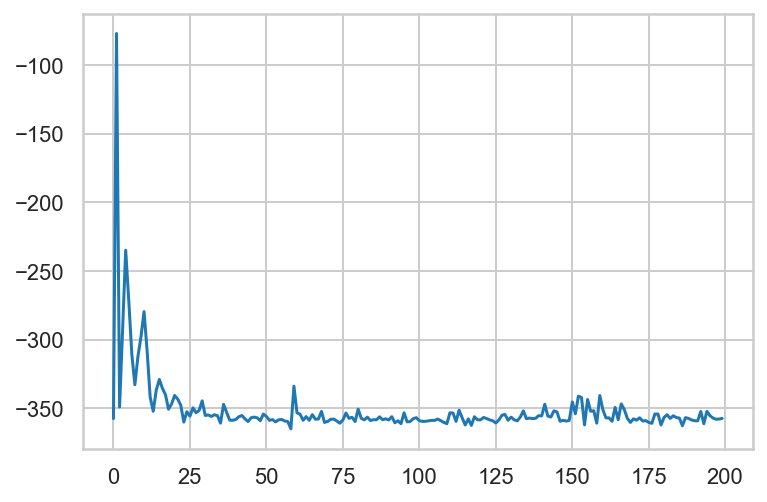

In [110]:
num_variational_steps = 200
num_variational_steps = int(num_variational_steps)
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(target_log_prob_fn=
                            demand_model.joint_distribution(observed_time_series=demand_training_data).log_prob, 
                                                surrogate_posterior=variational_posteriors, optimizer=
                                                tf.optimizers.Adam(learning_rate=0.1), num_steps=
                                                num_variational_steps, jit_compile=True)
plt.plot(elbo_loss_curve)
plt.show()
q_samples_demand = variational_posteriors.sample(50)

In [114]:
print("Inferred parameters:")
for param in demand_model.parameters:
    print("{}: {} +- {}".format(param.name, np.mean(q_samples_demand[param.name], axis=0), 
                                np.std(q_samples_demand[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 0.0021547856740653515 +- 0.0017504561692476273
hour_of_day_effect/_drift_scale: 0.0008546340395696461 +- 0.0013625745195895433
day_of_week_effect/_drift_scale: 0.0033889925107359886 +- 0.0040833293460309505
temperature_effect/_weights: [0.05243371] +- [0.00331261]
autoregressive/_coefficients: [0.986139] +- [0.00268335]
autoregressive/_level_scale: 0.14537864923477173 +- 0.0020752823911607265


In [115]:
demand_forecast_dist = tfp.sts.forecast(model=demand_model, observed_time_series=demand_training_data, 
                                        parameter_samples=q_samples_demand, num_steps_forecast=num_forecast_steps)

In [116]:
num_samples = 10
(demand_forecast_mean, demand_forecast_scale, demand_forecast_samples) = (demand_forecast_dist.mean().numpy()[..., 0], 
                                                                         demand_forecast_dist.stddev().numpy()[..., 0], 
                                                            demand_forecast_dist.sample(num_samples).numpy()[..., 0])

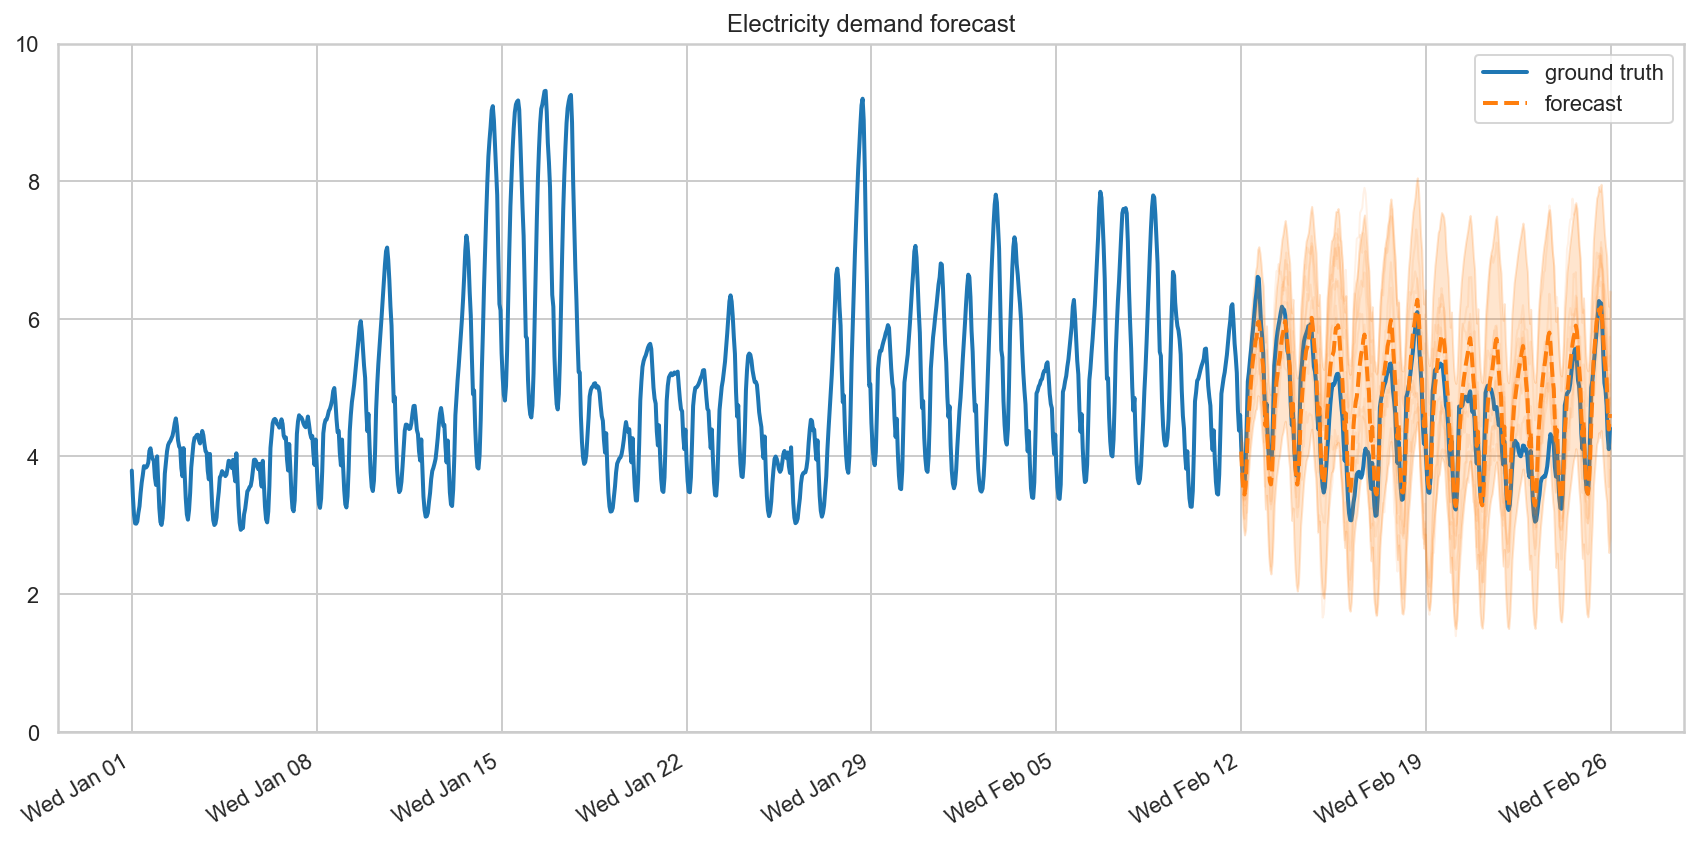

In [119]:
fig, ax = plot_forecast(demand_dates, demand, demand_forecast_mean, demand_forecast_scale, demand_forecast_samples, 
                        title="Electricity demand forecast", x_locator=demand_loc, x_formatter=demand_fmt)
ax.set_ylim([0, 10])
fig.tight_layout()

In [121]:
component_dists = sts.decompose_by_component(demand_model, observed_time_series=demand_training_data, 
                                             parameter_samples=q_samples_demand)
forecast_component_dists = sts.decompose_forecast_by_component(demand_model, forecast_dist=demand_forecast_dist, 
                                                              parameter_samples=q_samples_demand)

In [124]:
demand_component_means_, demand_component_stddevs_ = ({k.name: c.mean() for k, c in component_dists.items()}, 
                                                     {k.name: c.stddev() for k, c in component_dists.items()})
(demand_forecast_component_means_, demand_forcast_component_stddevs_) = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()}, 
    {k.name: c.stddev() for k, c in forecast_component_dists.items()})

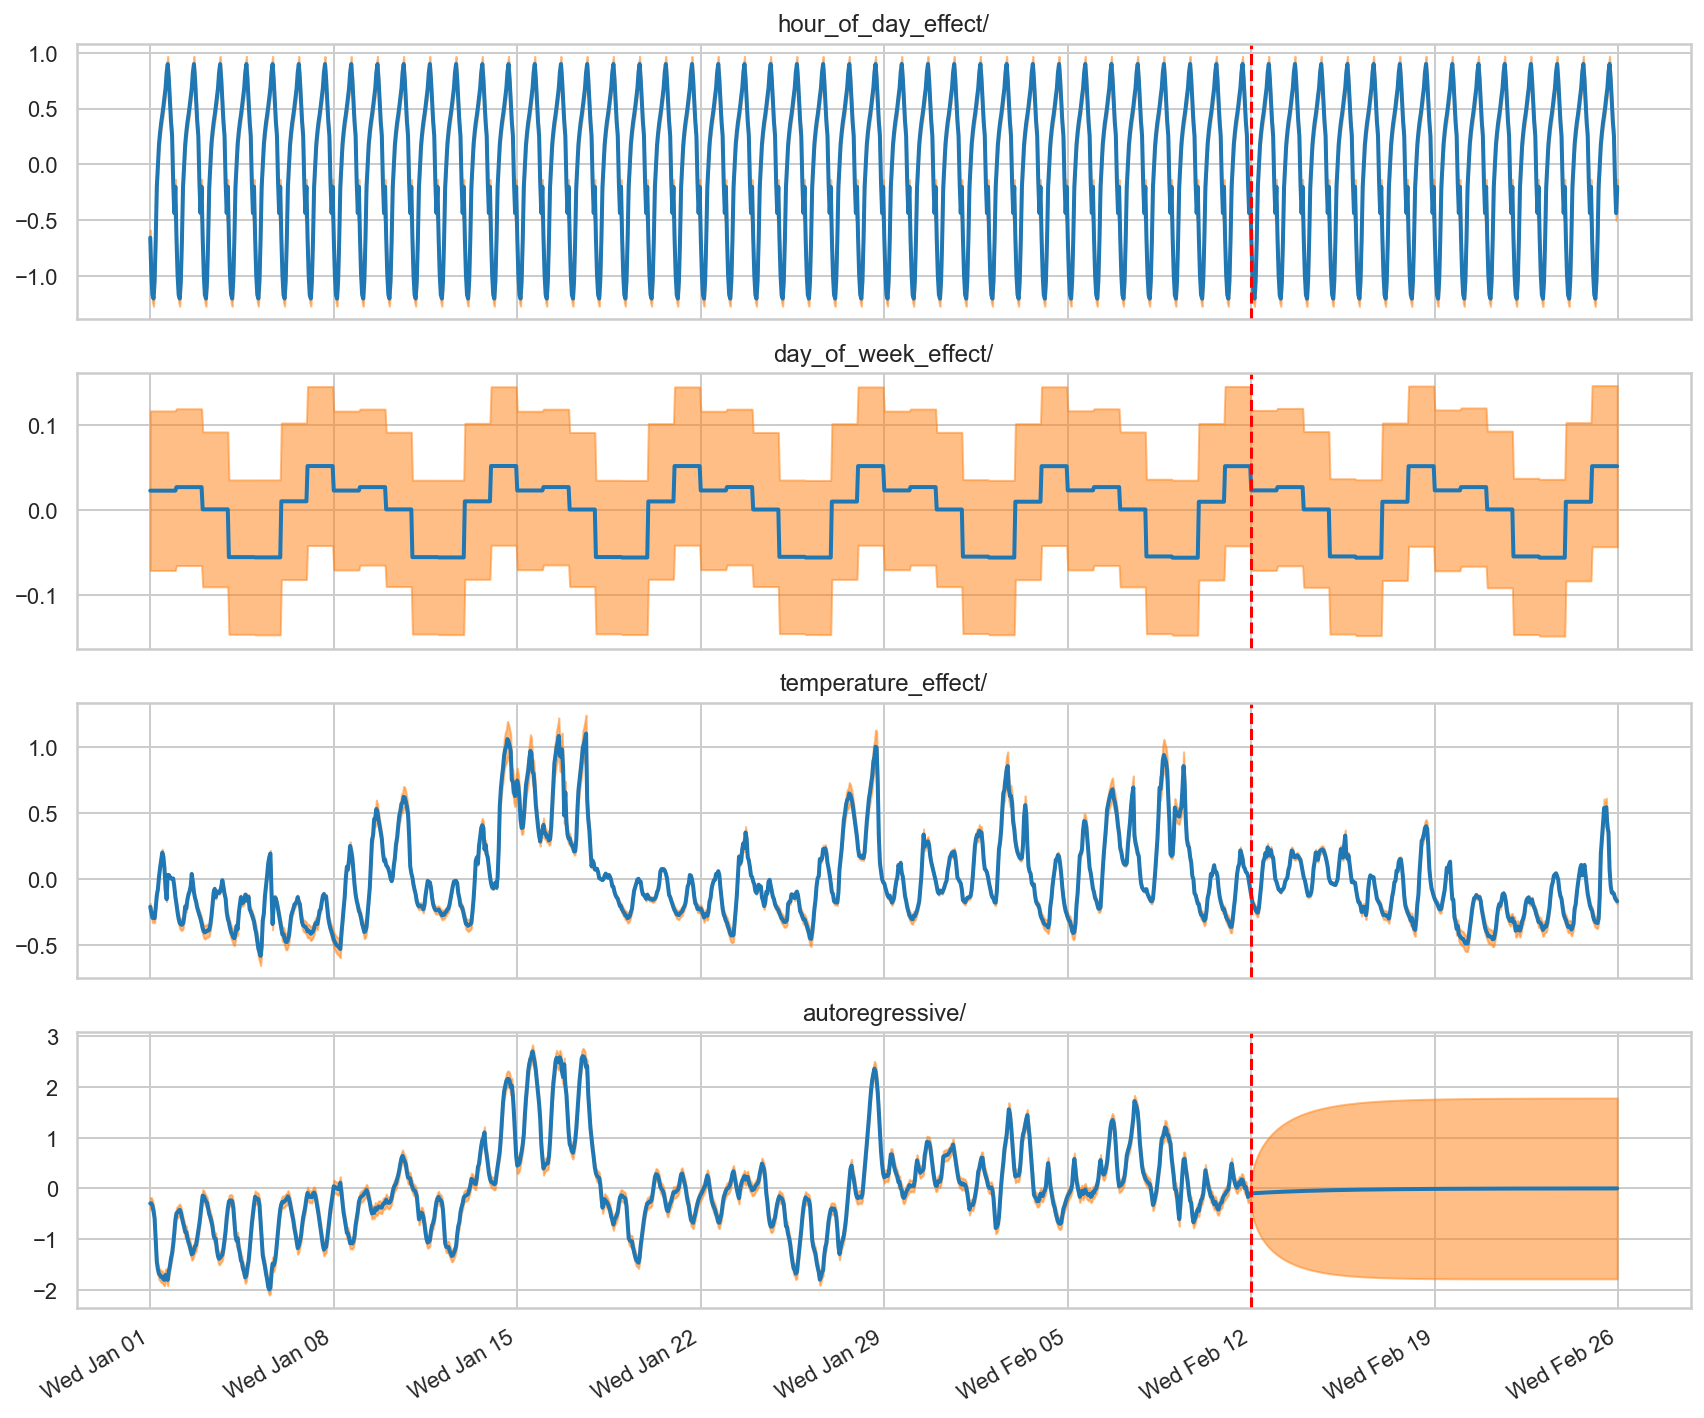

In [126]:
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in demand_component_means_.keys():
    component_with_forecast_means_[k] = np.concatenate([demand_component_means_[k], 
                                                        demand_forecast_component_means_[k]], axis=-1)
    component_with_forecast_stddevs_[k] = np.concatenate([demand_component_stddevs_[k], 
                                                          demand_forcast_component_stddevs_[k]], axis=-1)
fig, axes = plot_components(demand_dates, component_with_forecast_means_, component_with_forecast_stddevs_, 
                            x_locator=demand_loc, x_formatter=demand_fmt)
for ax in axes.values():
    ax.axvline(demand_dates[-num_forecast_steps], linestyle="--", color="red")

In [128]:
demand_one_step_dist = sts.one_step_predictive(demand_model, observed_time_series=demand, 
                                               parameter_samples=q_samples_demand)
demand_one_step_mean, demand_one_step_scale = (demand_one_step_dist.mean().numpy(), 
                                               demand_one_step_dist.stddev().numpy())

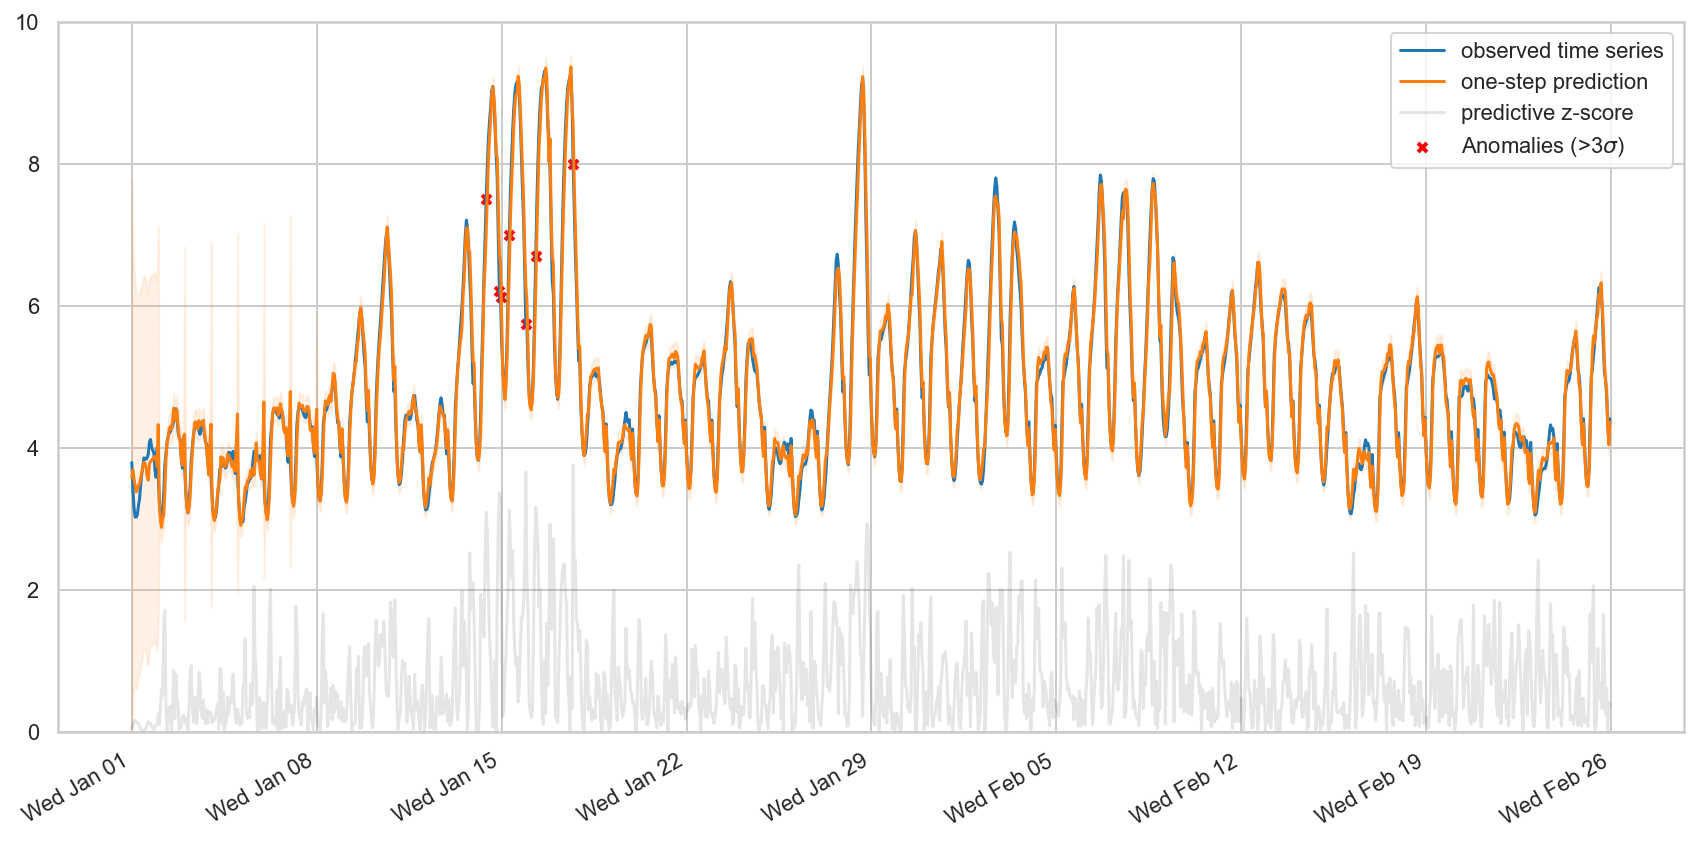

In [132]:
fig, ax = plot_one_step_predictive(demand_dates, demand, demand_one_step_mean, demand_one_step_scale, 
                                   x_locator=demand_loc, x_formatter=demand_fmt)
ax.set_ylim(0, 10)
zscores = np.abs((demand - demand_one_step_mean) / demand_one_step_scale)
anomalies = zscores > 3.0
ax.scatter(demand_dates[anomalies], demand[anomalies], c="red", marker="x", s=20, linewidth=2, 
           label=r"Anomalies (>3$\sigma$)")
ax.plot(demand_dates, zscores, color="black", alpha=0.1, label="predictive z-score")
ax.legend()
plt.show()

# Variational Inference on Probabilistic Graphical Models with Joint Distributions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import warnings
import tensorflow as tf
tfd = tfp.distributions
tfb = tfp.bijectors
plt.rcParams['figure.facecolor'] = '1.'

In [2]:
dataset = tfds.as_numpy(tfds.load('radon', split='train').filter(lambda x: x['features']['state'] == 'MN').batch(10**9))

dataset = next(iter(dataset))
radon_measurement = dataset['activity'].astype(np.float32)
radon_measurement[radon_measurement <= 0.] = 0.1
log_radon = np.log(radon_measurement)

uranium_measurement = dataset['features']['Uppm'].astype(np.float32)
log_uranium = np.log(uranium_measurement)

county_strings = dataset['features']['county'].astype('U13')
unique_counties, county = np.unique(county_strings, return_inverse=True)
county = county.astype(np.int32)
num_counties = unique_counties.size

floor_of_house = dataset['features']['floor'].astype(np.int32)

county_mean_floor = []
for i in range(num_counties):
    county_mean_floor.append(floor_of_house[county == i].mean())
county_mean_floor = np.array(county_mean_floor, dtype=log_radon.dtype)
floor_by_county = county_mean_floor[county]

In [3]:
floor_weight = tf.Variable(0.)
bias = tf.Variable(0.)
log_radon_scale = tfp.util.TransformedVariable(1., tfb.Exp())
county_effect_scale = tfp.util.TransformedVariable(1., tfb.Exp())

@tfd.JointDistributionCoroutineAutoBatched
def model():
    uranium_weight = yield tfd.Normal(0., scale=1., name="uranium_weight")
    county_floor_weight = yield tfd.Normal(0., scale=1., name="county_floor_weight")
    county_effect = yield tfd.Sample(tfd.Normal(0., scale=county_effect_scale), sample_shape=[num_counties], 
                                     name='county_effect')
    yield tfd.Normal(loc=(log_uranium * uranium_weight + floor_of_house * floor_weight + floor_by_county * 
                          county_floor_weight + tf.gather(county_effect, county, axis=-1) + bias), scale=
                    log_radon_scale[..., tf.newaxis], name='log_radon')
target_model = model.experimental_pin(log_radon=log_radon)

In [4]:
event_shape = target_model.event_shape_tensor()
flat_event_shape = tf.nest.flatten(event_shape)
flat_event_size = tf.nest.map_structure(tf.reduce_prod, flat_event_shape)

event_space_bijector = target_model.experimental_default_event_space_bijector()

In [5]:
base_standard_dist = tfd.JointDistributionSequential([tfd.Sample(tfd.Normal(0., 1.), s) for s in flat_event_size])

In [6]:
operators = ((tf.linalg.LinearOperatorDiag, ), (tf.linalg.LinearOperatorFullMatrix, tf.linalg.LinearOperatorDiag), 
            (None, None, tf.linalg.LinearOperatorDiag))
block_tril_linop = (tfp.experimental.vi.util.build_trainable_linear_operator_block(operators, flat_event_size))
scale_bijector = tfb.ScaleMatvecLinearOperatorBlock(block_tril_linop)

In [7]:
loc_bijector = tfb.JointMap(tf.nest.map_structure(lambda s: tfb.Shift(tf.Variable(tf.random.uniform((s, ), minval=-2., 
                                                                    maxval=2., dtype=tf.float32))), flat_event_size))

In [8]:
reshape_bijector = tfb.JointMap(tf.nest.map_structure(tfb.Reshape, flat_event_shape))
unflatten_bijector = tfb.Restructure(tf.nest.pack_sequence_as(event_shape, range(len(flat_event_shape))))

In [9]:
surrogate_posterior = tfd.TransformedDistribution(base_standard_dist, bijector=tfb.Chain([
    event_space_bijector, 
    unflatten_bijector,
    reshape_bijector,
    loc_bijector,
    scale_bijector
]))

Multivariate Normal Surrogate posterior ELBO: -1065.7462158203125


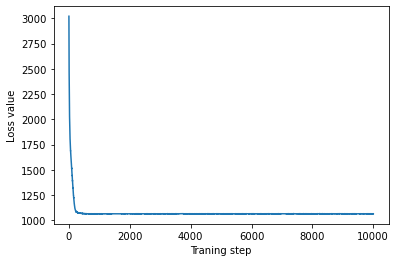

In [10]:
optimizer = tf.optimizers.Adam(learning_rate=1e-2)
mvn_loss = tfp.vi.fit_surrogate_posterior(target_model.unnormalized_log_prob, surrogate_posterior, optimizer=optimizer, 
                                         num_steps=10 ** 4, sample_size=16, jit_compile=True)
mvn_samples = surrogate_posterior.sample(1000)
mvn_final_elbo = tf.reduce_mean(target_model.unnormalized_log_prob(*mvn_samples) - surrogate_posterior.log_prob(
    mvn_samples))
print("Multivariate Normal Surrogate posterior ELBO: {}".format(mvn_final_elbo))
plt.plot(mvn_loss)
plt.xlabel('Traning step')
_ = plt.ylabel('Loss value')

In [11]:
base_distribution = tfd.Sample(tfd.Normal(0., 1.), sample_shape=[tf.reduce_sum(flat_event_size)])
num_iafs = 2
iaf_bijectors = [tfb.Invert(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=tfb.AutoregressiveNetwork(params=2, 
                            hidden_units=[256, 256], activation='relu'))) for _ in range(num_iafs)]
split = tfb.Split(flat_event_size)
iaf_surrogate_posterior = tfd.TransformedDistribution(base_distribution, bijector=tfb.Chain([event_space_bijector, 
                            unflatten_bijector, reshape_bijector, split] + iaf_bijectors))

Bias is : 1.40
Floor fixed effect is: -0.71


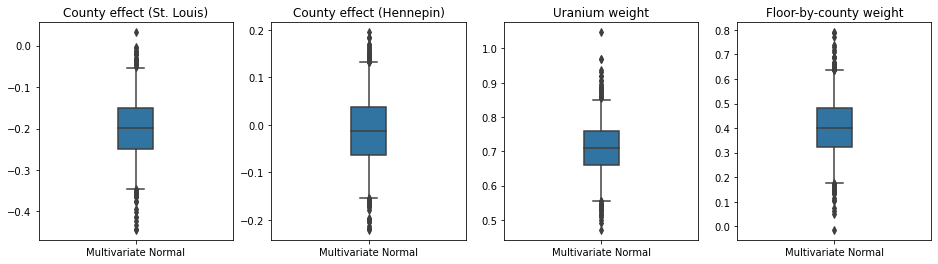

In [12]:
st_louis_co = 69
hennepin_co = 25
def pack_samples(samples):
    return {'County effect (St. Louis)': samples.county_effect[..., st_louis_co],
           'County effect (Hennepin)': samples.county_effect[..., hennepin_co], 
           'Uranium weight': samples.uranium_weight,
           'Floor-by-county weight': samples.county_floor_weight}
def plot_boxplot(posterior_samples):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    k = list(posterior_samples.values())[0].keys()
    plot_results = {v: {p: posterior_samples[p][v] for p in posterior_samples} for v in k}
    for i, (var, var_results) in enumerate(plot_results.items()):
        sns.boxplot(data=list(var_results.values()), ax=axes[i], width=0.18 * len(var_results), whis=(2.5, 97.5))
        axes[i].title.set_text(var)
        fs = 10 if len(var_results) < 4 else 8
        axes[i].set_xticklabels(list(var_results.keys()), fontsize=fs)
results = {'Multivariate Normal':pack_samples(mvn_samples)}
print('Bias is : {:.2f}'.format(bias.numpy()))
print('Floor fixed effect is: {:.2f}'.format(floor_weight.numpy()))
plot_boxplot(results)

IAF surrogate posterior ELBO: -1065.232666015625


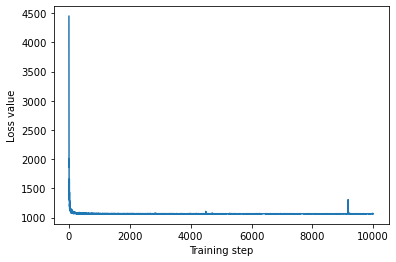

In [13]:
optimizer = tf.optimizers.Adam(learning_rate=1e-2)
iaf_loss = tfp.vi.fit_surrogate_posterior(target_model.unnormalized_log_prob, iaf_surrogate_posterior, 
                                          optimizer=optimizer, num_steps=10 ** 4, sample_size=4, jit_compile=True)
iaf_samples = iaf_surrogate_posterior.sample(1000)
iaf_final_elbo = tf.reduce_mean(target_model.unnormalized_log_prob(*iaf_samples) - 
                                iaf_surrogate_posterior.log_prob(iaf_samples))
print('IAF surrogate posterior ELBO: {}'.format(iaf_final_elbo))
plt.plot(iaf_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')

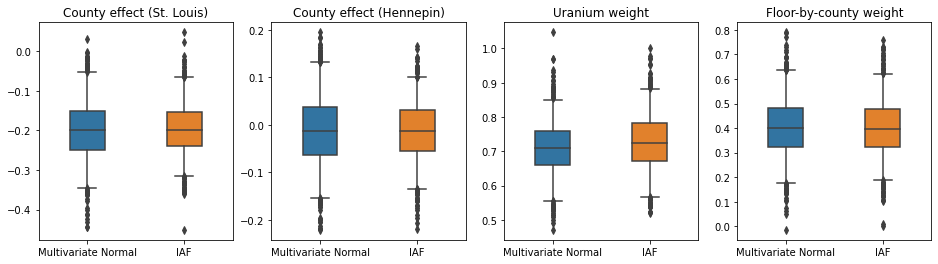

In [14]:
results['IAF'] = pack_samples(iaf_samples)
plot_boxplot(results)

Instructions for updating:
Do not call `graph_parents`.


Instructions for updating:
Do not call `graph_parents`.


Mean-field surrogate posterior ELBO: -1065.645751953125


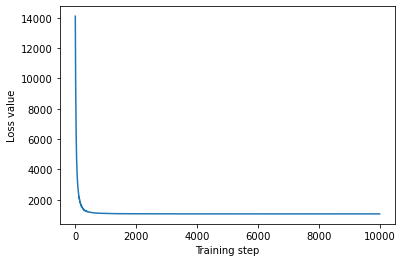

In [16]:
operators = (tf.linalg.LinearOperatorDiag, tf.linalg.LinearOperatorDiag, tf.linalg.LinearOperatorDiag)
block_diag_linop = (tfp.experimental.vi.util.build_trainable_linear_operator_block(operators, flat_event_size))
mean_field_scale = tfb.ScaleMatvecLinearOperatorBlock(block_diag_linop)
mean_field_loc = tfb.JointMap(tf.nest.map_structure(lambda s: tfb.Shift(tf.Variable(tf.random.uniform((s, ), minval=2.,
                                                    maxval=2., dtype=tf.float32))), flat_event_size))
mean_field_surrogate_posterior = tfd.TransformedDistribution(base_standard_dist, bijector=tfb.Chain([
    event_space_bijector, 
    unflatten_bijector, 
    reshape_bijector,
    mean_field_loc,
    mean_field_scale
]))
optimizer = tf.optimizers.Adam(learning_rate=1e-2)
mean_field_loss=tfp.vi.fit_surrogate_posterior(target_model.unnormalized_log_prob, mean_field_surrogate_posterior, 
                                              optimizer=optimizer, num_steps=10 ** 4, sample_size=16, jit_compile=True)
mean_field_samples = mean_field_surrogate_posterior.sample(1000)
mean_field_final_elbo = tf.reduce_mean(target_model.unnormalized_log_prob(*mean_field_samples) - 
                                       mean_field_surrogate_posterior.log_prob(mean_field_samples))
print('Mean-field surrogate posterior ELBO: {}'.format(mean_field_final_elbo))
plt.plot(mean_field_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')

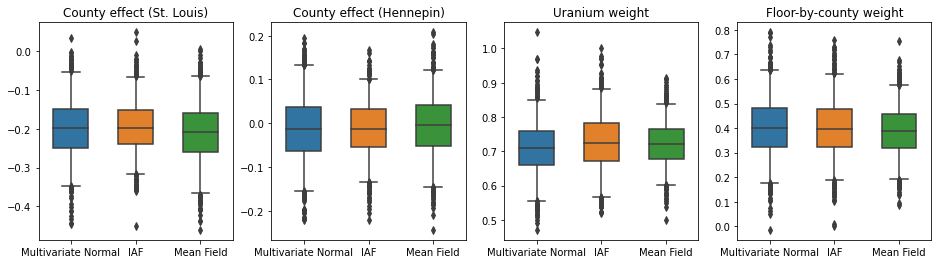

In [17]:
results["Mean Field"] = pack_samples(mean_field_samples)
plot_boxplot(results)

In [39]:
num_chains = 8
num_leapfrog_steps=3
step_size = 0.4
num_steps = 20000
flat_event_shape = tf.nest.flatten(target_model.event_shape)
enum_components = list(range(len(flat_event_shape)))
bijector = tfb.Restructure(enum_components, tf.nest.pack_sequence_as(target_model.event_shape, 
                                enum_components))(target_model.experimental_default_event_space_bijector())
current_state = bijector(tf.nest.map_structure(lambda e: tf.zeros([num_chains] + list(e), dtype=tf.float32), 
                                               target_model.event_shape))
hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=target_model.unnormalized_log_prob, 
                                     num_leapfrog_steps=num_leapfrog_steps, step_size=[tf.fill(s.shape, step_size) 
                                                        for s in current_state])
hmc = tfp.mcmc.TransformedTransitionKernel(hmc, bijector)
hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(hmc, num_adaptation_steps=int(num_steps // 2 * 0.8), 
                                               target_accept_prob=0.9)
chain, is_accepted = tf.function(lambda current_state: tfp.mcmc.sample_chain(current_state=current_state, kernel=hmc,
                                                        num_results=num_steps // 2, num_burnin_steps=num_steps//2, 
                                        trace_fn = lambda _ , pkr: (pkr.inner_results.inner_results.is_accepted)),
                                        autograph=False, jit_compile=True)(current_state)
accept_rate = tf.reduce_mean(tf.cast(is_accepted, tf.float32))
ess = tf.nest.map_structure(lambda c: tfp.mcmc.effective_sample_size(c, cross_chain_dims=1, 
                                                                     filter_beyond_positive_pairs=True), chain)
t_hat = tf.nest.map_structure(tfp.mcmc.potential_scale_reduction, chain)
hmc_samples = pack_samples(tf.nest.pack_sequence_as(target_model.event_shape, chain))
print("Acceptance rate is {}".format(accept_rate))

Acceptance rate is 0.9015750288963318


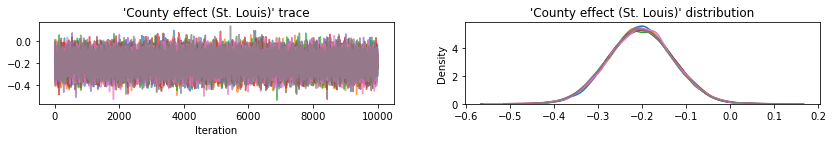

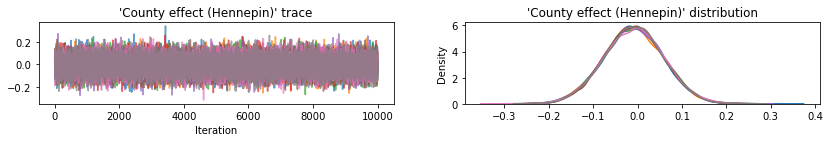

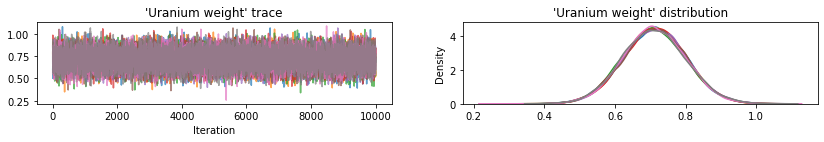

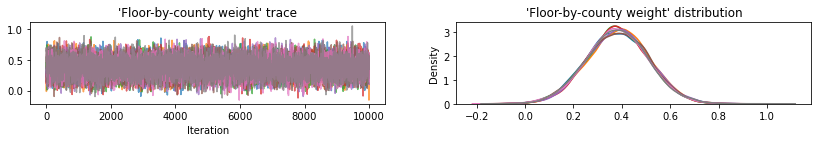

In [41]:
def plot_traces(var_name, samples):
    fig, axes = plt.subplots(1, 2, figsize=(14, 1.5), sharex='col', sharey='col')
    for chain in range(num_chains):
        s = samples.numpy()[:, chain]
        axes[0].plot(s, alpha=0.7)
        sns.kdeplot(s, ax=axes[1], shade=False)
        axes[0].title.set_text("'{}' trace".format(var_name))
        axes[1].title.set_text("'{}' distribution".format(var_name))
        axes[0].set_xlabel('Iteration')
warnings.filterwarnings('ignore')
for var, var_samples in hmc_samples.items():
    plot_traces(var, var_samples)

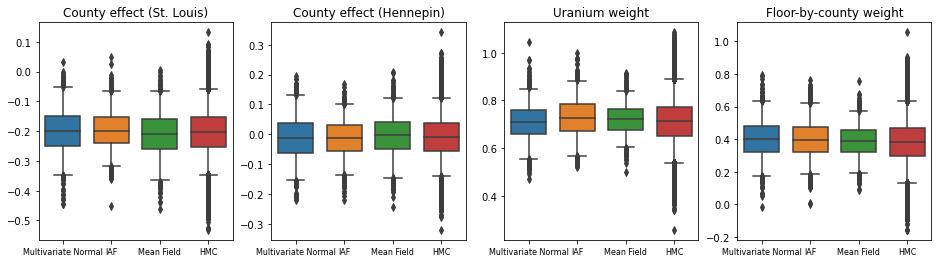

In [43]:
results['HMC'] = hmc_samples
plot_boxplot(results)

In [48]:
plt.rcParams.update({'axes.titlesize': 'medium', 'xtick.labelsize':'medium'})
def plot_loss_and_elbo():
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].scatter([0, 1, 2], [mvn_final_elbo.numpy(), 
                               iaf_final_elbo.numpy(),
                               mean_field_final_elbo.numpy()])
    axes[0].set_xticks(ticks=[0, 1, 2])
    axes[0].set_xticklabels(labels=['Multivariate Normal', 'IAF', 'Mean Field'])
    axes[0].title.set_text('Evidence Lower Bound (ELBO)')
    axes[1].plot(mvn_loss, label="Multivariate Normal")
    axes[1].plot(iaf_loss, label='IAF')
    axes[1].plot(mean_field_loss, label="Mean Field")
    axes[1].set_ylim([1000, 4000])
    axes[1].set_xlabel("Training step")
    axes[1].set_ylabel('Loss (negative ELBO)')
    axes[1].title.set_text("Loss")
    plt.legend()
    plt.show()

plt.rcParams.update({'axes.titlesize': 'medium', 'xtick.labelsize':'small'})
def plot_kdes(num_chains=8):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    k = list(results.values())[0].keys()
    plot_results = {v: {p: results[p][v] for p in results} for v in k}
    for i, (var, var_results) in enumerate(plot_results.items()):
        ax = axes[i % 2 , i // 2]
        for posterior, posterior_results in var_results.items():
            if posterior == 'HMC':
                label = posterior
                for chain in range(num_chains):
                    sns.kdeplot(posterior_results[:, chain], ax=ax, shade=False, color='k', linestyle=':', label=label)
                    label = None
            else:
                sns.kdeplot(posterior_results, ax=ax, shade=False, label=posterior)
                ax.title.set_text('{}'.format(var))
        ax.legend()

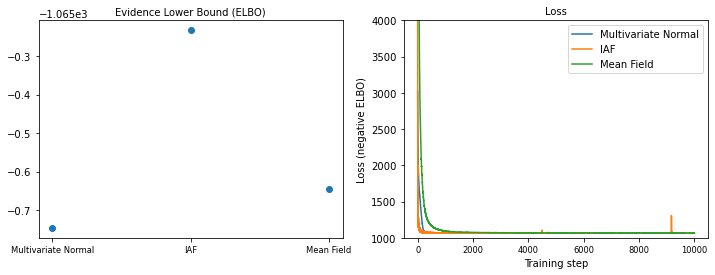

In [49]:
plot_loss_and_elbo()

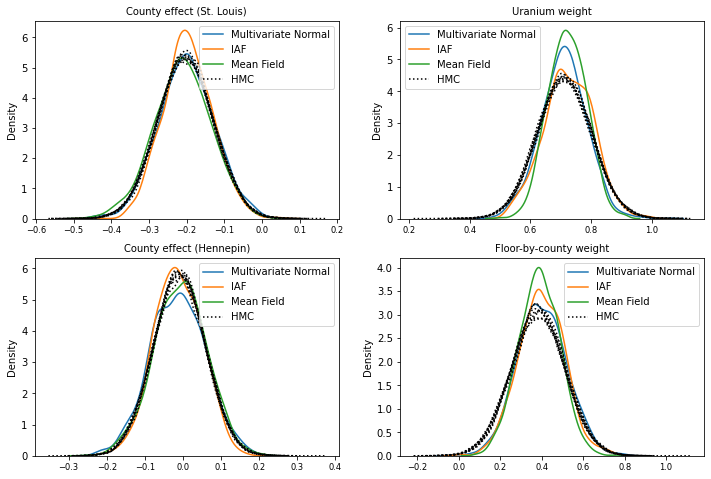

In [50]:
plot_kdes()

# Tensorflow Probability Case Study: Covariance Estimation

In [1]:
import collections
import math
import os
import time
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
true_mean = np.zeros([2], dtype=np.float32)
true_cor = np.array([[1.0, 0.9], [0.9, 1.0]], dtype=np.float32)
true_var = np.array([4.0, 1.0], dtype=np.float32)
true_cov = np.expand_dims(np.sqrt(true_var), axis=1).dot(np.expand_dims(np.sqrt(true_var), axis=1).T) * true_cor
true_precision = np.linalg.inv(true_cov)

In [3]:
print(true_cov)
print('eignvalues:', np.linalg.eigvals(true_cov))

[[4.  1.8]
 [1.8 1. ]]
eignvalues: [4.843075   0.15692513]


In [4]:
np.random.seed(123)
my_data = np.random.multivariate_normal(mean=true_mean, cov=true_cov, size=100, check_valid='ignore').astype(np.float32)

In [5]:
my_data.shape

(100, 2)

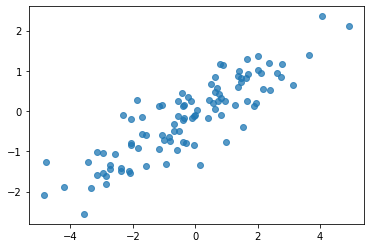

In [6]:
plt.scatter(my_data[:, 0], my_data[:, 1], alpha=0.75)
plt.show()

In [7]:
print("mean of observations: ", np.mean(my_data, axis=0))
print('true mean:', true_mean)

mean of observations:  [-0.24009615 -0.16638893]
true mean: [0. 0.]


In [8]:
print('covariance of observations: \n', np.cov(my_data, rowvar=False))
print('true covariance: \n', true_cov)

covariance of observations: 
 [[3.95307734 1.68718486]
 [1.68718486 0.94910269]]
true covariance: 
 [[4.  1.8]
 [1.8 1. ]]


In [9]:
def log_lik_data_numpy(precision, data):
    cov = np.linalg.inv(precision)
    rv = scipy.stats.multivariate_normal(true_mean, cov)
    return np.sum(rv.logpdf(data))
log_lik_data_numpy(true_precision, my_data)

-280.81822950593767

In [10]:
PRIOR_DF = 3
PRIOR_SCALE = np.eye(2, dtype=np.float32)
def log_lik_prior_numpy(precision):
    rv = scipy.stats.wishart(df=PRIOR_DF, scale=PRIOR_SCALE)
    return rv.logpdf(precision)
log_lik_prior_numpy(true_precision)

-5.820497303762504

In [11]:
n = my_data.shape[0]
nu_prior = PRIOR_DF
v_prior = PRIOR_SCALE
nu_posterior = nu_prior + n
v_posterior = np.linalg.inv(np.linalg.inv(v_prior) + my_data.T.dot(my_data))
posterior_mean = nu_posterior * v_posterior
v_post_diag = np.expand_dims(np.diag(v_posterior), axis=1)
posterior_sd = np.sqrt(nu_posterior * (v_posterior ** 2.0 + v_post_diag.dot(v_post_diag.T)))

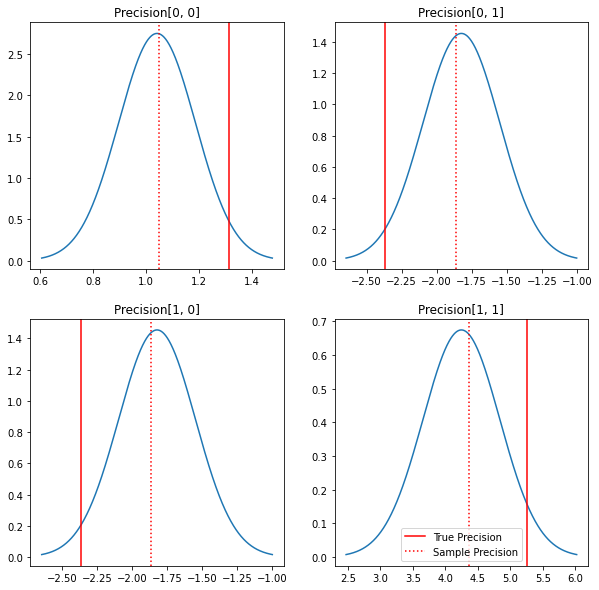

In [12]:
sample_precision = np.linalg.inv(np.cov(my_data, rowvar=False, bias=False))
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        loc = posterior_mean[i, j]
        scale=posterior_sd[i, j]
        xmin = loc - 3.0 * scale
        xmax = loc + 3.0 * scale
        x = np.linspace(xmin, xmax, 1000)
        y = scipy.stats.norm.pdf(x, loc=loc, scale=scale)
        ax.plot(x, y)
        ax.axvline(true_precision[i, j], color="red", label='True Precision')
        ax.axvline(sample_precision[i, j], color="red", linestyle=':', label="Sample Precision")
        ax.set_title('Precision[%d, %d]'%(i, j))
plt.legend()
plt.show()

In [13]:
norm1 = tfd.Normal(loc=0., scale=1.)
probs1 = norm1.log_prob(tf.constant([1., 0.5, 0.]))
norm2 = tfd.Normal(loc=[0., 2., 4.], scale=[1., 1., 1.])
probs2 = norm2.log_prob(tf.constant([1., 0.5, 0.]))
print('iid draws from a single normal:', probs1.numpy())
print('draws from a batch of normals : ', probs2.numpy())

iid draws from a single normal: [-1.4189385 -1.0439385 -0.9189385]
draws from a batch of normals :  [-1.4189385 -2.0439386 -8.918939 ]


In [14]:
VALIDATE_ARGS = True
ALLOW_NAN_STATS = False

In [15]:
def log_lik_data(precisions, replicated_data):
    n = tf.shape(precisions)[0]
    precisions_cholesky = tf.linalg.cholesky(precisions)
    covariances = tf.linalg.cholesky_solve(precisions_cholesky, tf.linalg.eye(2, batch_shape=[n]))
    rv_data = tfd.MultivariateNormalFullCovariance(loc=tf.zeros([n, 2]), covariance_matrix=covariances, 
                                                   validate_args=VALIDATE_ARGS, allow_nan_stats=ALLOW_NAN_STATS)
    return tf.reduce_sum(rv_data.log_prob(replicated_data), axis=0)

In [16]:
n = 2
replicated_data = np.tile(np.expand_dims(my_data, axis=1), reps=[1, 2, 1])
print(replicated_data.shape)

(100, 2, 2)


In [17]:
precisions = np.stack([np.eye(2, dtype=np.float32), true_precision])
n = precisions.shape[0]
lik_tf = log_lik_data(precisions, replicated_data=replicated_data).numpy()
for i in range(n):
    print(i)
    print('numpy:', log_lik_data_numpy(precisions[i], my_data))
    print('tensorflow:', lik_tf[i])

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
0
numpy: -430.71218815801365
tensorflow: -430.71207
1
numpy: -280.81822950593767
tensorflow: -280.8182


In [18]:
@tf.function(autograph=False)
def log_lik_prior(precisions):
    rv_precision = tfd.WishartTriL(df=PRIOR_DF, scale_tril=tf.linalg.cholesky(PRIOR_SCALE), validate_args=VALIDATE_ARGS,
                                  allow_nan_stats=ALLOW_NAN_STATS)
    return rv_precision.log_prob(precisions)

In [19]:
precisions = np.stack([np.eye(2, dtype=np.float32), true_precision])
n = precisions.shape[0]
lik_tf = log_lik_prior(precisions).numpy()
for i in range(n):
    print(i)
    print('numpy:', log_lik_prior_numpy(precisions[i]))
    print('tensorflow:', lik_tf[i])

0
numpy: -3.5310242469692907
tensorflow: -3.5310242
1
numpy: -5.820497303762504
tensorflow: -5.8204975


In [20]:
def get_log_lik(data, n_chains=1):
    replicated_data = np.tile(np.expand_dims(data, axis=1), reps=[1, n_chains, 1])
    @tf.function(autograph=False)
    def _log_lik(precision):
        return log_lik_data(precision, replicated_data)
    return _log_lik

In [21]:
@tf.function(autograph=False)
def sample():
    tf.random.set_seed(123)
    init_precision = tf.expand_dims(tf.eye(2), axis=0)
    log_lik_fn = get_log_lik(my_data, n_chains=1)
    num_results=10
    num_burnin_steps = 10
    states = tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
            current_state=[init_precision], kernel=tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=log_lik_fn, 
                                                                                 step_size=0.1, num_leapfrog_steps=3), 
                                  trace_fn=None, seed=123)
    return states
try:
    states = sample()
except Exception as e:
    lines = str(e).split('\n')
    print('\n'.join(lines[:5] + ['...'] + lines[-3:]))

 Input matrix is not invertible.
	 [[node cholesky_solve/MatrixTriangularSolve
 (defined at <ipython-input-15-9d1b6157e84b>:4)
]] [Op:__inference_sample_1245]

...
Function call stack:
sample -> _log_lik



In [22]:
def get_log_lik_verbose(data, n_chains=1):
    replicated_data = np.tile(np.expand_dims(data, axis=1), reps=[1, n_chains, 1])
    def _log_lik(precisions):
        def _print_precisions(precisions):
            print('precision:\n', precisions)
            return False
        print_op = tf.compat.v1.py_func(_print_precisions, [precisions], tf.bool)
        assert_op = tf.assert_equal(precisions, tf.linalg.matrix_transpose(precisions), message='not symmetrical', 
                                    summarize=4, name='symmetry_check')
        with tf.control_dependencies([print_op, assert_op]):
            return (log_lik_data(precisions, replicated_data) + log_lik_prior(precisions))
    return _log_lik

In [23]:
@tf.function(autograph=False)
def sample():
    tf.random.set_seed(123)
    init_precision=tf.eye(2)[tf.newaxis, ...]
    log_lik_fn = get_log_lik_verbose(my_data)
    num_results=10
    num_burnin_steps=10
    states = tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                                   current_state=[init_precision], kernel=tfp.mcmc.HamiltonianMonteCarlo(
                                       target_log_prob_fn=log_lik_fn, step_size=0.1, num_leapfrog_steps=3), 
                                   trace_fn=None, seed=123)
try:
    states = sample()
except Exception as e:
    lines = str(e).split('\n')
    print('\n'.join(lines[:5] + ['...'] + lines[-3:]))

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
precision:
 [[[1. 0.]
  [0. 1.]]]
precision:
 [[[ 0.29376215 -0.503801  ]
  [-0.422474    1.0343131 ]]]
 assertion failed: [not symmetrical] [Condition x == y did not hold element-wise:] [x (mcmc_sample_chain/trace_scan/while/smart_for_loop/while/mh_one_step/hmc_kernel_one_step/leapfrog_integrate/while/leapfrog_integrate_one_

In [24]:
precision_to_unconstrained = tfb.Chain([
    tfb.Invert(tfb.FillTriangular(validate_args=VALIDATE_ARGS)),
    tfb.TransformDiagonal(tfb.Invert(tfb.Exp(validate_args=VALIDATE_ARGS))),
    tfb.Invert(tfb.CholeskyOuterProduct(validate_args=VALIDATE_ARGS))
])

In [25]:
m = tf.constant([[1., 2.], [2., 8.]])
m_fwd = precision_to_unconstrained.forward(m)
m_inv = precision_to_unconstrained.inverse(m_fwd)

m2 = tf.stack([m, tf.eye(2)])
m2_fwd = precision_to_unconstrained.forward(m2)
m2_inv = precision_to_unconstrained.inverse(m2_fwd)

print('single input:')
print('m:\n', m.numpy())
print("Precision_to_unconstrained(m):\n", m_fwd.numpy())
print("inverse(precision_to_unconstrained(m)):\n", m_inv.numpy())
print()

print('tensor of inputs:')
print('m2:\n', m2.numpy())
print('precision_to_unconstrained(m2):\n', m2_fwd.numpy())
print('inverse(precision_to_unconstrained(m2)):\n',m2_inv.numpy())

single input:
m:
 [[1. 2.]
 [2. 8.]]
Precision_to_unconstrained(m):
 [0.6931472 2.        0.       ]
inverse(precision_to_unconstrained(m)):
 [[1. 2.]
 [2. 8.]]

tensor of inputs:
m2:
 [[[1. 2.]
  [2. 8.]]

 [[1. 0.]
  [0. 1.]]]
precision_to_unconstrained(m2):
 [[0.6931472 2.        0.       ]
 [0.        0.        0.       ]]
inverse(precision_to_unconstrained(m2)):
 [[[1. 2.]
  [2. 8.]]

 [[1. 0.]
  [0. 1.]]]


In [26]:
def log_lik_prior_transformed(transformed_precisions):
    rv_precision = tfd.TransformedDistribution(tfd.WishartTriL(df = PRIOR_DF, scale_tril=tf.linalg.cholesky(PRIOR_SCALE)
                                                               , validate_args=VALIDATE_ARGS, 
                                                               allow_nan_stats=ALLOW_NAN_STATS),
                                              bijector=precision_to_unconstrained, validate_args=VALIDATE_ARGS)
    return rv_precision.log_prob(transformed_precisions)

In [27]:
precisions = np.stack([np.eye(2, dtype=np.float32), true_precision])
transformed_precisions = precision_to_unconstrained.forward(precisions)
tik_tf = log_lik_prior_transformed(transformed_precisions).numpy()
corrections = precision_to_unconstrained.inverse_log_det_jacobian(transformed_precisions, event_ndims=1).numpy()
n = precisions.shape[0]
for i in range(n):
    print(i)
    print('numpy:', log_lik_prior_numpy(precisions[i]) + corrections[i])
    print('tensorflow:', tik_tf[i])

0
numpy: -2.1447298820400915
tensorflow: -2.1447299
1
numpy: -4.0225481088543615
tensorflow: -4.022548


In [28]:
def log_lik_data_transformed(transformed_precisions, replicated_data):
    n = tf.shape(transformed_precisions)[0]
    precisions = precision_to_unconstrained.inverse(transformed_precisions)
    precisions_cholesky = tf.linalg.cholesky(precisions)
    covariances = tf.linalg.cholesky_solve(precisions_cholesky, tf.linalg.eye(2, batch_shape=[n]))
    rv_data = tfd.MultivariateNormalFullCovariance(loc=tf.zeros([n, 2]), covariance_matrix=covariances, validate_args=
                                                  VALIDATE_ARGS, allow_nan_stats=ALLOW_NAN_STATS)
    return tf.reduce_sum(rv_data.log_prob(replicated_data), axis=0)

In [29]:
precisions = np.stack([np.eye(2, dtype=np.float32), true_precision])
trnasformed_precisions = precision_to_unconstrained.forward(precisions)
lik_tf = log_lik_data_transformed(transformed_precisions, replicated_data).numpy()
for i in range(precisions.shape[0]):
    print(i)
    print('numpy:', log_lik_data_numpy(precisions[i], my_data))
    print('tensorflow:', lik_tf[i])

0
numpy: -430.71218815801365
tensorflow: -430.71207
1
numpy: -280.81822950593767
tensorflow: -280.8182


In [30]:
def get_log_lik_transformed(data, n_chains=1):
    replicated_data = np.tile(np.expand_dims(data, axis=1), reps=[1, n_chains, 1])
    @tf.function(autograph=False)
    def _log_lik_transformed(transformed_precisions):
        return (log_lik_data_transformed(transformed_precisions, 
                                         replicated_data) + log_lik_prior_transformed(transformed_precisions))
    return _log_lik_transformed

In [31]:
log_lik_fn = get_log_lik_transformed(my_data)
m = tf.eye(2)[tf.newaxis, ...]
lik = log_lik_fn(precision_to_unconstrained.forward(m)).numpy()
print(lik)

[-432.8569]


In [32]:
np.random.seed(123)
initial_value_cholesky = np.array([
    [0.5 + np.random.uniform(), 0.0],
    [-0.5 + np.random.uniform(), 0.5 + np.random.uniform()]
], dtype=np.float32)
initial_value = initial_value_cholesky.dot(initial_value_cholesky.T)[np.newaxis, ...]
initial_value_transformed = precision_to_unconstrained.forward(initial_value).numpy()

In [33]:
@tf.function(autograph=False)
def sample():
    tf.random.set_seed(123)
    log_lik_fn = get_log_lik_transformed(my_data, n_chains=1)
    num_results = 1000
    num_burnin_steps=1000
    states, is_accepted = tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                                              current_state=[initial_value_transformed], kernel=
                                              tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=log_lik_fn, 
                                            step_size=0.1, num_leapfrog_steps=3), trace_fn=lambda _, pkr:
                                              pkr.is_accepted, seed=123)
    precision_samples = [precision_to_unconstrained.inverse(s) for s in states]
    return states, precision_samples, is_accepted
states, precision_samples, is_accepted = sample()

In [34]:
print('True posterior mean:\n', posterior_mean)
print('Sample mean:\n', np.mean(np.reshape(precision_samples, [-1, 2, 2]), axis=0))

True posterior mean:
 [[ 1.0422499 -1.823929 ]
 [-1.823929   4.2457886]]
Sample mean:
 [[ 1.4315274  -0.25587553]
 [-0.25587553  0.5740424 ]]


In [35]:
np.reshape(precision_samples, [-1, 2, 2])

array([[[ 1.4315385, -0.2558777],
        [-0.2558777,  0.5740494]],

       [[ 1.4315385, -0.2558777],
        [-0.2558777,  0.5740494]],

       [[ 1.4315385, -0.2558777],
        [-0.2558777,  0.5740494]],

       ...,

       [[ 1.4315385, -0.2558777],
        [-0.2558777,  0.5740494]],

       [[ 1.4315385, -0.2558777],
        [-0.2558777,  0.5740494]],

       [[ 1.4315385, -0.2558777],
        [-0.2558777,  0.5740494]]], dtype=float32)

In [36]:
print(np.squeeze(is_accepted)[-100:])
print('Fraction of samples accepted:', np.mean(np.squeeze(is_accepted)))

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Fraction of samples accepted: 0.0


In [37]:
N_CHAINS = 3
np.random.seed(123)
initial_values = []
for i in range(N_CHAINS):
    initial_value_cholesky = np.array([
        [0.5 + np.random.uniform(), 0.0],
        [-0.5 + np.random.uniform(), 0.5 + np.random.uniform()]
    ], dtype=np.float32)
    initial_values.append(initial_value_cholesky.dot(initial_value_cholesky.T))
initial_values = np.stack(initial_values)
initial_values_transformed = precision_to_unconstrained.forward(initial_values).numpy()

In [38]:
@tf.function(autograph=False)
def sample():
    tf.random.set_seed(123)
    log_lik_fn = get_log_lik_transformed(my_data)
    dtype = np.float32
    num_burnin_iter = 3000
    num_warmup_iter = int(0.8 * num_burnin_iter)
    num_chain_iter = 2500
    target_accept_rate = 0.651
    hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn = log_lik_fn, step_size=0.01, num_leapfrog_steps=3)
    adapted_kernel = tfp.mcmc.SimpleStepSizeAdaptation(inner_kernel=hmc, num_adaptation_steps=num_warmup_iter, 
                                                      target_accept_prob=target_accept_rate)
    states, is_accepted = tfp.mcmc.sample_chain(num_results=num_chain_iter, num_burnin_steps=num_burnin_iter, 
                                               current_state=initial_values_transformed, kernel=adapted_kernel,
                                               trace_fn = lambda _, pkr: pkr.inner_results.is_accepted, 
                                               parallel_iterations=1)
    precision_samples = precision_to_unconstrained.inverse(states)
    return states, precision_samples, is_accepted
states, precision_samples, is_accepted = sample()

In [39]:
print(np.mean(is_accepted))

0.5982666666666666


In [40]:
precision_samples_reshaped = np.reshape(precision_samples, [-1, 2, 2])
print('True posterior mean:\n', posterior_mean)
print('Mean of samples:\n', np.mean(precision_samples_reshaped, axis=0))

True posterior mean:
 [[ 1.0422499 -1.823929 ]
 [-1.823929   4.2457886]]
Mean of samples:
 [[ 1.0392768 -1.8179698]
 [-1.8179698  4.2357335]]


In [41]:
print('True posterior standard deviation:\n', posterior_sd)
print('Standard deviation of samples:\n', np.std(precision_samples_reshaped, axis=0))

True posterior standard deviation:
 [[0.14523399 0.2743375 ]
 [0.2743375  0.5916362 ]]
Standard deviation of samples:
 [[0.14615674 0.27166528]
 [0.27166528 0.5875813 ]]


In [42]:
r_hat = tfp.mcmc.potential_scale_reduction(precision_samples).numpy()
print(r_hat)

[[1.00872   1.0057116]
 [1.0057116 1.0035558]]


In [43]:
precision_samples_reshaped = np.reshape(precision_samples, [-1, 2, 2])

In [44]:
print('True posterior mean:\n', posterior_mean)
print('Mean of samples:\n', np.mean(precision_samples_reshaped, axis=0))

True posterior mean:
 [[ 1.0422499 -1.823929 ]
 [-1.823929   4.2457886]]
Mean of samples:
 [[ 1.0392768 -1.8179698]
 [-1.8179698  4.2357335]]


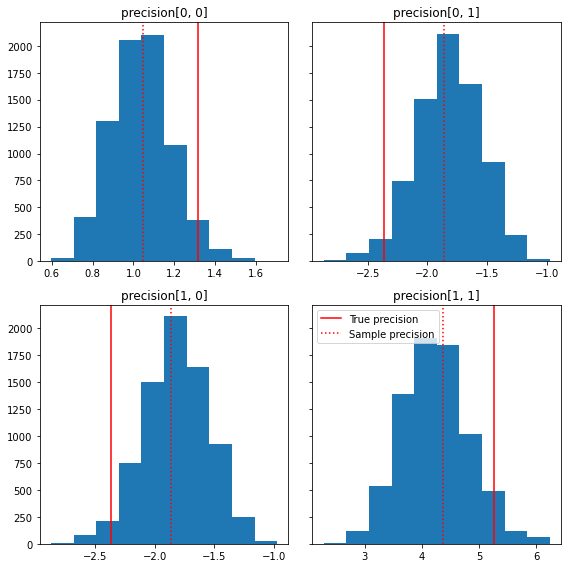

In [45]:
fig, axes = plt.subplots(2, 2, sharey=True)
fig.set_size_inches(8, 8)
for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        ax.hist(precision_samples_reshaped[:, i, j])
        ax.axvline(true_precision[i, j], color="red", label="True precision")
        ax.axvline(sample_precision[i, j], color="red", linestyle=":", label="Sample precision")
        ax.set_title('precision[%d, %d]'%(i, j))
plt.tight_layout()
plt.legend()
plt.show()

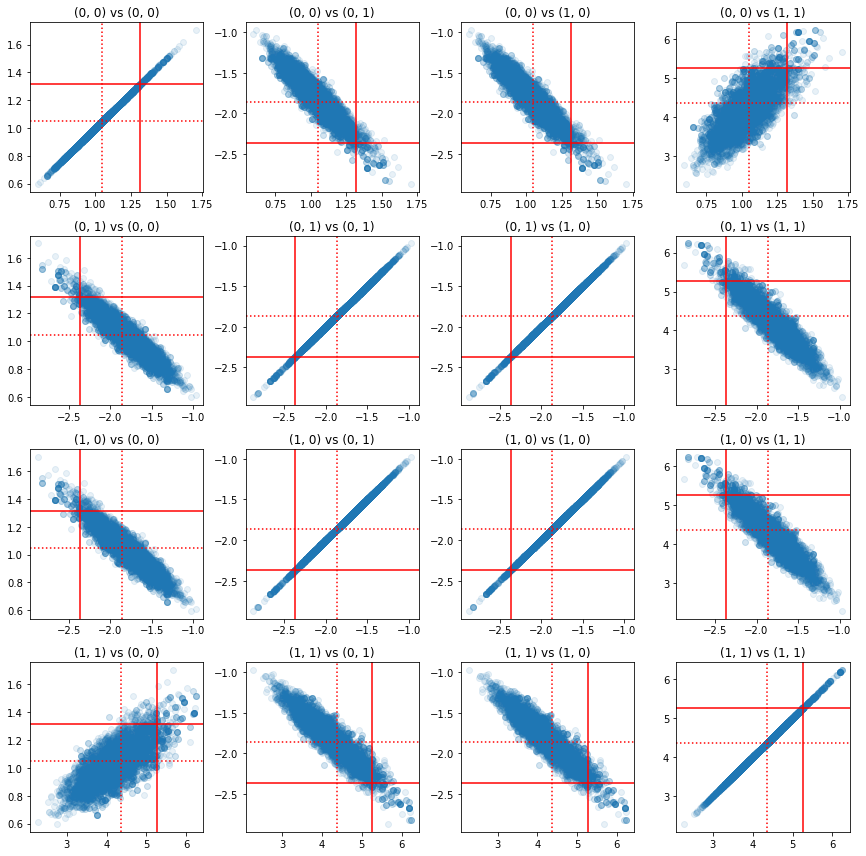

In [46]:
fig, axes = plt.subplots(4, 4)
fig.set_size_inches(12, 12)
for i1 in range(2):
    for j1 in range(2):
        index1 = 2 * i1 + j1
        for i2 in range(2):
            for j2 in range(2):
                index2 = 2 * i2 + j2
                ax = axes[index1, index2]
                ax.scatter(precision_samples_reshaped[:, i1, j1], precision_samples_reshaped[:, i2, j2], alpha=0.1)
                ax.axvline(true_precision[i1, j1], color="red")
                ax.axhline(true_precision[i2, j2], color="red")
                ax.axvline(sample_precision[i1, j1], color="red", linestyle=":")
                ax.axhline(sample_precision[i2, j2], color="red", linestyle=":")
                ax.set_title('(%d, %d) vs (%d, %d)'%(i1, j1, i2, j2))
plt.tight_layout()
plt.show()

In [47]:
unconstrained_to_precision = tfb.Chain([
    tfb.CholeskyOuterProduct(validate_args=VALIDATE_ARGS),
    tfb.TransformDiagonal(tfb.Exp(validate_args=VALIDATE_ARGS)),
    tfb.FillTriangular(validate_args=VALIDATE_ARGS)
])

In [48]:
m = [[1., 2.], [2., 8.]]
m_inv = unconstrained_to_precision.inverse(m).numpy()
m_fwd = unconstrained_to_precision.forward(m_inv).numpy()
print('m:\n', m)
print('uncpnstrained_to_precision.inverse(m):\n', m_inv)
print('forward(unconstrained_to_precision.inverse(m)):\n', m_fwd)

m:
 [[1.0, 2.0], [2.0, 8.0]]
uncpnstrained_to_precision.inverse(m):
 [0.6931472 2.        0.       ]
forward(unconstrained_to_precision.inverse(m)):
 [[1. 2.]
 [2. 8.]]


In [84]:
@tf.function(autograph=False)
def sample():
    tf.random.set_seed(123)
    log_lik_fn = get_log_lik(my_data)
    dtype= np.float32
    num_burnin_iter = 3000
    num_warmup_iter = int(0.8 * num_burnin_iter)
    num_chain_iter = 2500
    target_accept_rate = 0.651
    hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=log_lik_fn, step_size=0.01, num_leapfrog_steps=3)
    ttk = tfp.mcmc.TransformedTransitionKernel(inner_kernel=hmc, bijector=unconstrained_to_precision)
    adapted_kernel = tfp.mcmc.SimpleStepSizeAdaptation(inner_kernel=ttk, num_adaptation_steps=num_warmup_iter, 
                                                       target_accept_prob=target_accept_rate)
    states = tfp.mcmc.sample_chain(num_results=num_chain_iter, num_burnin_steps=num_burnin_iter, 
                                   current_state=initial_values, kernel=adapted_kernel, trace_fn=None, 
                                   parallel_iterations=1)
    return states
precision_samples = sample()

In [85]:
r_hat = tfp.mcmc.potential_scale_reduction(precision_samples).numpy()
print(r_hat)

[[1.009042  1.0079056]
 [1.0079056 1.0051444]]


In [86]:
precision_samples_reshaped = np.reshape(precision_samples, [-1, 2, 2])

In [87]:
print('True posterior mean:\n', posterior_mean)
print("Mean of samples:\n", np.mean(precision_samples_reshaped, axis=0))

True posterior mean:
 [[ 1.0422499 -1.823929 ]
 [-1.823929   4.2457886]]
Mean of samples:
 [[ 1.08442   -1.9192104]
 [-1.9192104  4.464159 ]]


In [88]:
print('True posterior standard deviation:\n', posterior_sd)
print('Standard deviation of samples:\n', np.std(precision_samples_reshaped, axis=0))

True posterior standard deviation:
 [[0.14523399 0.2743375 ]
 [0.2743375  0.5916362 ]]
Standard deviation of samples:
 [[0.14939663 0.28449515]
 [0.28449515 0.6208953 ]]


In [89]:
class CholeskyWishart(tfd.TransformedDistribution):
    def __init__(self, df, scale_tril, validate_args=False, allow_nan_stats=True, name="chleskyWishart"):
        super(CholeskyWishart, self).__init__(distribution=tfd.WishartTriL(df=df, scale_tril=scale_tril, 
                            input_output_cholesky=False, validate_args=validate_args, allow_nan_stats=allow_nan_stats),
                            bijector=tfb.Invert(tfb.CholeskyOuterProduct()), validate_args=validate_args, name=name)
        self.cholesky = tfd.WishartTriL(df=df, scale_tril=scale_tril, input_output_cholesky=True, 
                                        validate_args=validate_args, allow_nan_stats=allow_nan_stats)
    def _log_prob(self, x):
        return (self.cholesky.log_prob(x) + self.bijector.inverse_log_det_jacobian(x, event_ndims=2))
    def _sample_n(self, n, seed=None):
        return self.cholesky._sample_n(n, seed)

In [90]:
PRIOR_SCALE_CHOLESKY = np.linalg.cholesky(PRIOR_SCALE)
@tf.function(autograph=False)
def compute_log_prob(m):
    w_transformed = tfd.TransformedDistribution(tfd.WishartTriL(df=PRIOR_DF, scale_tril=PRIOR_SCALE_CHOLESKY), 
                                               bijector=tfb.Invert(tfb.CholeskyOuterProduct()))
    w_optimized = CholeskyWishart(df=PRIOR_DF, scale_tril=PRIOR_SCALE_CHOLESKY)
    log_prob_transformed = w_transformed.log_prob(m)
    log_prob_optimized = w_optimized.log_prob(m)
    return log_prob_transformed, log_prob_optimized
for matrix in [np.eye(2, dtype=np.float32), np.array([[1., 0.], [2., 8.]], dtype=np.float32)]:
    log_prob_transformed, log_prob_optimizer = [t.numpy() for t in compute_log_prob(matrix)]
    print('Transformed Wishart:', log_prob_transformed)
    print('OPtimized Wishart', log_prob_optimizer)

Transformed Wishart: -2.1447299
OPtimized Wishart -2.1447299
Transformed Wishart: -33.56529
OPtimized Wishart -33.56529


In [91]:
m = np.array([[1., 0.], [2., 8.]], dtype=np.float32)
c_inv = m.dot(m.T)
c = np.linalg.inv(c_inv)
c_chol = np.linalg.cholesky(c)
wishart_cholesky_to_iw_cholesky = tfb.CholeskyToInvCholesky()
w_fwd = wishart_cholesky_to_iw_cholesky.forward(m).numpy()
print('numpy =\n', c_chol)
print('bijector = \n', w_fwd)

numpy =
 [[ 1.0307764   0.        ]
 [-0.03031695  0.12126781]]
bijector = 
 [[ 1.0307764   0.        ]
 [-0.03031695  0.12126781]]


In [92]:
inverse_wishart_cholesky = tfd.TransformedDistribution(distribution=CholeskyWishart(df=PRIOR_DF, 
                    scale_tril = np.linalg.cholesky(np.linalg.inv(PRIOR_SCALE))), bijector=tfb.CholeskyToInvCholesky())

In [93]:
PRIOR_SCALE_CHOLESKY = np.linalg.cholesky(PRIOR_SCALE)
def log_lik_prior_cholesky(precisions_cholesky):
    rv_precision = CholeskyWishart(df=PRIOR_DF, scale_tril=PRIOR_SCALE_CHOLESKY, validate_args=VALIDATE_ARGS, 
                                   allow_nan_stats=ALLOW_NAN_STATS)
    return rv_precision.log_prob(precisions_cholesky)

In [94]:
precisions = [np.eye(2, dtype=np.float32), true_precision]
precisions_cholesky = np.stack([np.linalg.cholesky(m) for m in precisions])
precisions = np.stack(precisions)
lik_tf = log_lik_prior_cholesky(precisions_cholesky).numpy()
lik_tf_slow = tfd.TransformedDistribution(distribution=tfd.WishartTriL(df=PRIOR_DF, 
            scale_tril=tf.linalg.cholesky(PRIOR_SCALE)), 
            bijector=tfb.Invert(tfb.CholeskyOuterProduct())).log_prob(precisions_cholesky).numpy()
corrections = tfb.Invert(tfb.CholeskyOuterProduct()).inverse_log_det_jacobian(precisions_cholesky, 
                                                                              event_ndims=2).numpy()
n = precisions.shape[0]
for i in range(n):
    print(i)
    print("numpy:", log_lik_prior_numpy(precisions[i]) + corrections[i])
    print('tensorflow slow:', lik_tf_slow[i])
    print('tensorflow:', lik_tf[i])

0
numpy: -2.1447298820400915
tensorflow slow: -2.1447299
tensorflow: -2.1447299
1
numpy: -4.159765988149711
tensorflow slow: -4.159766
tensorflow: -4.159766


In [95]:
class MVNPrecisionCholesky(tfd.TransformedDistribution):
    def __init__(self, loc, precision_cholesky, name=None):
        super(MVNPrecisionCholesky, self).__init__(distribution=tfd.Independent(tfd.Normal(loc=tf.zeros_like(loc), 
                                        scale=tf.ones_like(loc)), reinterpreted_batch_ndims=1), bijector=
                    tfb.Chain([tfb.Shift(shift=loc), tfb.Invert(tfb.ScaleMatvecTriL(scale_tril=precision_cholesky))]),
                                                  name=name)

In [96]:
@tf.function(autograph=False)
def log_lik_data_cholesky(precisions_cholesky, replicated_data):
    n = tf.shape(precision_cholesky)[0]
    rv_data = MVNPrecisionCholesky(loc=tf.zeros([n, 2]), precision_cholesky=precision_cholesky)
    return tf.reduce_sum(rv_data.log_prob(replicated_data), axis=0)

In [97]:
true_precision_cholesky = np.linalg.cholesky(true_precision)
precision = [np.eye(2, dtype=np.float32), true_precision]
precision_cholesky = np.stack([np.linalg.cholesky(m) for m in precisions])
precision = np.stack(precisions)
n = precisions_cholesky.shape[0]
replicated_data = np.tile(np.expand_dims(my_data, axis=1), reps=[1, 2, 1])
lik_tf = log_lik_data_cholesky(precisions_cholesky, replicated_data).numpy()
for i in range(n):
    print(i)
    print('numpy:', log_lik_data_numpy(precisions[i], my_data))
    print('tensorflow:', lik_tf[i])

0
numpy: -430.71218815801365
tensorflow: -430.71207
1
numpy: -280.81822950593767
tensorflow: -973.0591


In [98]:
def get_log_lik_cholesky(data, n_chains=1):
    replicated_data = np.tile(np.expand_dims(data, axis=1), reps=[1, n_chains, 1])
    @tf.function(autograph=False)
    def _log_lik_cholesky(precisions_cholesky):
        return (log_lik_data_cholesky(precisions_cholesky, replicated_data) + 
                log_lik_prior_cholesky(precisions_cholesky))
    return _log_lik_cholesky

In [99]:
unconstrained_to_precision_cholesky = tfb.Chain([
    tfb.TransformDiagonal(tfb.Exp(validate_args=VALIDATE_ARGS)),
    tfb.FillTriangular(validate_args=VALIDATE_ARGS)
])

In [100]:
inv = unconstrained_to_precision_cholesky.inverse(precisions_cholesky).numpy()
fwd = unconstrained_to_precision_cholesky.forward(inv).numpy()
print('precisions_cholesky:\n', precisions_cholesky)
print("\ninv:\n", inv)
print("\nfwd(inv):\n", fwd)

precisions_cholesky:
 [[[ 1.         0.       ]
  [ 0.         1.       ]]

 [[ 1.1470785  0.       ]
  [-2.0647411  1.0000004]]]

inv:
 [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 3.5762781e-07 -2.0647411e+00  1.3721828e-01]]

fwd(inv):
 [[[ 1.         0.       ]
  [ 0.         1.       ]]

 [[ 1.1470785  0.       ]
  [-2.0647411  1.0000004]]]


In [101]:
N_CHAINS = 3
np.random.seed(123)
initial_values_cholesky = []
for i in range(N_CHAINS):
    initial_values_cholesky.append(np.array([
        [0.5 + np.random.uniform(), 0.0],
        [-0.5 + np.random.uniform(), 0.5 + np.random.uniform()]
    ], dtype=np.float32))
initial_values_cholesky = np.stack(initial_values_cholesky)

In [102]:
@tf.function(autograph=False)
def sample():
    tf.random.set_seed(123)
    log_lik_fn = get_log_lik_cholesky(my_data)
    dtype = np.float32
    num_burnin_iter = 3000
    num_warmup_iter = int(0.8 * num_burnin_iter)
    num_chain_iter = 2500
    target_accept_rate = 0.651
    hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn = log_lik_fn, step_size=0.01, num_leapfrog_steps=3)
    ttk = tfp.mcmc.TransformedTransitionKernel(inner_kernel=hmc, bijector=unconstrained_to_precision_cholesky)
    adapted_kernel = tfp.mcmc.SimpleStepSizeAdaptation(inner_kernel=ttk, num_adaptation_steps=num_warmup_iter, 
                                                       target_accept_prob=target_accept_rate)
    states = tfp.mcmc.sample_chain(num_results=num_chain_iter, num_burnin_steps=num_burnin_iter, 
                                   current_state=initial_values, kernel=adapted_kernel, trace_fn=None, 
                                   parallel_iterations=1)
    samples = tf.linalg.matmul(states, states, transpose_b=True)
    return samples
precision_sameples = sample()

ValueError: Dimensions must be equal, but are 2 and 3 for '{{node add}} = AddV2[T=DT_FLOAT](PartitionedCall, chleskyWishart/log_prob/add)' with input shapes: [2], [3].